In [48]:
import numpy as np
import pandas as pd
from scipy import stats
import random

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


## Classes used for the sampling algorithms.

In [49]:
class Proposal():
    """
    This class defines the proposals can be used for the non reversible sampler, 
    the Metropolis Hastings Algorithm.These need to be defined since they will be 
    used in the algorithm of choice. 
    
    In particluar we have 4 possible proposals:
    -Random walk
    -Random walk two dimesnions 
    -Random walk n dimesnions 
    -Pre-Condtioned Crank Nicolson 
    """
    
    def __init__(self, beta, pick):
        """
        To inialize we need two parameters, first the parameter for the algorithm beta 
        (int) and we need to decide which proposal to pick (str).
        The pick variable can take 4 values:
        -Random walk: "random_walk"
        -Random walk two dimesnions: "random_walk_2d"
        -Random walk n dimesnions: "random_walk_nd"
        -Pre-Condtioned Crank Nicolson: "pCN"
        """
        self.beta = beta
        self.pick = pick
    
    def get_random_variable(self, x_t):
        """
        Depending on the proposal it returns a random variable given sample x_t.
        """
        if self.pick == "random_walk":
            return self.random_walk(x_t).rvs()
        if self.pick == "pCN":
            return self.pCN(x_t).rvs()
        if self.pick == "random_walk_2d":
            return self.random_walk_2d(x_t).rvs()
        if self.pick == "random_walk_nd":
            return self.random_walk_nd(x_t).rvs()
        
    def get_dist(self, u_t):
        """
        Depending on the proposal it returns the distribution of the proposal.
        """
        if self.pick == "random_walk":
            return self.random_walk(u_t)
        if self.pick == "pCN":
            return self.pCN(u_t)
        if self.pick == "random_walk_2d":
            return self.random_walk_2d(u_t)
        if self.pick == "random_walk_nd":
            return self.random_walk_nd(u_t)
         
    def random_walk(self, x_t):
        """
        Definition of random walk distribution centred at sample x_t.
        """
        return stats.norm([x_t],[self.beta**2])
    
    def pCN(self, x_t):
        """
        Definition of pCN distribution centred at sample x_t.
        """
        return stats.norm([np.sqrt(1-self.beta**2)*x_t],[8*self.beta**2])
    
    def random_walk_2d(self, x_t):
        """
        Definition of random walk two dimesnional distribution centred at sample x_t.
        """
        return stats.multivariate_normal([int(x_t[0]),int(x_t[1])],[[self.beta**2,0],[0,self.beta**2]])
    
    def random_walk_nd(self, x_t):
        """
        Definition of random walk n dimensional distribution centred at sample x_t.
        """
        n = len(x_t)
        return stats.multivariate_normal(x_t, np.eye(n)*(self.beta**2))

In [50]:
class Normal_Distribution():
    
    def __init__(self, mu, sigma):
        """
        mu = mean of distribution (int)
        sigma = standard deviation of distribution (int)
        """
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        """
        Returns pdf value at x. Where x is the value we want to evaluate
        """
        from scipy import stats
        return stats.norm([self.mu],[self.sigma]).pdf(x)[0]
        
class Log_Normal_Distribution():
    
    def __init__(self, mu, sigma):
        """
        mu = mean of distribution (int)
        theta = standard deviation of distribution (int)
        """
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        """
        Returns pdf value at x. Where x is the value we want to evaluate
        """
        from scipy import stats
        return stats.lognorm([self.sigma],loc=self.mu).pdf(x)[0]

class Gaussian_Mixture():
    
    def __init__(self, pi_s):
        """
        pi_s = pi_s is a list of normal distributions made with stats.norm([mu],[sigma])
        """
        self.pi_s = pi_s

    def pdf(self, x):
        """
        Returns pdf value at x. Where x is the value we want to evaluate
        """
        return sum([pi.pdf(x) for pi in self.pi_s])
    
# n-Dimensional distribtions we wish to explore
class Multivariate_Gaussian():
    
    def __init__(self, mu, covariance):
        """
        mu = mean of distribution (list of int). Example: [10,5]
        covariance = covariance matrix (list of lists of int). Example: [[1,0],[0,1]]
        """
        self.mu = mu
        self.covariance = covariance

    def pdf(self, x):
        """
        Returns pdf value at x. Where x is the value we want to evaluate
        """
        from scipy import stats
        return stats.multivariate_normal(self.mu,self.covariance).pdf(x)

class Rosenbrook_2D_Function():
    
    def __init__(self, coef_1):
        """
        coeff_1 = Scaling varibale (int)
        """
        self.coef_1 = coef_1
    
    def pdf(self, x):
        """
        Returns pdf value at x. Where x is the value we want to evaluate
        """
        return np.exp(-((100*(x[1] - x[0]**2)**2 + (1 - x[0])**2)/self.coef_1)) 

In [51]:
class Reversible_Sampler():
    """
    Class definition for the non reverisble sampler.
    In both one and two dimensions.
    """
    
    def __init__(self, N, dimension, target_distribution, proposal):
        #Beta values which we get from the proposal
        self.beta = proposal.beta
        #N is the number of iterations the algorithm runs for (int)
        self.N = N
        #dimension is the dimension of the state space (int) 1 or 2.
        self.dimension = dimension
        #proposal denisty defined using Class Proposal.
        self.proposal = proposal
        #target_distribution defined using the Class definitions 
        #for target distributions.
        self.target_distribution = target_distribution
    
    def Reversible_Metropolis_Hastings_Algo(self):
        """
        Implementation of the Metropolis Hastings Algorithm.
        
        Output:
        -samples: List of samples which are integers or tuples in 2d
        -list_acceptance_probaility: List of acceptance probabilities used
        for tuning the algorithm.
        """
        
        # initalize in this case we set the inital sample
        # at 0 for consitency can be initalized at any 
        # value with positive probability.
        if self.dimension == 1:
            x_0 = 0
            x_t = x_0
        #In two dimensions initialize at [-5,-5]
        #Again this can be any
        else: 
            x_0 = list([-5,-5])
            x_t = x_0
        
        #list of samples generated by the algorithm
        samples = [x_0]
        #list of accepttance probability at each iteration of the algorithm
        list_acceptance_probaility = []
        
        #We define two new variables such that they are the 
        #Proposal and posterior distirbution of the problem
        posterior_distribution = self.target_distribution
        proposal = self.proposal
        
        #Begin iterations
        for t in range(self.N):

            #Sample a proposal x_prime from proposal at x_t
            x_prime = proposal.get_random_variable(x_t)

            #Proposal density at x_prime and x_t for acceptance ratio
            proposal_density_prime = proposal.get_dist(x_prime)
            proposal_density_t = proposal.get_dist(x_t)

            #Evaluation of the numerator of acceptance ratio
            numerator = posterior_distribution.pdf(x_prime)*float(proposal_density_prime.pdf(x_t))
            #Evaluation of the denomiantor of acceptance ratio
            denominator = posterior_distribution.pdf(x_t)*float(proposal_density_t.pdf(x_prime))
            
            #Calculate acceptance proability 
            if numerator == 0:
                acceptance_probaility = 0
            elif denominator == 0:
                acceptance_probaility = 1
            else:
                acceptance_probaility = float(min([1,numerator/denominator]))
            
            #Add acceptance probability to list_acceptance_probaility 
            list_acceptance_probaility.append(acceptance_probaility)
            
            #Sample a random variable
            rv = np.random.uniform(0,1,1)

            #Accept or reject step
            if rv <= acceptance_probaility:
                #Accept: we update x_t to x_prime
                x_t = x_prime
                samples.append(x_t)
            else:
                #Reject: we remain at x_t
                x_t = x_t
                samples.append(x_t)
        
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility

In [52]:
class Sampler_Non_Reversible():
    """
    Class definition for the non reverisble sampler.
    Both in one dimension and n dimensions.
    """    
    def __init__(self, alpha, beta, N, dimension, target_distribution):
        
        #Alpha for the gamma distrbution (a)
        self.alpha = alpha
        #Beta for the gamma distrbution (b) / also used as sigma for n dimensional
        self.beta = beta
        #N is the number of iterations the algorithm runs for (int)
        self.N = N
        #dimension is the dimension of the state space.
        self.dimension = dimension
        #target_distribution defined using the Class definitions 
        #for target distributions.
        self.target_distribution = target_distribution
           
    def Non_Reversible_Metropolis_Hastings_Algo(self):
        """
        Implementation of the One-Directional I-Jump Sampler.
        
        Output:
        -samples: List of samples which are integers.
        -list_acceptance_probaility: List of acceptance probabilities used
        for tuning the algorithm.
        """
        # initalize in this case we set the inital sample
        # at 1 for consitency can be initalized at any 
        # value with positive probability.
        x_0 = 1
        x_t = x_0
        
        #list of samples generated by the algorithm
        samples = [x_t]
        #list of accepttance probability at each iteration of the algorithm
        list_acceptance_probaility = []
        
        #We define variables such that they are the 
        #posterior distirbution of the problem
        posterior_distribution = self.target_distribution
        
        #We inizalize the z indicator random varibale
        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1
        
        #defining the gamma distirbution used for the proposal of samples.
        gamma_distribution = stats.gamma(a=self.alpha, scale=1/self.beta)

        #Begin iterations
        for t in range(self.N):
            
            #Indicator varibale telling us in what direction to move in.
            if z > 0: 

                #Sample a proposal x_prime from proposal at x_t (Move to the right)
                x_prime = x_t + gamma_distribution.rvs()

                #Evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*gamma_distribution.pdf(x_prime - x_t)

                #Evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*gamma_distribution.pdf(x_prime - x_t)
                
                #Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))

            else:

                # sample a proposal x_prime from proposal at x_t (Move to the left)
                x_prime = x_t - gamma_distribution.rvs()

                # evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*gamma_distribution.pdf(x_t - x_prime)

                # evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*gamma_distribution.pdf(x_t - x_prime)

                # Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
            
            #Add acceptance probability to list_acceptance_probaility 
            list_acceptance_probaility.append(acceptance_probaility)
            
            #Sample a random variable [0,1]
            rv = np.random.uniform(0,1,1)

            #Accept or reject step
            if rv <= acceptance_probaility:
                #Accept update x_t to x_prime
                x_t = x_prime
                samples.append(x_t)
                #leave z unchanged
                z = z 
            else:
                #Reject remain at x_t
                x_t = x_t
                samples.append(x_t)
                #update the indicator z
                z = -1*z
        
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility
    
    def Non_Reversible_Metropolis_Hastings_High_Dimensions(self, period):
        """
        Implementation of the N-Directional I-Jump Sampler.
        
        Input:
        -period: periodicty to change the direction of auxiliarry varible y_p. (int)
        
        Output:
        -samples: List of samples which are integers.
        -list_acceptance_probaility: List of acceptance probabilities used
        for tuning the algorithm.
        """

        #In two dimensions initialize at [-5,-5]
        #Again this can be any postion.
        x_0 = list([-5,-5])
        x_t = x_0
        
        #Define the possible directions we can move in
        direction_vectors = np.eye(self.dimension)
        #Pick a random direction for auxiliarry varible y_p
        y_p = direction_vectors[np.random.randint(self.dimension)]
        
        #list of samples generated by the algorithm
        samples = [x_t]
        #list of accepttance probability at each iteration of the algorithm
        list_acceptance_probaility = []
        
        #We define variables such that they are the 
        #posterior distirbution of the problem
        posterior_distribution = self.target_distribution
        
        #We inizalize the z indicator random varibale
        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1
        
        #Define sgn function which calculates the dot product of 2 vectors
        #And returns 1 greater than 0 or -1 otherwise
        def sgn(eta,y_p):
            x = np.dot(eta,y_p)
            if x >= 0:
                return 1
            else:
                return -1
            
        #Define a multivariate normal distribution used to propose samples
        multivariate_normal = stats.multivariate_normal(np.zeros(self.dimension),
                                                        self.beta**2*np.eye(self.dimension))

        #Define a half space multivariate gaussian distribution, f for one direction
        def f_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
            else:
                return 0 
        
        #Define a half space multivariate gaussian distribution, g for other direction
        def g_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return 0
            else:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
        
        #Begin iterations
        for t in range(self.N):
            
            # Change direction y_p periodically
            if t%period == 0:
                y_p = direction_vectors[np.random.randint(self.dimension)]
            
            #Indicator varibale telling us in what direction to move in.
            if z > 0: 
                
                #Create a normal distribution random variable
                eta = multivariate_normal.rvs()
                #Sample a proposal x_prime from proposal at x_t with f.
                x_prime = x_t + sgn(eta,y_p)*eta

                # evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*g_pdf(x_t, x_prime, y_p)

                # evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*f_pdf(x_prime, x_t, y_p)
    
                #Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                
            else:
                
                #Create a normal distribution random variable
                eta = multivariate_normal.rvs()
                #Sample a proposal x_prime from proposal at x_t with g.
                x_prime = x_t - sgn(eta,y_p)*eta

                # evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*f_pdf(x_t,x_prime, y_p)

                # evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*g_pdf(x_prime, x_t, y_p)

                #Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                    
            #Add acceptance probability to list_acceptance_probaility 
            list_acceptance_probaility.append(acceptance_probaility)

            #Sample a random variable [0,1]
            rv = np.random.uniform(0,1,1)

            #Accept or reject step
            if rv <= acceptance_probaility:
                #Accept
                x_t = x_prime
                samples.append(x_t)
                #leave z unchanged
                z = z 
            else:
                #Accept update x_t to x_prime
                x_t = x_t
                samples.append(x_t)
                #update the indicator z
                z = -1*z
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility


In [53]:
np.random.randint(1,10, size=1)[0]

6

## Class that is used for the analysis of the variance

In [54]:
class Variance_Analysis():
    """
    Class used for the variance analysis. In particular this class
    lets us calculate the normalzed for different time lags for 
    a set of samples created by an algorithm
    """
    
    def __init__(self, list_samples):
        """
        We need list_samples. This is a list of samples created by 
        an algorithm.
        """
        self.list_samples = list_samples
        #Number of samples
        self.N = len(self.list_samples)
    
    def c_tau_0(self):
        """
        Calculates the variance of the samples, that is the covarinace at lag 0.
        Output: variance of samples (int)
        """
        #Mean of samples
        u_mean = np.mean(self.list_samples)
        #Number of samples
        N = self.N
        #Calculate the sum of the covariance between the samples.
        summ = sum([np.dot((self.list_samples[i]-u_mean),(self.list_samples[i]-u_mean)) for i in range(0,self.N)])
        
        return ((1/(self.N))*summ)

    def c_tau(self, tau):
        """
        Calculates the covariance of the samples, at any time lag.
        Input: tau (int) covariance at the given time lag
        Output: covariance of samples (int)
        """
        #Mean of samples
        u_mean = np.mean(self.list_samples)
        #Normalizing constant c(0)
        c_0 = self.c_tau_0()
        #Number of samples
        N = self.N
        #Calculate the sum of the covariance between the samples.
        summ = sum([np.dot((self.list_samples[i]-u_mean),(self.list_samples[i+tau]-u_mean)) for i in range(0,self.N-tau)])

        return ((1/(self.N-tau))*summ)/c_0

    def integrated_auto_correlation(self, M):
        """
        Calculates integrated autocorrelation time for a given M.
        You can change to what value of M you should be able to add too.
        """ 
        #Normalizing constant c(0)
        c_0 = self.c_tau_0()
        #Returns the sum up to M
        return 1 + 2*sum([self.c_tau(i)/c_0 for i in range(1,M+1)])
    
    def asymptotic_variance(self, M):
        """
        Calculates asymptotic variance for a given M.
        """ 
        #Calculates variance of samples
        u_variance = np.var(self.list_samples)
        #Returns the sum up to M
        return u_variance + 2*sum([self.c_tau(i) for i in range(1,M+1)])

    def variance_of_estimator(self, M):
        #Calculates estimate of variance of the estimator.
        return self.asymptotic_variance(M)/self.N


## This is to produce graphs

In [55]:
class Graph_Maker():
    """
    This class is used to make the graphs for a given set of samples. In particular it can:
    
    -plot 1d samples on a graph.
    -plot 1d samples that come form a gaussain distribution.
    -plot 2d samples that come form a 2d gaussain distribution.
    -plot samples from a mulitvariate gaussian distribution.
    -plot rosebrook functions, with and without points
    -finally it can produce the histograms for the given distribution the samples come from.
    
    When using the functions one needs to pick the most appropriate for the samples they have.
    If one has 1d sample from a gaussian distribution you should use the functions that are 
    approporiate for this type of sample.
    """
    
    def __init__(self, samples):
        #To initalzie we need the samples we wish to plot.
        self.samples = samples
        self.N = len(samples)
    
    def plot_samples(self, file_name):
        """
        This function scatter the samples so one can visualzie the graph created.
        Approprtiare for any 1 dimensionsal set of samples.
        Input:
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #Sample index for the x-axis
        sample_index = [i for i in range(self.N)]
        
        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot and scatter the points
        ax.plot(sample_index,self.samples)
        ax.scatter(sample_index,self.samples)
        
        #Set the lables of the axis
        ax.set_ylabel(r'Sample value $x_i$')
        ax.set_xlabel(r'Sample index $i$')
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
                
    def plot_1D_gaussian(self, mean, sd, burn_in, file_name):
        """
        This function plots the samples from a one dimensional gaussian distribution.
        
        Inputs:
        -mean: mean of distribution we are sampling from (float)
        -sd: standard deviation of distribution we are sampling from (float)
        -burn_in: indicates if we want to highlight first point which is 
        within 2 standard deviations of the mean. (bool)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #If true we show burn-in analysis
        if burn_in == True:
            
            #Sample index for the x-axis
            sample_index = [i for i in range(self.N)]

            #Create the plots
            fig, ax = plt.subplots(figsize=(20, 10))
            #Plot and scatter the points
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)
            
            #Finding index of fist value within 2sd of the mean
            index = 0 
            for u in self.samples:
                index+=1
                if(u > mean-2*sd):
                    break
            
            #Verticle line to show the index of fist value within 2sd of the mean
            ax.vlines(index, min(self.samples), max(self.samples), "g",'--',label = r"First value of $x_i = x_{{{}}}$ which is in $\mu \pm 2\sigma$".format(index))
        
            #Horizontal lines showing the mean, and +- 2sd from the mean
            ax.hlines(mean, 0, self.N, "r",label = r"$\mu$ of underlying target distriution $\pi$")
            ax.hlines(mean-2*sd, 0, self.N, "b",'--',label = r"$\mu \pm 2\sigma$")
            ax.hlines(mean+2*sd, 0, self.N, "b",'--')

            #Set the lables of the axis
            ax.set_ylabel(r'Sample value $x_i$')
            ax.set_xlabel(r'Sample index $i$')
            #Add a legend
            ax.legend(loc="lower right")
            
            #Save the figure with the name given
            plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
        
        #We do not show the burn-in analysis  
        else:
            
            #Sample index for the x-axis
            sample_index = [i for i in range(self.N)]

            #Create the plots
            fig, ax = plt.subplots(figsize=(20, 10))
            #Plot and scatter the points
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)

            #Horizontal lines showing the mean, and +- 2sd from the mean
            ax.hlines(mean, 0, len(self.samples), "r",label = r"$\mu$ of underlying target distriution $\pi$")
            ax.hlines(mean-2*sd, 0, self.N, "b",'--',label = r"$\mu \pm 2\sigma$")
            ax.hlines(mean+2*sd, 0, self.N, "b",'--')

            #Set the lables of the axis
            ax.set_ylabel(r'Sample value $x_i$')
            ax.set_xlabel(r'Sample index $i$')
            #Add a legend
            ax.legend()
            
            #Save the figure with the name given
            plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)

    def plot_gaussian_mixture_models(self, mean, sd, file_name):
        """
        This function plots the samples from a gaussian mixture models. With 2 gaussians.
        
        Inputs:
        -mean: mean of distribution we are sampling from (list of floats) 
        -sd: standard deviation of distribution we are sampling from (list of floats)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #Sample index for the x-axis
        sample_index = [i for i in range(self.N)]

        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot and scatter the points
        ax.plot(sample_index,self.samples)
        ax.scatter(sample_index,self.samples)

        #Horizontal lines showing the mean, and +- 2sd from the mean for first gaussian
        ax.hlines(mean[0], 0, self.N, "r",label = r"$\mu$ of underlying target distriution $\pi_1$")
        ax.hlines(mean[0]-2*sd[0], 0, self.N, "b",'--',label = r"$\mu \pm 2\sigma$")
        ax.hlines(mean[0]+2*sd[0], 0, self.N, "b",'--')

        #Horizontal lines showing the mean, and +- 2sd from the mean for second gaussian
        ax.hlines(mean[1], 0, self.N, "b",label = r"$\mu$ of underlying target distriution $\pi_2$")
        ax.hlines(mean[1]-2*sd[1], 0, self.N, "b",'--') 
        ax.hlines(mean[1]+2*sd[1], 0, self.N, "b",'--')

        #Set the labels of the axis
        ax.set_ylabel(r'Sample value $x_i$')
        ax.set_xlabel(r'Sample index $i$')

        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def plot_histogram_mix(self, pi_s, file_name):
        """
        This function plots the histograms for gaussian mixture models.
        
        Inputs:
        -pi_s: are defined by using a stats.norm function and the put into a list. 
        Example:
            pi_1 = stats.norm([-10],[1])
            pi_2 = stats.norm([10],[1])
            pi_s = [pi_1, pi_2]
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        
        #How generate samples for the analytical distribution
        xs = np.linspace(pi_s[0].mean()[0] - 6*pi_s[0].std()[0], pi_s[1].mean()[0] + 6*pi_s[1].std()[0], 500)
        
        #Calculate the analytical distribution need to use the Gaussian_Mixture Class.
        posterior_analytical = [Gaussian_Mixture(pi_s).pdf(x)/2 for x in xs]
        
        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot the histogram
        plt.hist(self.samples,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        
        #Plot the analytical distribution
        plt.plot(xs, posterior_analytical, label = "Analytical target distribution")
        
        #Set the labels of the axis
        ax.set_ylabel('Probability density')
        #Adding the legend
        ax.legend()
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)

        
    def plot_2D_gaussian(self, mu, sigma, file_name, plot_type):
        """
        This function plots the samples from a 2d gaussian distirbution.
        
        Inputs:
        -mu: vector of means of distribution (list of floats) 
        -sigma: matrix of standard deviations of distribution (list of lists floats)
        -file_name: name of the file we wish to save (string)
        -plot_type: if 1 we plot the points otherwise we create a scatter plot(int)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #change from lists ot np arrays.
        mu = np.array(mu)
        Sigma = np.array(sigma)
        
        #x and y values of our samples 
        x = [s[0] for s in self.samples]
        y = [s[1] for s in self.samples]
        #samples indexes 
        sample_chosen_index = [i for i in range(self.N)]
        
        # Our 2-dimensional distribution will be over variables X and Y
        #This is used fot the mesh grid to be able to plot countor
        N = 1000
        X = np.linspace(mu[0]-5*Sigma[0][0], mu[0]+5*Sigma[0][0], N)
        Y = np.linspace(mu[1]-5*Sigma[1][1], mu[1]+5*Sigma[1][1], N)
        X, Y = np.meshgrid(X, Y)
        
        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y

        def multivariate_gaussian(pos, mu, Sigma):
            """
            Use to define the countor lines.
            Return the multivariate Gaussian distribution on array pos.

            pos is an array constructed by packing the meshed arrays of variables
            x_1, x_2, x_3, ..., x_k into its _last_ dimension.
            """
            n = mu.shape[0]
            Sigma_det = np.linalg.det(Sigma)
            Sigma_inv = np.linalg.inv(Sigma)
            N = np.sqrt((2*np.pi)**n * Sigma_det)
            # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
            # way across all the input variables.
            fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

            return np.exp(-fac / 2) / N
        
        
        #gaussian distribution which is used for the countor plots
        Z = multivariate_gaussian(pos, mu, Sigma)
        
        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))
        
        #Set the labels of the axis
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        
        #Define the type of plot
        #Plot and scatter the points
        if plot_type == 1:
            ax.plot(x,y, color="black")
        else:
            ax.scatter(x, y, c=sample_chosen_index)
        
        #Add the countor plot to the figure
        ax.contour(X, Y, Z, cmap = 'jet')
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def plot_2D_rosenbrook(self, scale, file_name, plot_type, show_c):
        """
        This function plots the samples from a 2D rosenbrook function.
        
        Inputs:
        -scale: hwo much we want to scale the roserook function by (float)
        -file_name: name of the file we wish to save (string)
        -plot_type: if 1 we plot the points otherwise we create a scatter plot(int)
        -show_c: if true we show the countor lines of the rosenbrook function.
        
        Outputs:
        Plots from the samples given.
        """
        #Define the Rosenbrock pdf
        def Rosenbrock(x,y):
            return np.exp(-((100*(y - x**2)**2 + (1 - x)**2)/scale)) 
        
        #x and y values of our samples 
        xs = [s[0] for s in self.samples]
        ys = [s[1] for s in self.samples]
        sample_chosen_index = [i for i in range(self.N)]
        
        #used to define the meshgrid such that we can plot the countor lines
        x = np.linspace(-10,10,1000)
        y = np.linspace(-10,50,1000)
        X, Y = np.meshgrid(x, y)
        Z = Rosenbrock(X, Y)
        
        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))
        
        #Set the labels of the axis
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        
        #Define what type of plot you want
        #Plot and scatter the points
        if plot_type == 1:
            ax.plot(xs, ys, color="black")
        else:
            ax.scatter(xs, ys, c=sample_chosen_index)
        
        #This is used to define the levels we want for the countor lines
        levels =  [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        probability_contained = np.around(np.repeat(1, len(levels))-levels, decimals=1)
        
        #Define if want to use see the countor lines.
        if show_c == True:
            cntr = ax.contour(X, Y, Z, levels = levels, cmap="jet")
        else:
            cntr = ax.contour(X, Y, Z, levels = [0.01], cmap="jet")
        
        #Set the limits of the axis
        plt.xlim([-8,8])
        plt.ylim([-10,35])
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def plot_2D_rosenbrook_no_points(self, scale, file_name):
        """
        This function plots a 2D rosenbrook function.
        
        Inputs:
        -scale: hwo much we want to scale the roserook function by (float)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #Define the Rosenbrock pdf
        def Rosenbrock(x,y):
            return np.exp(-((100*(y - x**2)**2 + (1 - x)**2)/scale)) 
        
        #used to define the meshgrid such that we can plot the countor lines
        x = np.linspace(-10,10,1000)
        y = np.linspace(-10,50,1000)
        X, Y = np.meshgrid(x, y)
        Z = Rosenbrock(X, Y)

        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))

        #Set the labels of the axis
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')

        #This is used to define the levels we want for the countor lines
        levels =  [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        probability_contained = np.around(np.repeat(1, len(levels))-levels, decimals=2)
        #Define if want to use see the countor lines.
        cntr = ax.contour(X, Y, Z, levels = levels, cmap = 'jet')
        #Defining the legend for the plot
        h,l = cntr.legend_elements("Z")
        ax.legend(h, probability_contained, title="Probability Contained",loc='upper left')

        #Set the limits of the axis
        plt.xlim([-8,8])
        plt.ylim([-10,35])
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def plot_histogram_gaussian(self, mean, sd, file_name):
        """
        This function plots the histograms for a one dimensional gaussian distribution.
        
        Inputs:
        -mean: mean of distribution we are sampling from (float)
        -sd: standard deviation of distribution we are sampling from (float)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #How generate samples for the analytical distribution
        if(max(self.samples)+1 > mean+3*sd):
            xs = np.linspace(min(self.samples)-1, max(self.samples)+1, 500)
        else:
            xs = np.linspace(min(self.samples)-1, mean+3*sd, 500)

        #Calculate the analytical distribution need to use the Normal_Distribution Class.
        posterior_analytical = [Normal_Distribution(mean, sd).pdf(x) for x in xs]
        
        #Create the plots
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot the histogram
        plt.hist(self.samples,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        #Plot the analytical distribution
        plt.plot(xs, posterior_analytical, label = "Analytical target distribution")
        
        #Set the labels of the axis
        ax.set_ylabel('Probability density')
        #Adding the legend
        ax.legend()
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
        
        
    def plot_histogram_gaussian_multiple(self, mean, sd, sample1, sample2, sample3, file_name):
        """
        This function plots the histograms for 4 one dimensional gaussian distribution.
        This is used to show the evolution for different samples on the same target distirbution.
        
        Inputs:
        -mean: mean of distribution we are sampling from (float)
        -sd: standard deviation of distribution we are sampling from (float)
        -sample_1, 2 and 3: list of a samples you want to compare to (list int)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #How generate samples for the analytical distribution
        if(max(self.samples)+1 > mean+3*sd):
            xs = np.linspace(min(self.samples)-1, max(self.samples)+1, 500)
        else:
            xs = np.linspace(min(self.samples)-1, mean+3*sd, 500)
        
        #Calculate the analytical distribution need to use the Normal_Distribution Class.
        posterior_analytical = [Normal_Distribution(mean, sd).pdf(x) for x in xs]
        
        #Create the plots (2 by 2)
        fig, ax = plt.subplots(2,2, figsize=(20, 10))
        
        #Populate each subplot with the given samples. first with the samples we used to define the function.
        ax[0, 0].hist(self.samples,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        ax[0, 0].plot(xs, posterior_analytical, label = "Analytical target distribution")
        ax[0, 0].set_ylabel('Probability density')
        ax[0, 0].set_title(r"$N = {}$".format(self.N))
        
        #Populate each subplot with the given by samples1.
        ax[0, 1].hist(sample1,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        ax[0, 1].plot(xs, posterior_analytical, label = "Analytical target distribution")
        ax[0, 1].set_title(r"$N = {}$".format(len(sample1)))
        
        #Populate each subplot with the given by samples2.
        ax[1, 0].hist(sample2,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        ax[1, 0].plot(xs, posterior_analytical, label = "Analytical target distribution")
        ax[1, 0].set_ylabel('Probability density')
        ax[1, 0].set_title(r"$N = {}$".format(len(sample2)))
        
        #Populate each subplot with the given by samples3
        ax[1, 1].hist(sample3,density=True,bins=50, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        ax[1, 1].plot(xs, posterior_analytical, label = "Analytical target distribution")
        ax[1, 1].set_title(r"$N = {}$".format(len(sample3)))
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def plot_histogram_log(self, mean, sd, file_name):
        """
        This function plots the histograms for a log normal distribution.
        
        Inputs:
        -mean: mean of distribution we are sampling from (float)
        -sd: standard deviation of distribution we are sampling from (float)
        -file_name: name of the file we wish to save (string)
        
        Outputs:
        Plots from the samples given.
        """
        #How generate samples for the analytical distribution
        xs = np.linspace(0, max(self.samples)+1, 500)
        
        #Calculate the analytical distribution need to use the Log_Normal_Distribution Class.
        posterior_analytical = [Log_Normal_Distribution(mean, sd).pdf(x) for x in xs]
        
        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot the histogram
        plt.hist(self.samples,density=True,bins=100, label = "Estimated target distribution", alpha = 0.5, edgecolor='#169acf')
        #Plot the analytical distribution
        plt.plot(xs, posterior_analytical, label = "Analytical target distribution")
        
        #Set the labels of the axis
        ax.set_ylabel('Probability density')
        #Adding the legend
        ax.legend()
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    

In [56]:
def tuning_parameter_reversible(beta_s, target_dist, proposal, N, dim):
    """
    Function to find the average acceptance probabolity for differnet values of beta.
    The output of this function is then used in the plot_finding_beta function.
    This is used in the analysis when tunig beta for reversible samplers.
    
    Input:
    -beta_s: list of beta values you are testing (list of float)
        Example:
        beta_s = [x/10 for x in range(60)]
    -target_dist: one of the Classes of target distributions we introduced.
        Example:
        target_dist = Normal_Distribution(10,2)
    -proposal: proposal density to use one of the ones from the Proposal Class.
    -N: number of iteration each chain should run for (int)
    -dim: dimension of the problem (int)
    
    Output:
    -list_a_p: a list of average acceptance probability for eacg beta value
    """
    #Empty list to keep all average acceptance probability    
    list_a_p = []
    
    #Iterate over the beta values
    for beta in beta_s:
        #Define the proposal for the given beta
        proposal = Proposal(beta = beta, pick = proposal)
        #Define the sampler for the given proposal
        sampler = Reversible_Sampler(N = N, dimension = dim, 
                                     target_distribution=target_dist, proposal=proposal)
        #Get the acceptance probabilities 
        _, a = sampler.Reversible_Metropolis_Hastings_Algo()
        #Calculate the average acceptance probability
        average_acceptance_probabity = np.mean(a)
        #Add this value to the end of the list.
        list_a_p.append(average_acceptance_probabity)
    
    #Return the all average acceptance probabilities.
    return list_a_p

def plot_finding_beta(beta_s, list_average_acceptance_probabity, file_name):
        """
        Function used to plot the average acceptance probability against beta.
        This is used in the analysis when tunig beta for reversible samplers.
        Inputs:
        -beta_s: list of beta values you are testing (list of float)
        -list_average_acceptance_probabity: list of average acceptance probability (list of float)
        -file_name: name of the file we wish to save (string)
        """
        
        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot the values
        plt.plot(beta_s,list_average_acceptance_probabity)
        #Plot the horizontal for desired average acceptance probabilty
        ax.hlines(.234, beta_s[0], beta_s[-1], "r",label = r"$\hat{\alpha}$ = 0.234")
        #Set the labels of the axis
        ax.set_ylabel(r'Average acceptance ratio $\hat{\alpha}$')
        ax.set_xlabel(r'$\sigma$')
        #Adding the legend
        ax.legend()
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
        
def tuning_parameter_non_reversible(b_s, period, target_dist, N, dim):
    """
    Function to find the average acceptance probabolity for differnet values of b.
    The output of this function is then used in the plot_finding_b function.
    This is used in the analysis when tunig beta for non reversible samplers.
    
    Input:
    -b_s: list of b values you are testing (list of float)
        Example:
        b_s = [x/10 for x in range(60)]
    -period: period to update the auxillary variable in higher dimensions.
    -target_dist: one of the Classes of target distributions we introduced.
        Example:
        target_dist = Normal_Distribution(10,2)
    -N: number of iteration each chain should run for (int)
    -dim: dimension of the problem (int)
    
    Output:
    -list_a_p: a list of average acceptance probability for each b value
    """
    #Empty list to keep all average acceptance probability    
    list_a_p = []
    
    #One dimensional case
    if dim == 1:
        #Iterate over the beta values
        for b in b_s:
            #Define the sampler for the given proposal
            sampler = Non_Reversible_Sampler(alpha= 1, beta = b, N = N, dimension = dim
                                             , target_distribution=target_dist)
            #Get the acceptance probabilities 
            _, a = sampler.One_Directional_I_Jump_Sampler()
            #Calculate the average acceptance probability
            average_acceptance_probabity = np.mean(a)
            #Add this value to the end of the list.
            list_a_p.append(average_acceptance_probabity)
    
    #High dimensional target distirbution
    else:
        #Iterate over the beta values
        for b in b_s:
            #Define the sampler for the given proposal
            sampler =  Non_Reversible_Sampler(alpha= 1, beta = b, N = N, dimension = dim
                                             , target_distribution=target_dist)
            #Get the acceptance probabilities 
            _, a = sampler.N_Directional_I_Jump_Sampler(period)
            #Calculate the average acceptance probability
            average_acceptance_probabity = np.mean(a)
            #Add this value to the end of the list.
            list_a_p.append(average_acceptance_probabity)       
    
    #Return the all average acceptance probabilities.
    return list_a_p 


def plot_finding_b(b_s, list_average_acceptance_probabity, file_name):
        """
        Function used to plot the average acceptance probability against b.
        This is used in the analysis when tunig b for non reversible samplers.
        Inputs:
        -b_s = list of b values you are testing (list of float)
        -list_average_acceptance_probabity = list of average acceptance probability (list of float)
        -file_name: name of the file we wish to save (string)
        """
        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot the values
        plt.plot(b_s,list_average_acceptance_probabity)
        #Plot the horizontal for desired average acceptance probabilty
        ax.hlines(.234, b_s[0], b_s[-1], "r",label = r"$\hat{\alpha}$ = 0.234")
        #Set the labels of the axis
        ax.set_ylabel(r'Average acceptance ratio $\hat{\alpha}$')
        ax.set_xlabel(r'$b$')

        #Adding the legend
        ax.legend()
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)


In [57]:
class Compare_Covariance():
    """
    Class used to plot the normalized autocorrelation function between 
    samples for different samples. Makes use of the Variance_Analysis class.
    """
    
    def __init__(self, samples_1, samples_2):
        #Define the two set of samples we want to compare 
        self.samples_1 = samples_1
        self.samples_2 = samples_2
        
    def compare_lags(self, max_lag, label_1, label_2, file_name):
        """
        This function plots normalized autocorrelation function against lag.
        Input:
        -max_lag: to what lag we want to calculate this for (int)
        -label_1: name of sampler which produced samples_1 (str)
        -label_2: name of sampler which produced samples_2 (str)
        -file_name: name of the file we wish to save (string)
        """
        #Create Variance_Analysis objects to be able to use the functions within them
        variance_analysis_r = Variance_Analysis(self.samples_1)
        variance_analysis_non_r = Variance_Analysis(self.samples_2)

        #Calculate normalized autocorrelation for different lags up to max_lag
        covariance_reversible = [variance_analysis_r.c_tau(i) for i in range(max_lag)]
        covariance_non_reversible = [variance_analysis_non_r.c_tau(i) for i in range(max_lag)]
        
        #Create a list for lags used 
        lag_reversible = [i for i in range(max_lag)]
        lag_non_reversible = [i for i in range(max_lag)]

        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        #Plot ACF against lag for first set of samples
        plt.plot(lag_reversible,covariance_reversible,label = label_1)
        #Plot ACF against lag for second set of samples
        plt.plot(lag_non_reversible,covariance_non_reversible,label = label_2)

        #Set the labels of the axis
        ax.set_ylabel(r'ACF ${\varrho}_{\varphi}$')
        ax.set_xlabel(r'Lag $\tau$')
        #Adding the legend
        ax.legend()
        
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    
    def compare_lags_three(self, max_lag, label_1, label_2, label_3, sample_3, file_name):
        """
        This function plots normalized autocorrelation function against lag.
        For 3 differnet set of samples where the third needs to be defined in the function 
        call.
        Input:
        -max_lag: to what lag we want to calculate this for (int)
        -label_1: name of sampler which produced samples_1 (str)
        -label_2: name of sampler which produced samples_2 (str)
        -label_3: name of sampler which produced samples_3 (str)
        -sample_3: third set of samples we want to compare
        -file_name: name of the file we wish to save (string)
        """
        #Create Variance_Analysis objects to be able to use the functions within them
        variance_analysis_1 = Variance_Analysis(self.samples_1)
        variance_analysis_2 = Variance_Analysis(self.samples_2)
        variance_analysis_3 = Variance_Analysis(samples_3)

        #Calculate normalized autocorrelation for different lags up to max_lag
        ACF_1 = [variance_analysis_1.c_tau(i) for i in range(max_lag)]
        ACF_2 = [variance_analysis_2.c_tau(i) for i in range(max_lag)]
        ACF_3 = [variance_analysis_3.c_tau(i) for i in range(max_lag)]

        #Create a list for lags used 
        lag = [i for i in range(max_lag)]

        #Create the plot
        fig, ax = plt.subplots(figsize=(20, 10))
        
        #Plot lag agaisnt ACF for all set of samples
        plt.plot(lag, ACF_1,label = label_1)
        plt.plot(lag, ACF_2,label = label_2)
        plt.plot(lag, ACF_3,label = label_3)
        
        #Set the labels of the axis
        ax.set_ylabel(r'ACF ${\varrho}_{\varphi}$')
        ax.set_xlabel(r'Lag $\tau$')
        #Adding the legend
        ax.legend()
        #Save the figure with the name given
        plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)

In [58]:
def finding_M(M_s, asy_Var_M_s, title):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(M_s,asy_Var_M_s)
    
    ax.set_ylabel(r'Autocorrelation $\tau$')
    ax.set_xlabel('M')

## Analysis 

### 5.1.1 - Tuning Beta

In [12]:
np.random.seed(1)

normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 20, pick = "random_walk")
sampler = Reversible_Sampler(N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_large, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker_1 = Graph_Maker(samples_large)


'Using MHA with random walk to sample from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 20.0$.'

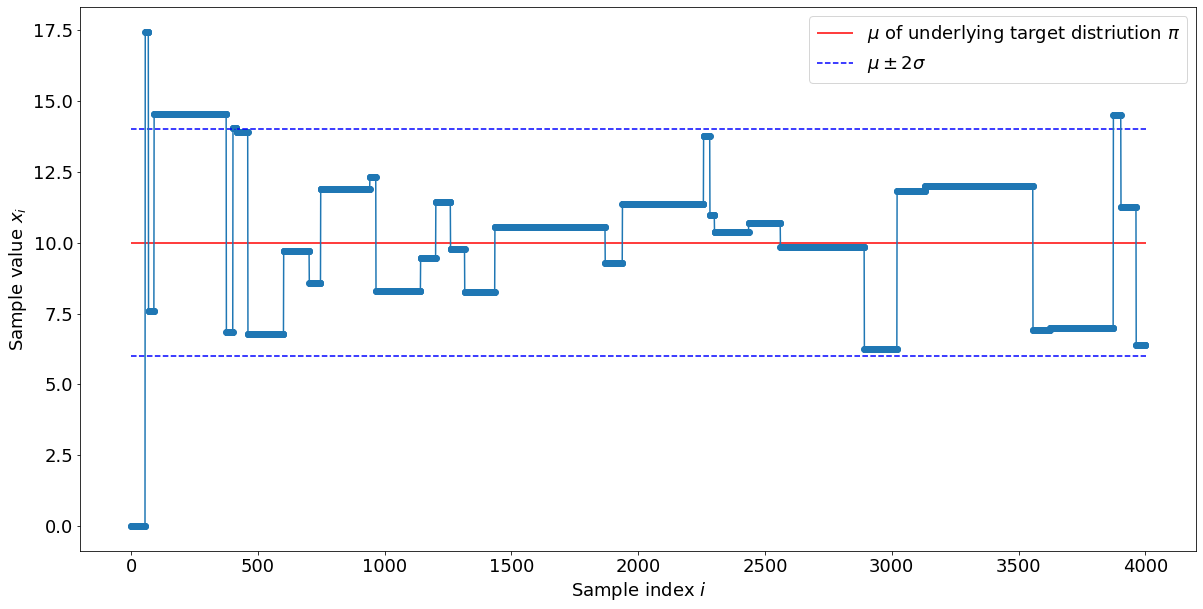

In [13]:
graph_maker_1.plot_1D_gaussian(10,2,False, "5.1.1.b")
r"Using MHA with random walk to sample from $N(\mu = 10,\sigma =2)$, when $\beta = 20.0$."


In [14]:
np.random.seed(1)

normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 0.3, pick = "random_walk")
sampler = Reversible_Sampler(N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_small, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_small)

'Using MHA with random walk to sample from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.3$.'

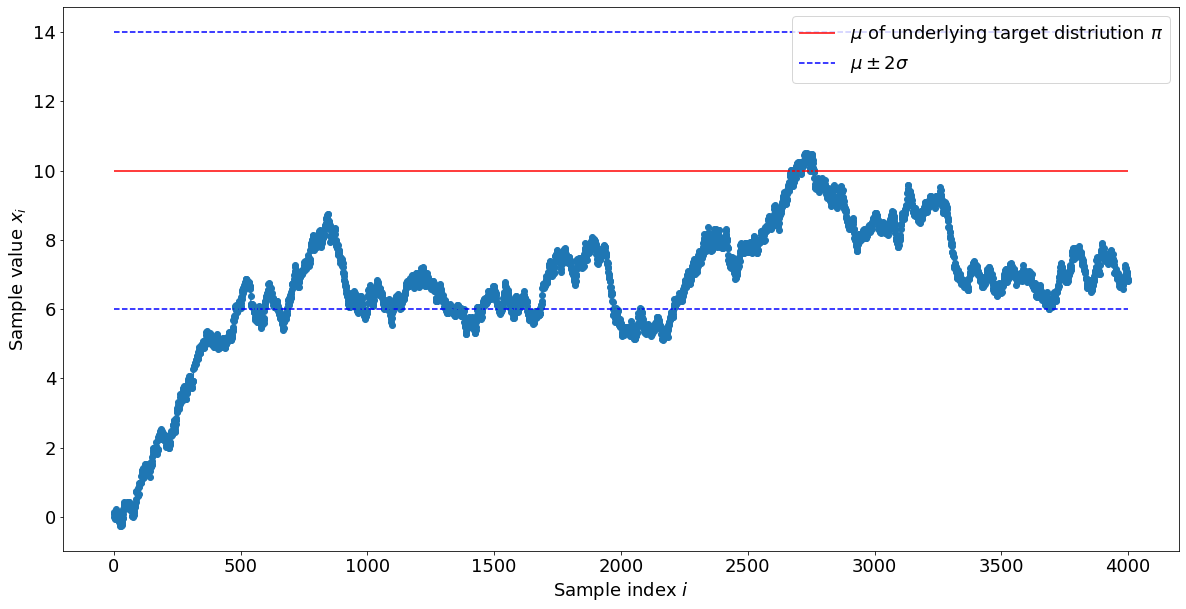

In [15]:
graph_maker.plot_1D_gaussian(10,2,False,"5.1.1.c")
r"Using MHA with random walk to sample from $N(\mu = 10,\sigma =2)$, when $\beta = 0.3$."


'Comparing Covariance $c_{\\varphi}(\\tau)$ against Lag $\\tau$, for small and large $\\beta$.'

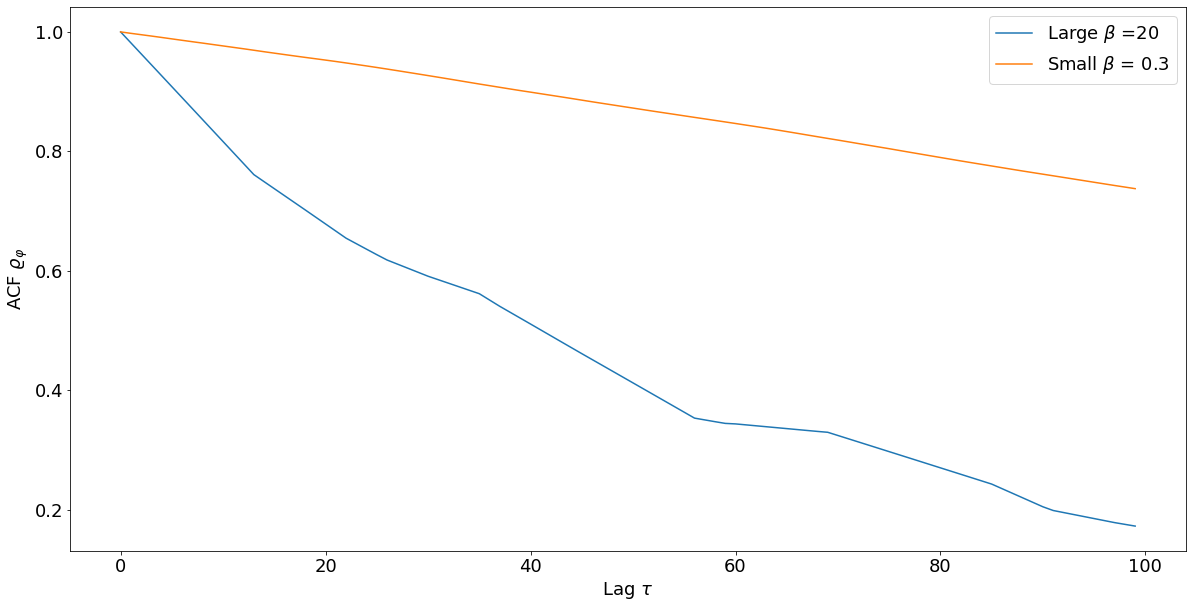

In [16]:
comparison = Compare_Covariance(samples_large,samples_small)
comparison.compare_lags(100, r"Large $\beta$ =20", r"Small $\beta$ = 0.3", "5.1.1.a")
r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$, for small and large $\beta$."


In [26]:
normal_dist = Normal_Distribution(10,2)

beta_s = [x/10 for x in range(60)]
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk")
    sampler = Reversible_Sampler(N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)


'Finding $\\beta$ value for $N(\\mu = 10,\\sigma =2)$ target distribution, using MHA.'

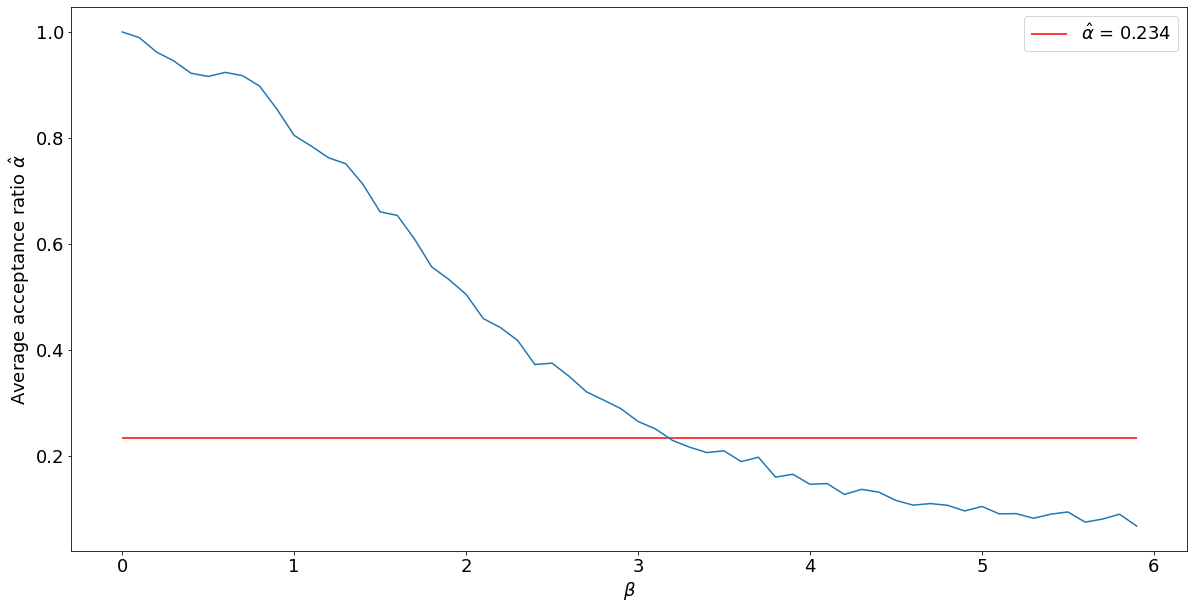

In [27]:
plot_finding_beta(beta_s, list_a_p, "5.1.1.d")
r"Finding $\beta$ value for $N(\mu = 10,\sigma =2)$ target distribution, using MHA."

In [18]:
np.random.seed(2)

normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler = Reversible_Sampler(N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_tune, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_tune)

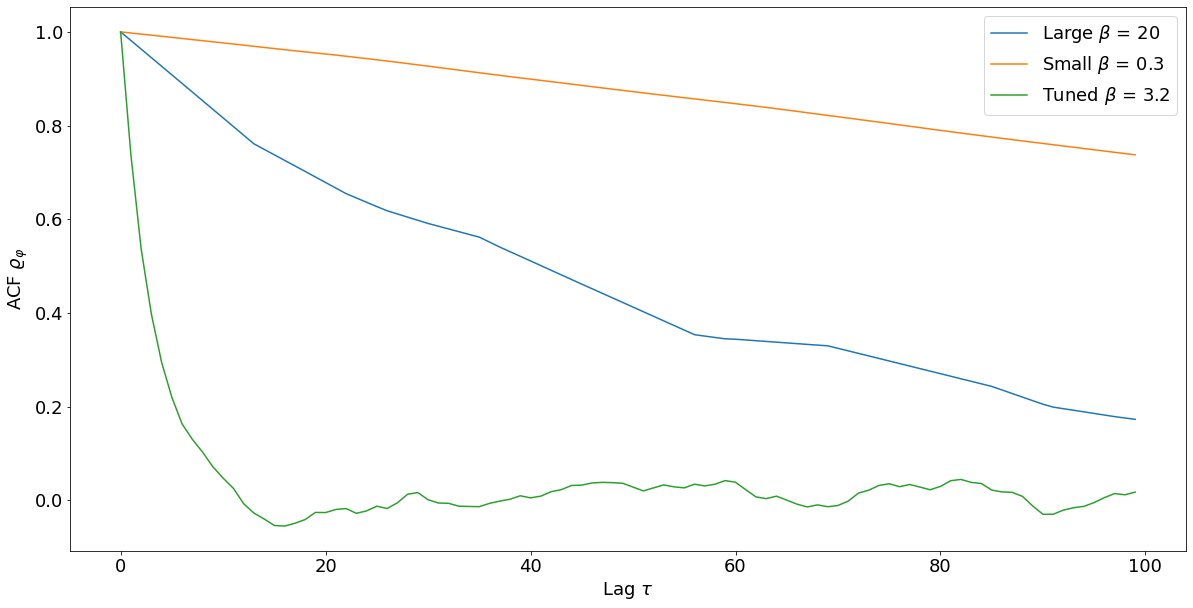

In [25]:
variance_analysis_1 = Variance_Analysis(samples_large)
variance_analysis_2 = Variance_Analysis(samples_small)
variance_analysis_3 = Variance_Analysis(samples_tune)

covariance_1 = [variance_analysis_1.c_tau(i) for i in range(100)]
covariance_2 = [variance_analysis_2.c_tau(i) for i in range(100)]
covariance_3 = [variance_analysis_3.c_tau(i) for i in range(100)]

lag = [i for i in range(100)]

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(lag, covariance_1,label = r"Large $\beta$ = 20")
plt.plot(lag, covariance_2,label = r"Small $\beta$ = 0.3")
plt.plot(lag, covariance_3,label = r"Tuned $\beta$ = 3.2")


ax.set_ylabel(r'ACF ${\varrho}_{\varphi}$')
ax.set_xlabel(r'Lag $\tau$')
ax.legend()
plt.savefig('5.1.1.f.pdf', bbox_inches = 'tight', pad_inches = 0)

'Histogram of the underlaying distribution, using MHA with tuned $\\beta = 3.2$'

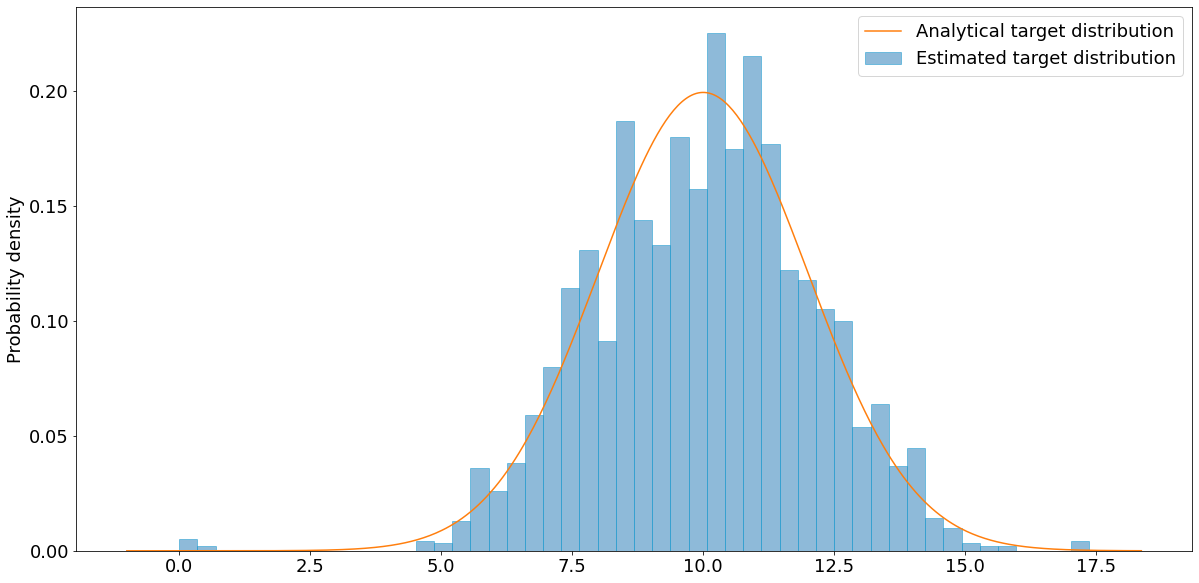

In [682]:
graph_maker.plot_histogram_gaussian(10,2, "5.1.1.e")
r"Histogram of the underlaying distribution, using MHA with tuned $\beta = 3.2$"

### 5.1.2 - Burn-in

In [17]:
np.random.seed(5)

normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 0.3, pick = "random_walk")
sampler = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_Burn_IN, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker_5_1_2 = Graph_Maker(samples_Burn_IN)

'Using MHA with random walk to sample from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.3$.'

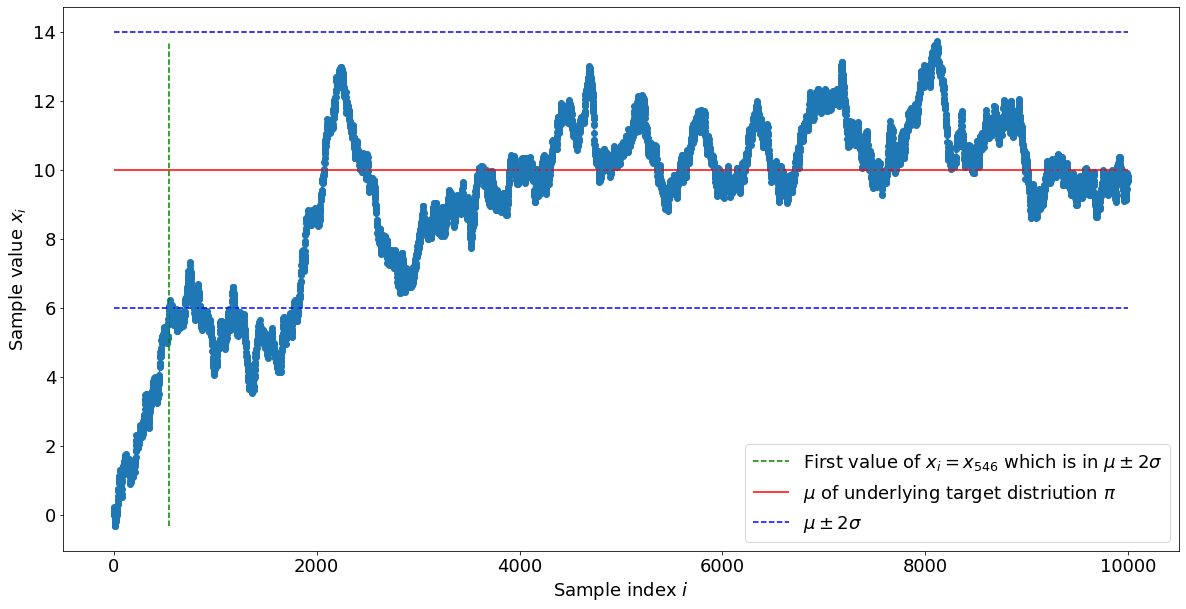

In [18]:
graph_maker_5_1_2 = Graph_Maker(samples_Burn_IN)
graph_maker_5_1_2.plot_1D_gaussian(10,2,True, "5.1.2.a")
r"Using MHA with random walk to sample from $N(\mu = 10,\sigma =2)$, when $\beta = 0.3$."

'Estimated posterior distriution from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.3$, with no burn-in.'

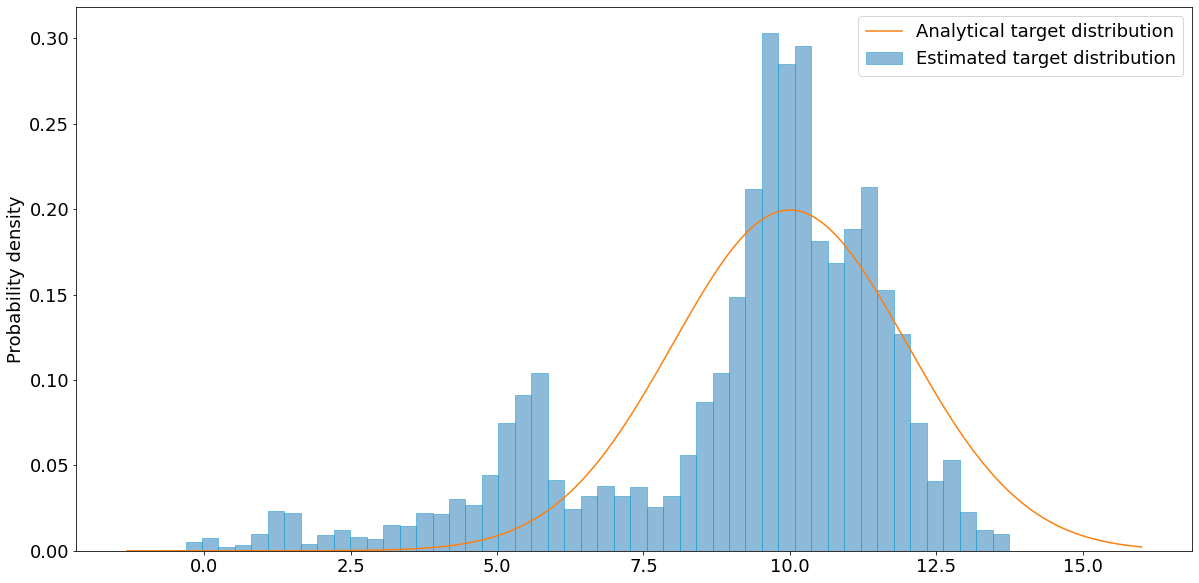

In [685]:
graph_maker_5_1_2.plot_histogram_gaussian(10,2, "5.1.2.c")
r"Estimated posterior distriution from $N(\mu = 10,\sigma =2)$, when $\beta = 0.3$, with no burn-in."

'Estimated posterior distriution from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.3$, with burn-in.'

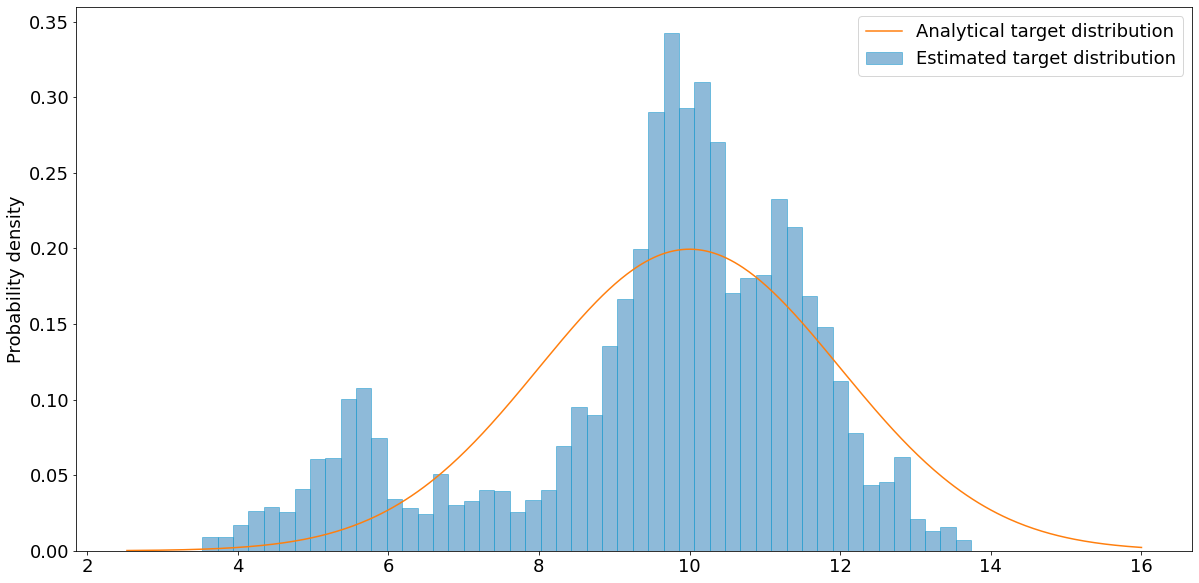

In [686]:
graph_maker_5_1_2 = Graph_Maker(samples_Burn_IN[545:])
graph_maker_5_1_2.plot_histogram_gaussian(10,2,"5.1.2.b")
r"Estimated posterior distriution from $N(\mu = 10,\sigma =2)$, when $\beta = 0.3$, with burn-in."

'Estimated posterior distriution from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.3$, by inspection.'

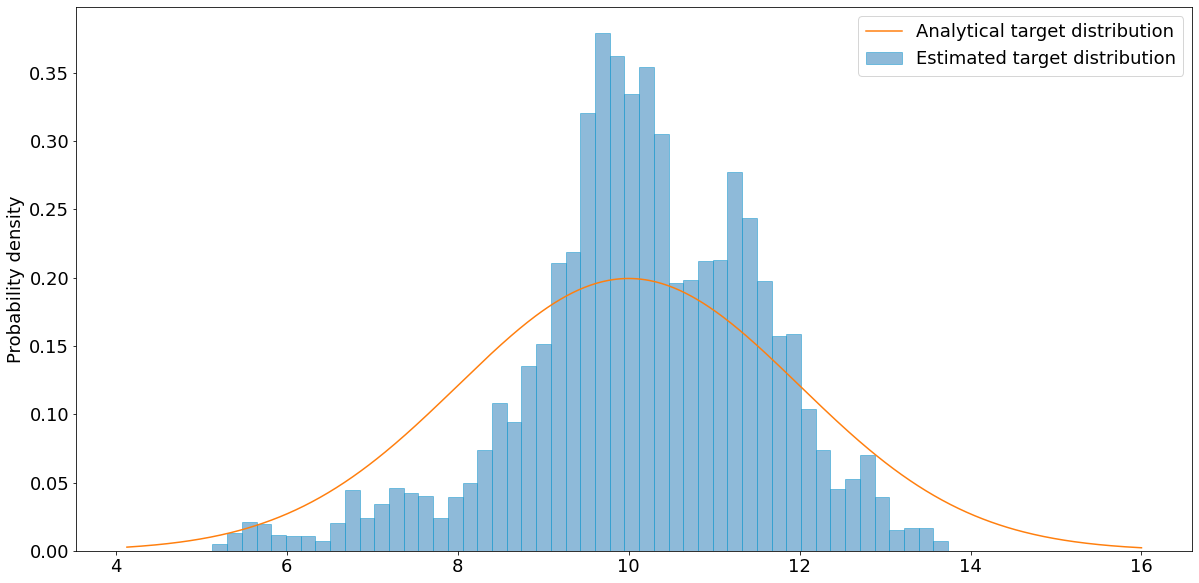

In [687]:
graph_maker_5_1_2 = Graph_Maker(samples_Burn_IN[1700:])
graph_maker_5_1_2.plot_histogram_gaussian(10,2,"5.1.2.d")
r"Estimated posterior distriution from $N(\mu = 10,\sigma =2)$, when $\beta = 0.3$, by inspection."

### 5.1.3 - Convergence

'Estimated posterior distriution from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 3.2$, and changing $N$.'

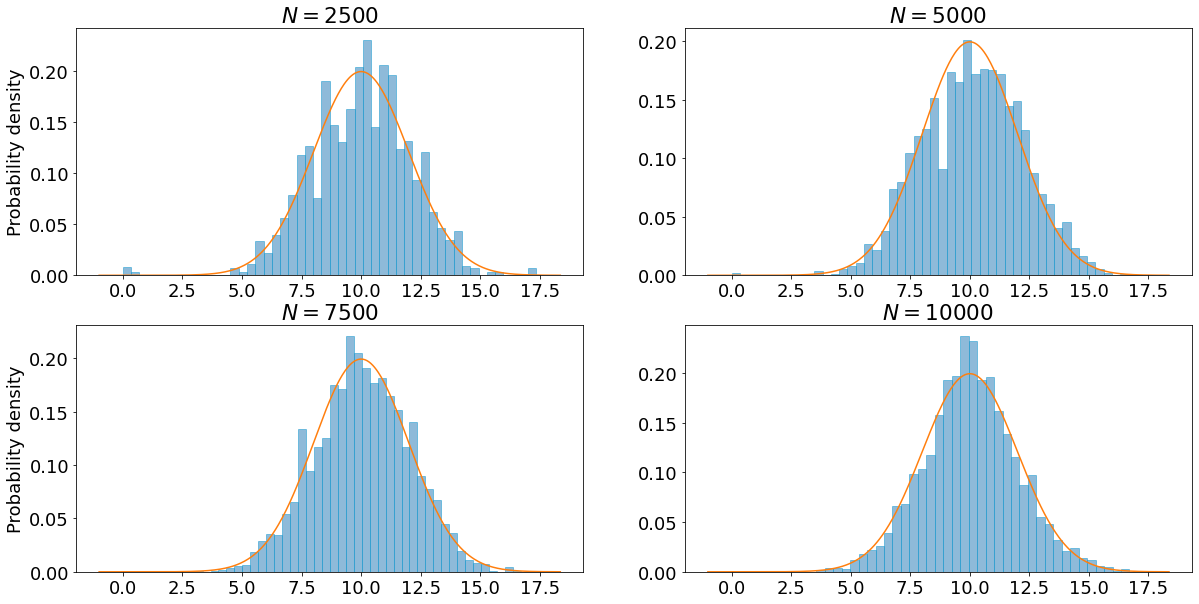

In [688]:
np.random.seed(2)
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk")

sampler = Reversible_Sampler(N = 2499, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples_tune_1, _ = sampler.Reversible_Metropolis_Hastings_Algo()

sampler = Reversible_Sampler(N = 4999, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples_tune_2, _ = sampler.Reversible_Metropolis_Hastings_Algo()

sampler = Reversible_Sampler(N = 7499, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples_tune_3, _ = sampler.Reversible_Metropolis_Hastings_Algo()

sampler = Reversible_Sampler(N = 9999, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples_tune_4, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_tune_1)
graph_maker.plot_histogram_gaussian_multiple(10,2,samples_tune_2,samples_tune_3,samples_tune_4, "5.1.3.a")
r"Estimated posterior distriution from $N(\mu = 10,\sigma =2)$, when $\beta = 3.2$, and changing $N$."
                                      

In [689]:
np.random.seed(10)
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_tune, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_tune)

'Histogram of the underlaying distribution, using MHA with tuned $\\beta = 3.2$ and N = 10000'

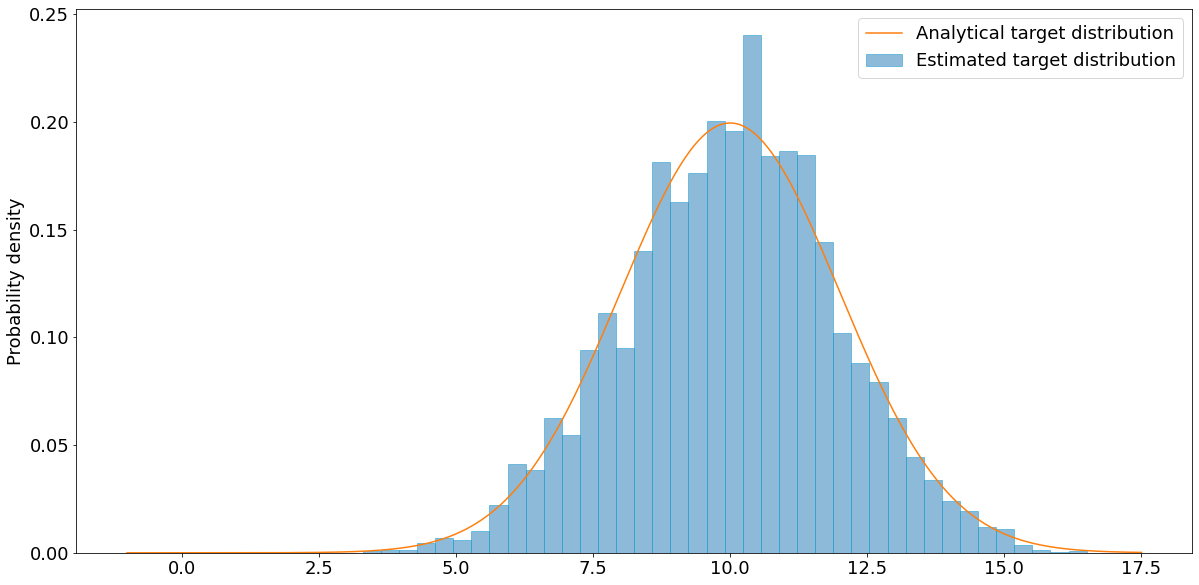

In [690]:
graph_maker.plot_histogram_gaussian(10,2, "5.1.1.1.a")
r"Histogram of the underlaying distribution, using MHA with tuned $\beta = 3.2$ and N = 10000"

### Autocorrelation

### 2a - Finding M for Autocorrelation function to see how correlated our samples. 

In [649]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk") 
sampler = Reversible_Sampler(N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples, _ = sampler.Reversible_Metropolis_Hastings_Algo()
    
M_s = range(1,len(samples))
asy_Var_M_s = []
variance_analysis = Variance_Analysis(samples)

for M in M_s:
    print(M)
    value = variance_analysis.integrated_auto_correlation_M(M)
    asy_Var_M_s.append(value)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


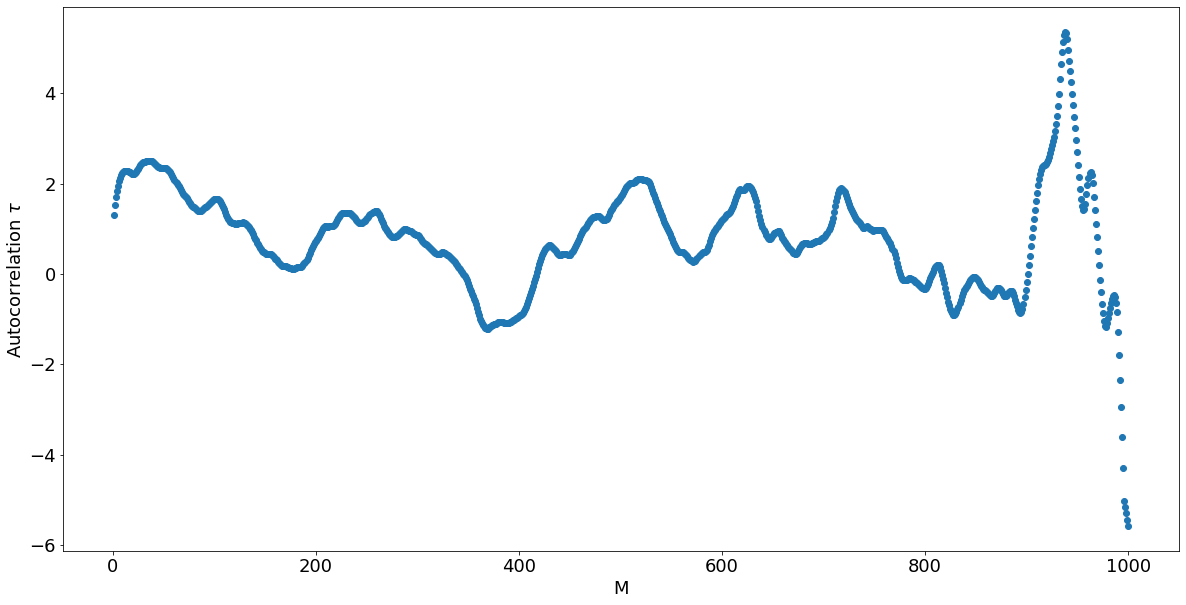

In [650]:
finding_M(M_s, asy_Var_M_s, "Finding M")

### 5.2  - Explore proposal densities (pCN and random walk) on the same problem Gaussian (10,2)

### 5.2.1

In [19]:
np.random.seed(2)
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler = Reversible_Sampler(N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_tune, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_tune)

'Using MHA with random walk to sample from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 3.2$, using Random Walk.'

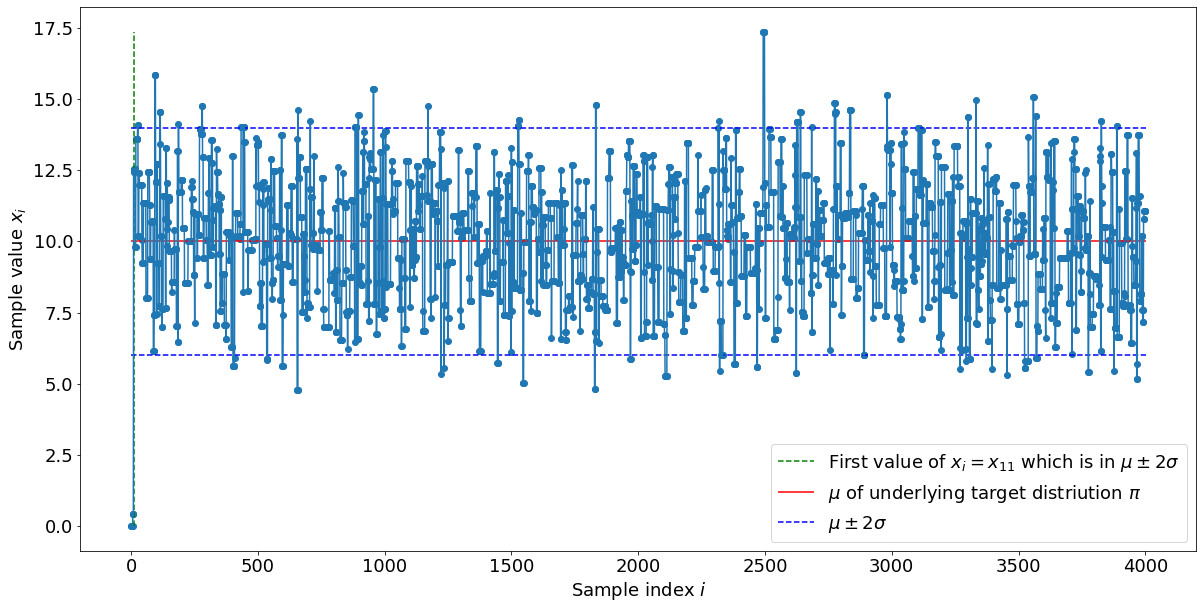

In [20]:
graph_maker.plot_1D_gaussian(10,2,True, "5.2.1.a")
r"Using MHA with random walk to sample from $N(\mu = 10,\sigma =2)$, when $\beta = 3.2$, using Random Walk."

### 5.2.2

In [18]:
np.random.seed(1)
normal_dist = Normal_Distribution(10,2)

beta_s = np.linspace(0,1,10)
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "pCN")
    sampler = Reversible_Sampler(N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)


/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


'Finding $\\beta$ value for $N(\\mu = 10,\\sigma =2)$ target distribution, using pCN proposal.'

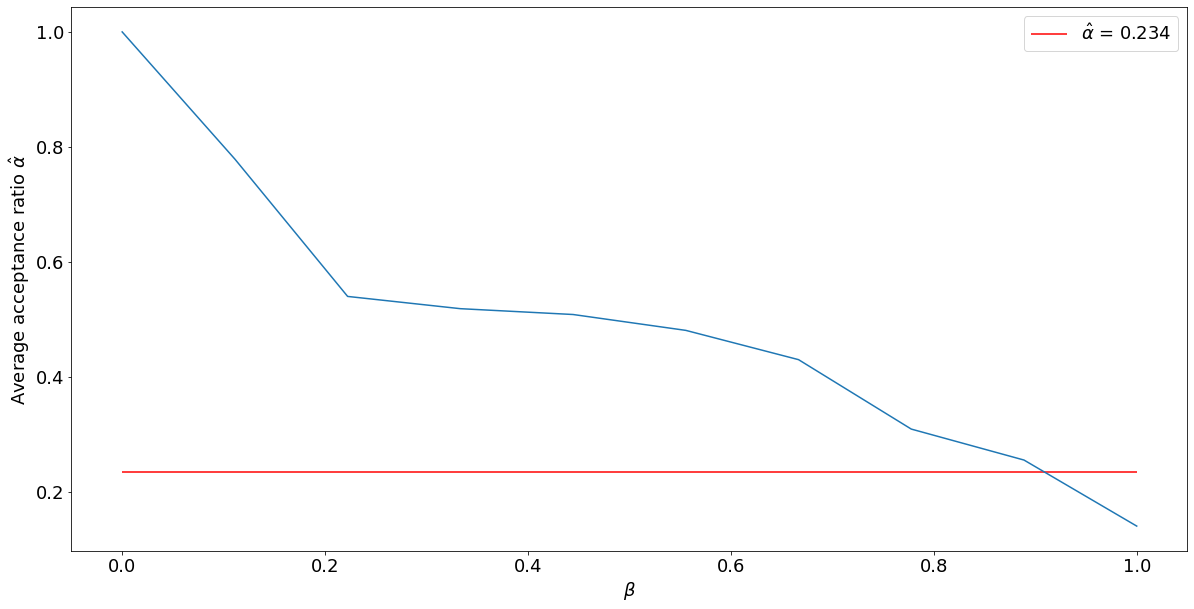

In [22]:
plot_finding_beta(beta_s, list_a_p, "5.2.2.a")
r"Finding $\beta$ value for $N(\mu = 10,\sigma =2)$ target distribution, using pCN proposal."

In [21]:
np.random.seed(1)
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 0.9, pick = "pCN")
sampler = Reversible_Sampler(N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_tune_pCN, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_tune_pCN)

'Using MHA with random walk to sample from $N(\\mu = 10,\\sigma =2)$, when $\\beta = 0.9$, using pCN proposal.'

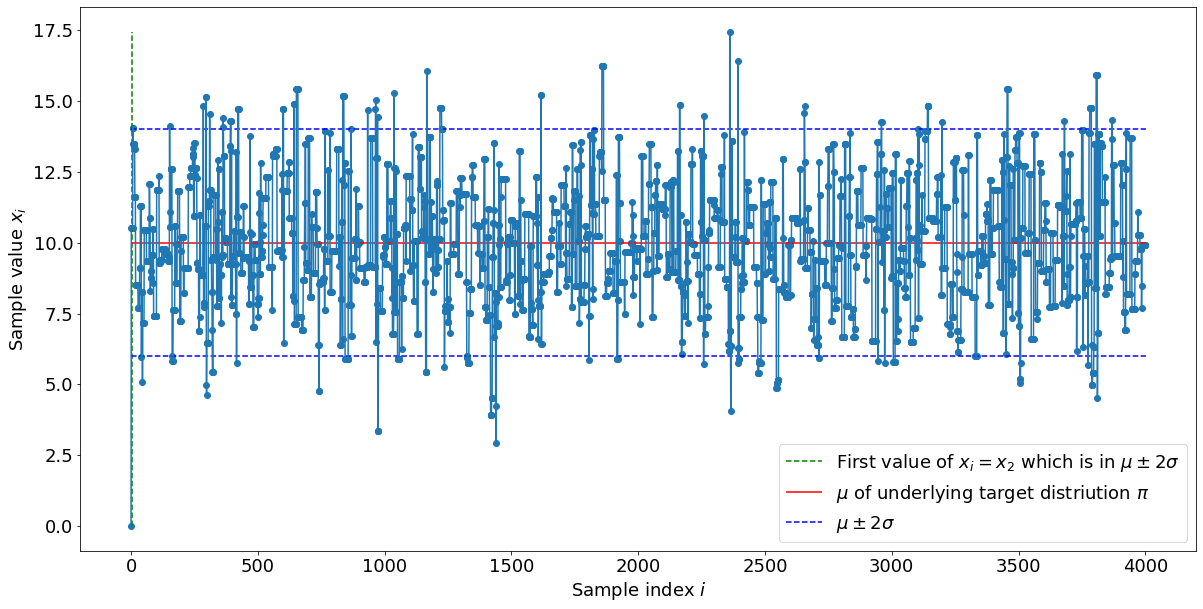

In [22]:
graph_maker.plot_1D_gaussian(10,2,True,"5.2.2.b")
r"Using MHA with random walk to sample from $N(\mu = 10,\sigma =2)$, when $\beta = 0.9$, using pCN proposal."


In [695]:
np.mean(samples_tune_pCN[1:]),np.mean(samples_tune[10:])

(9.921593457751337, 10.038663103127272)

In [696]:
(np.abs(np.mean(samples_tune_pCN[1:])-10)/10)*100, (np.abs(np.mean(samples_tune[10:])-10)/10)*100

(0.7840654224866305, 0.38663103127271725)

'Comparing Covariance $c_{\\varphi}(\\tau)$ against Lag $\\tau$, for pCN and RW.'

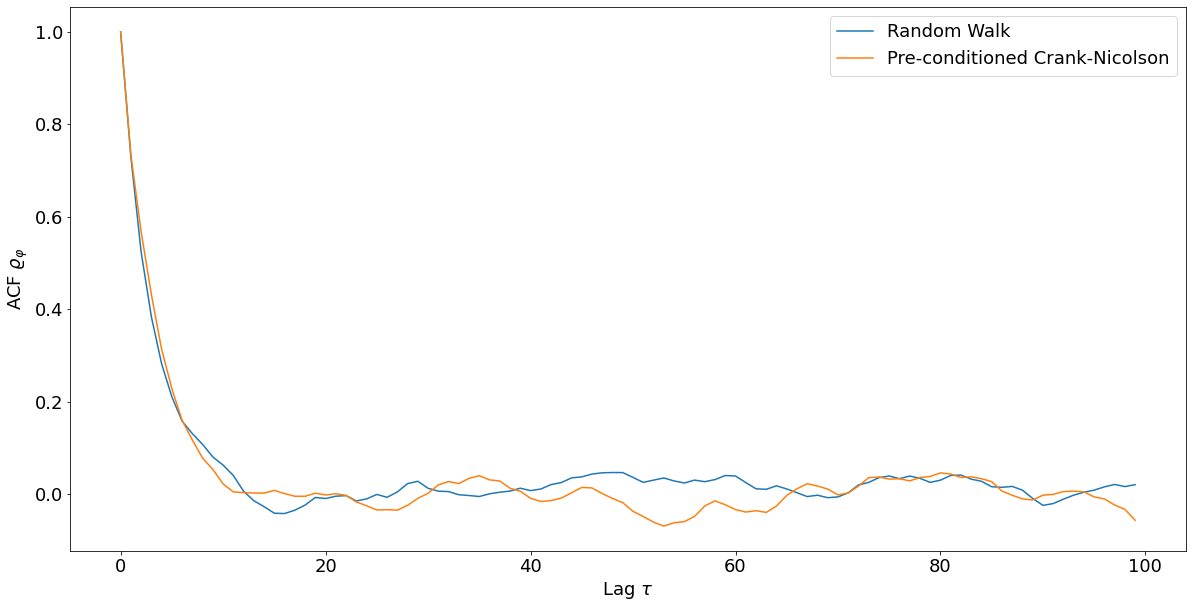

In [24]:
comparison = Compare_Covariance(samples_tune[10:],samples_tune_pCN[1:])
comparison.compare_lags(100, r"Random Walk", r"Pre-conditioned Crank-Nicolson", "5.2.2.c")
r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$, for pCN and RW."

### 5.3  -  Non-reversible sampler

In [23]:
np.random.seed(1)
normal_dist = Normal_Distribution(10,2)

b_s = np.linspace(0,1,15)
list_a_p = []

for b in b_s:
    sampler = Sampler_Non_Reversible(alpha= 1, beta = b, N = 3000, dimension = 1, target_distribution=normal_dist)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)


<ipython-input-7-722a4e61290a>:53: RuntimeWarning: divide by zero encountered in double_scalars
  gamma_distribution = stats.gamma(a=self.alpha, scale=1/self.beta)
/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-7-722a4e61290a>:65: RuntimeWarning: invalid value encountered in double_scalars
  numerator = posterior_distribution.pdf(x_prime)*gamma_distribution.pdf(x_prime - x_t)
<ipython-input-7-722a4e61290a>:68: RuntimeWarning: invalid value encountered in double_scalars
  denominator = posterior_distribution.pdf(x_t)*gamma_distribution.pdf(x_prime - x_t)


'Finding $b$ value for $N(\\mu = 10,\\sigma =2)$ target distribution, using One-Directional I-Jump.'

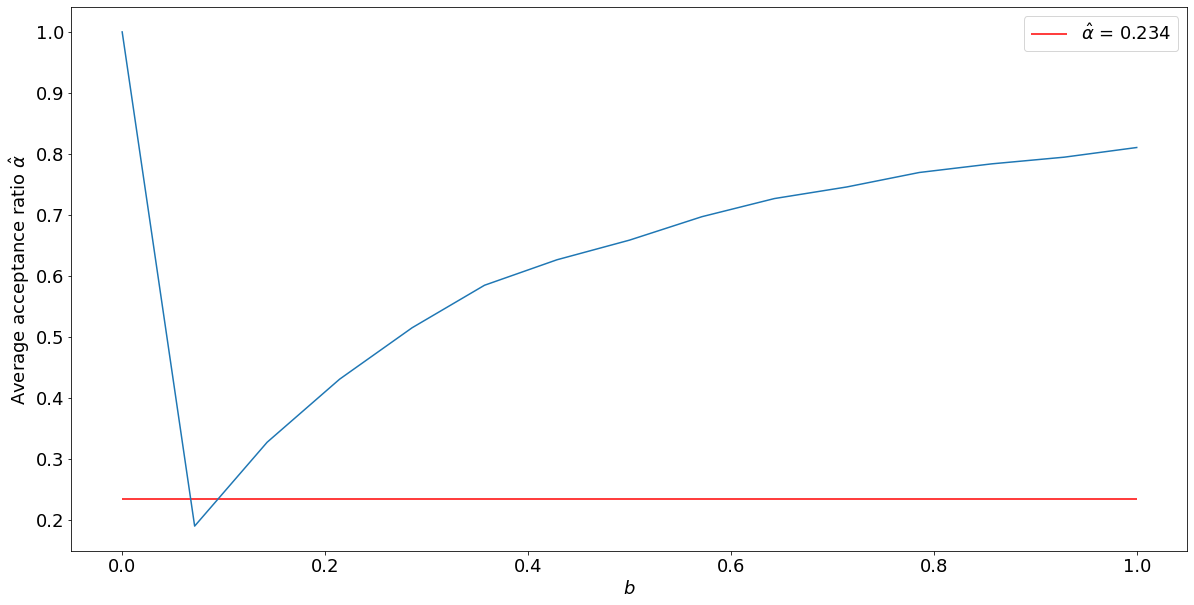

In [24]:
plot_finding_b(b_s, list_a_p, "5.3.1.a")
r"Finding $b$ value for $N(\mu = 10,\sigma =2)$ target distribution, using One-Directional I-Jump."

For both the reversible and non-reversible samplers all the test will have 4000 runs and the will use the same proposal density; random walk. The step size used will be with beta = 2.38. Therefore since we use a gamma random variable when we use non-reversible samplers we need to find the equivalent alpha and beta values such that the step size is equal the step size of a normal distribution when using beta = 2.38.http://abacus.gene.ucl.ac.uk/ziheng/pdf/2018ThawornwattanaBA.pdf

To caluculate this we need to note that the step size will not be the mean of a normal distrbution since in this case it would be simply equal to zero. However we need to take into account the value for the absolute step size instead. One can use to calcuate this the folded-normal distribution.

Mean = $${\displaystyle \mu _{Y}={\sqrt {\frac {2}{\pi }}}\sigma e^{-{\frac {\mu ^{2}}{2\sigma ^{2}}}}+\mu \left[1-2\Phi \left(-{\frac {\mu }{\sigma }}\right)\right]}$$

Where mu is the mean of the underlying normal distiburion in our case 0, and sigma the standard deviartion which in our case is beta. So we can reduce the mean to:

$${\displaystyle \mu _{Y}={\sqrt {\frac {2}{\pi }}}\sigma}$$

Which is equal to:

In [229]:
np.sqrt(2/np.pi)*3.2

2.5532305945691696

Therefore we need to tune our parameters alpha and beta to get the same value. The expected value of a gamma distribution is: alpha/beta

So we need to be : alpha/beta = 1.8989652547108196, we can let alpha = 1 and then beta we can let it be equal to 1/np.sqrt(2/np.pi)*2.38.

In [230]:
beta_R = 2.38
beta_Non_R = 1/(np.sqrt(2/np.pi)*3.2)
beta_Non_R 

0.3916606679110938

In [231]:
1/0.6

1.6666666666666667

In [26]:
np.random.seed(1)

normal_dist = Normal_Distribution(10,2)


sampler_1 = Sampler_Non_Reversible(alpha = 1, beta = 0.13, N = 4000, dimension = 1, target_distribution=normal_dist)
samples_1, _ = sampler_1.Non_Reversible_Metropolis_Hastings_Algo()

sampler_2 = Sampler_Non_Reversible(alpha = 1, beta = 0.4, N = 4000, dimension = 1, target_distribution=normal_dist)
samples_2, _ = sampler_2.Non_Reversible_Metropolis_Hastings_Algo()

sampler_3 = Sampler_Non_Reversible(alpha = 1, beta = 0.6, N = 4000, dimension = 1, target_distribution=normal_dist)
samples_3, _ = sampler_3.Non_Reversible_Metropolis_Hastings_Algo()

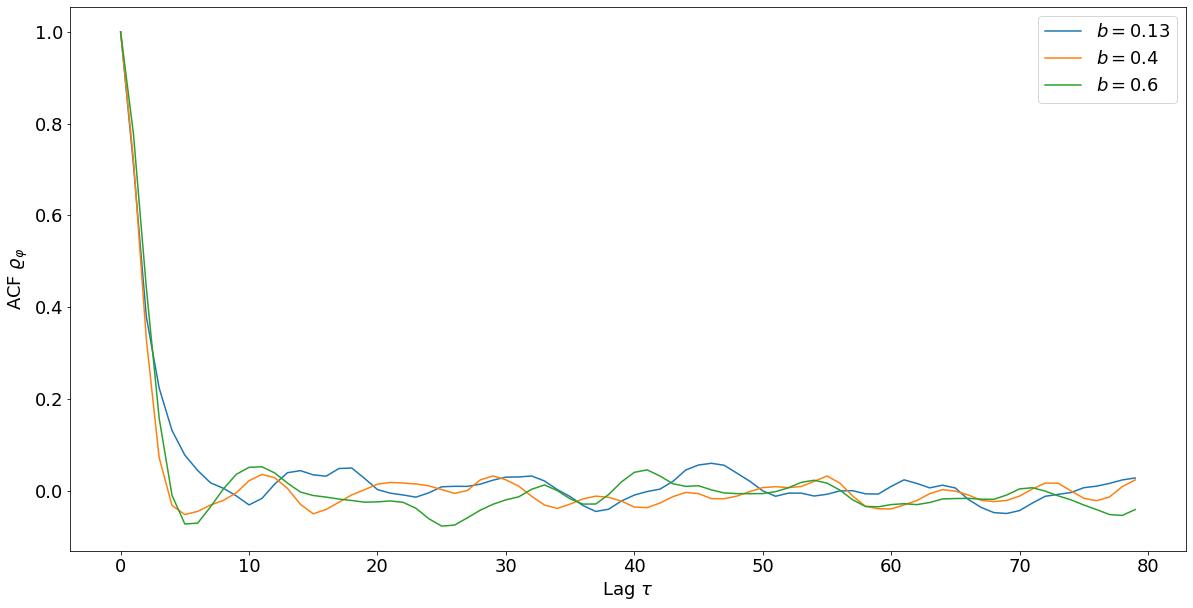

In [29]:
variance_analysis_1 = Variance_Analysis(samples_1)
variance_analysis_2 = Variance_Analysis(samples_2)
variance_analysis_3 = Variance_Analysis(samples_3)

covariance_1 = [variance_analysis_1.c_tau(i) for i in range(80)]
covariance_2 = [variance_analysis_2.c_tau(i) for i in range(80)]
covariance_3 = [variance_analysis_3.c_tau(i) for i in range(80)]

lag = [i for i in range(80)]

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(lag, covariance_1,label = r"$b = 0.13$")
plt.plot(lag, covariance_2,label = r"$b = 0.4$")
plt.plot(lag, covariance_3,label = r"$b = 0.6$")


ax.set_ylabel(r'ACF ${\varrho}_{\varphi}$')
ax.set_xlabel(r'Lag $\tau$')
#ax.set_title(r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$ for different $\beta$ values, using One-Directional I-Jump.")
ax.legend()
plt.savefig('5.3.1.b.pdf', bbox_inches = 'tight', pad_inches = 0)

'Comparing Covariance $c_{\\varphi}(\\tau)$ against Lag $\\tau$, for MHA and One Directional I-Jump.'

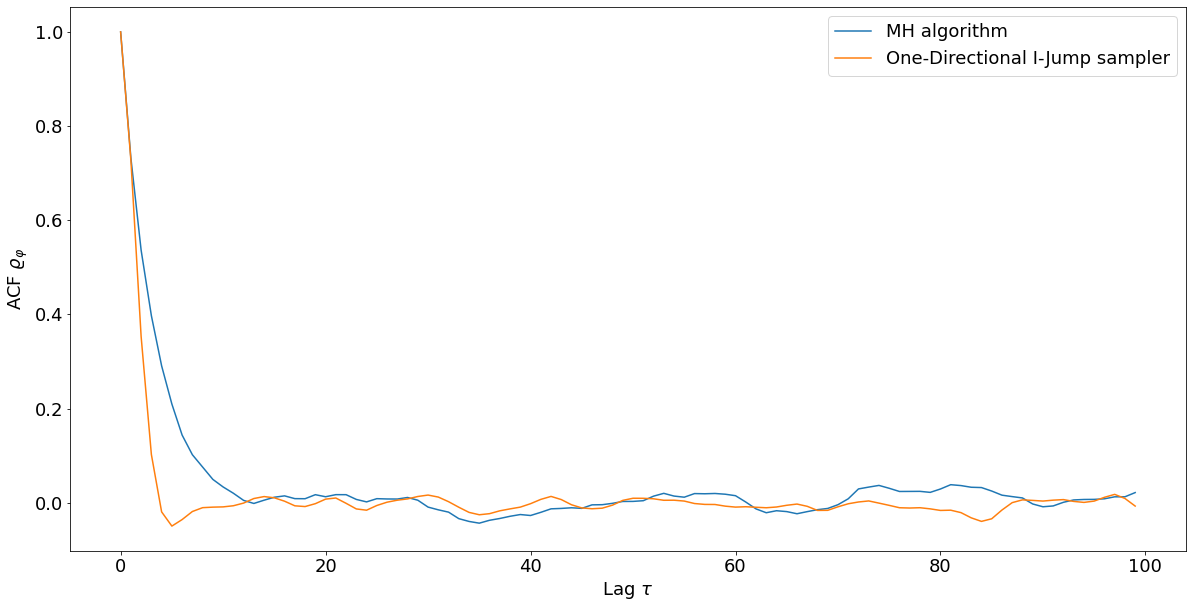

In [45]:
np.random.seed(2)

normal_dist = Normal_Distribution(10,2)

proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples_reversible, _ = sampler.Reversible_Metropolis_Hastings_Algo()

sampler_2 = Sampler_Non_Reversible(alpha = 1, beta = 0.4, N = 10000, dimension = 1, target_distribution=normal_dist)
samples_non_reversible, _ = sampler_2.Non_Reversible_Metropolis_Hastings_Algo()

comparison = Compare_Covariance(samples_reversible,samples_non_reversible)
comparison.compare_lags(100, r"MH algorithm", r"One-Directional I-Jump sampler", "5.3.2.a")
r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$, for MHA and One Directional I-Jump."

In [698]:
np.random.seed(2)

normal_dist = Normal_Distribution(10,2)
sampler = Sampler_Non_Reversible(alpha= 1, beta = 0.4 , N = 10000, dimension = 1, target_distribution=normal_dist)
samples_non_reversible, b = sampler.Non_Reversible_Metropolis_Hastings_Algo()

'Estimated posterior distriution from $N(\\mu = 10,\\sigma =2)$, using One-Directional I-Jump when $a = 1$, $b = 0.4$ and N = 10000.'

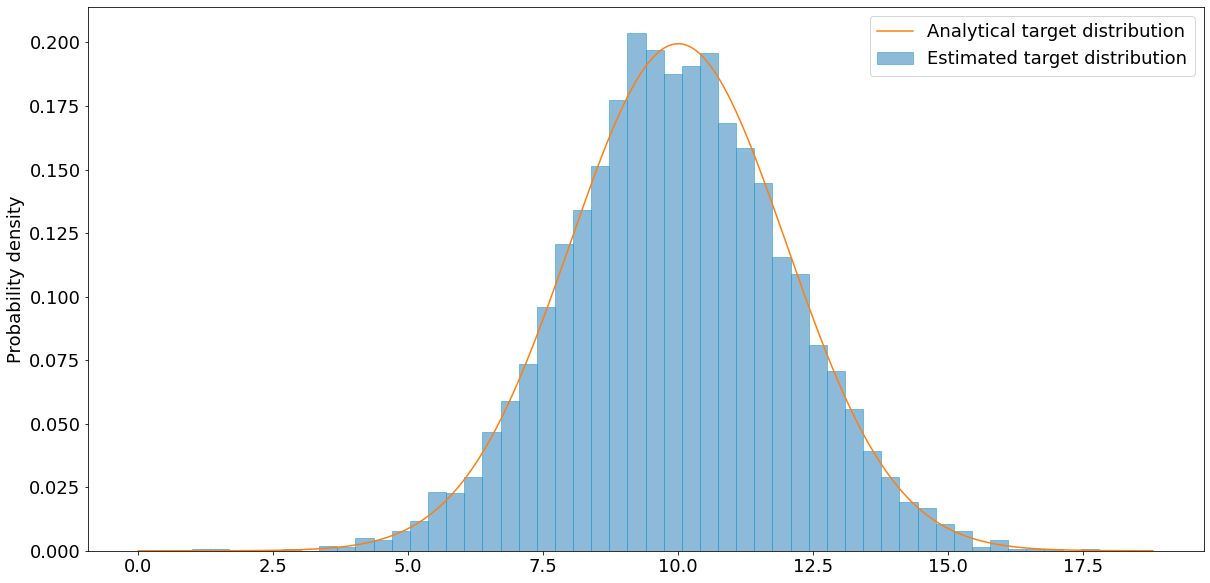

In [699]:
graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_histogram_gaussian(10, 2, "5.3.1.c")
r"Estimated posterior distriution from $N(\mu = 10,\sigma =2)$, using One-Directional I-Jump when $a = 1$, $b = 0.4$ and N = 10000."

### 5.4 - Comparing Reversible vs Non-Reversible samplers on  a range of functions: Gaussian, Mixture Gaussians, Log Normal Distribution, 

#### 5.4.1 Log Normal Distribution

##### 5.4.1 Log Normal Distribution - Reverisble

In [243]:
np.random.seed(1)
log_normal = Log_Normal_Distribution(0,1)

beta_s = [x/10 for x in range(60)]
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk")
    sampler = Reversible_Sampler(N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


KeyboardInterrupt: 

In [ ]:
finding_beta(beta_s, list_a_p, r"Finding $\beta$ value for LogNormal(0,0.5) target distribution, using MHA.")

In [25]:
np.random.seed(2)

log_normal = Log_Normal_Distribution(0,1)
proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler_log_normal = Reversible_Sampler(N = 5000, dimension = 1, target_distribution=log_normal, proposal=proposal)

samples_reversible, _ = sampler_log_normal.Reversible_Metropolis_Hastings_Algo()

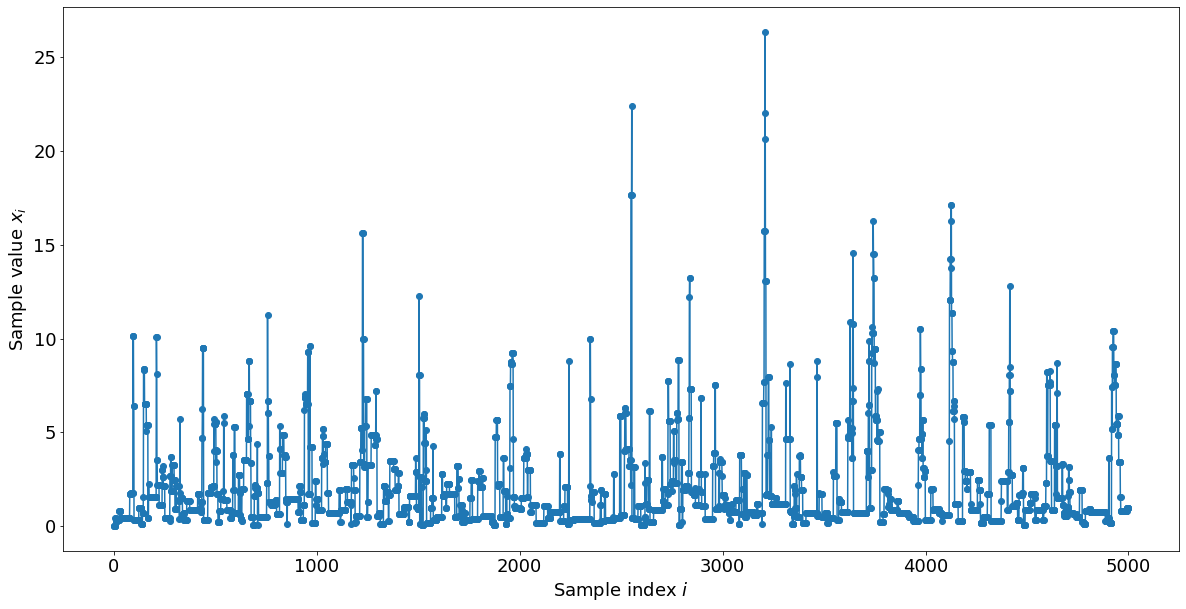

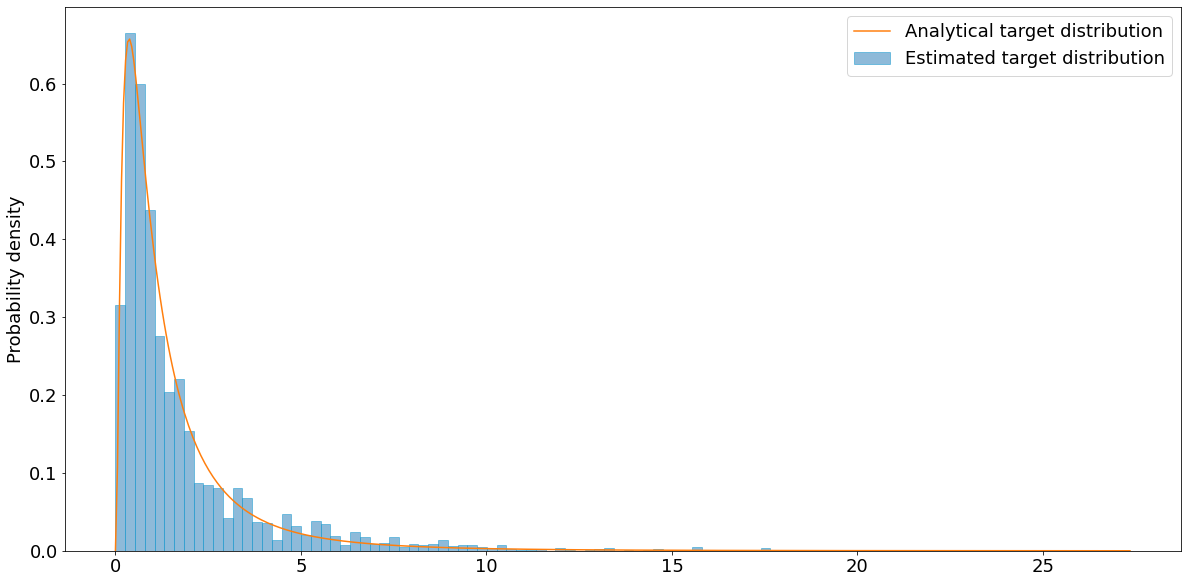

In [26]:
graph_maker = Graph_Maker(samples_reversible)
r"Samples from a $LogNormal(0,1)$ using MHA with $\beta = 3.2$"
a = graph_maker.plot_samples("5.4.1.a")
r"Estimated posterior distriution from $LogNormal(0,1)$, using MHA when $\beta = 3.2$ and N = 10000."
b = graph_maker.plot_histogram_log(0, 1, "5.4.1.b")


##### 5.4.1 Log Normal Distribution - Non Reverisble

In [47]:
np.random.seed(1)
log_normal = Log_Normal_Distribution(0,1)

b_s = np.linspace(0,1,60)
list_a_p = []

for b in b_s:
    sampler = Sampler_Non_Reversible(alpha= 1, beta = b, N = 1000, dimension = 1, target_distribution=log_normal)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

<ipython-input-5-57e61e975287>:30: RuntimeWarning: divide by zero encountered in double_scalars
  gamma_distribution = stats.gamma(a=alpha, scale=1/beta)
/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-5-57e61e975287>:42: RuntimeWarning: invalid value encountered in double_scalars
  numerator = posterior_distribution.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)
<ipython-input-5-57e61e975287>:45: RuntimeWarning: invalid value encountered in double_scalars
  denominator = posterior_distribution.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)


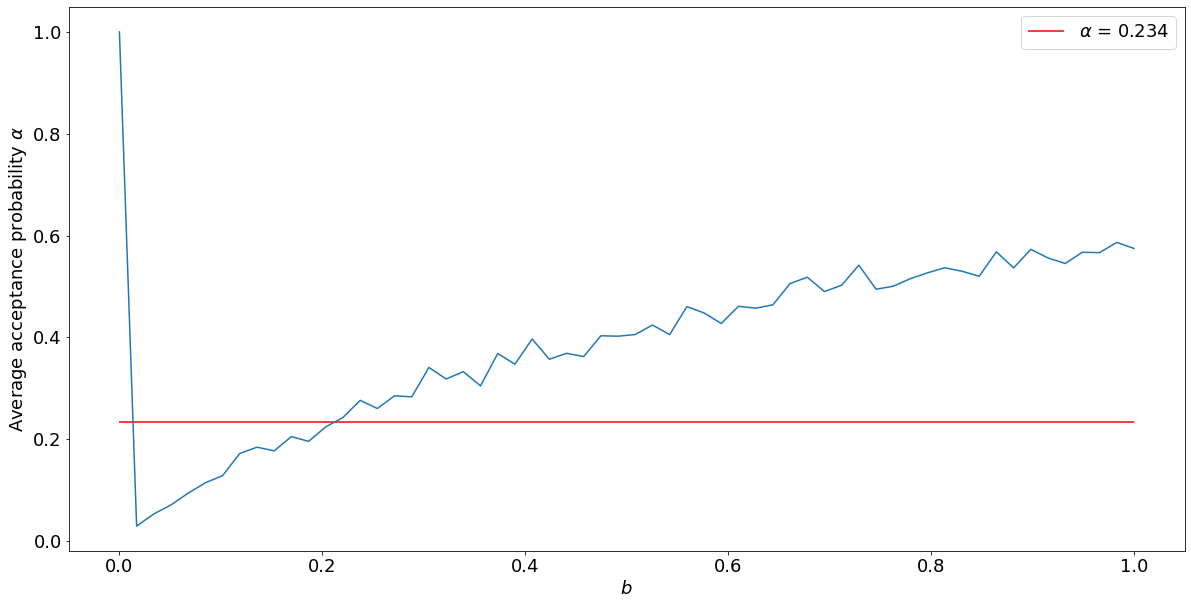

In [48]:
finding_b(b_s, list_a_p, r"Finding $\beta$ value for LogNormal(0,1) target distribution, using One Directional I-Jump Sampler.")

In [27]:
np.random.seed(2)
log_normal = Log_Normal_Distribution(0,1)
sampler_log_normal = Sampler_Non_Reversible(alpha = 1, beta = 0.2, N = 5000, dimension = 1, target_distribution=log_normal)

samples_non_reversible, _ = sampler_log_normal.Non_Reversible_Metropolis_Hastings_Algo()

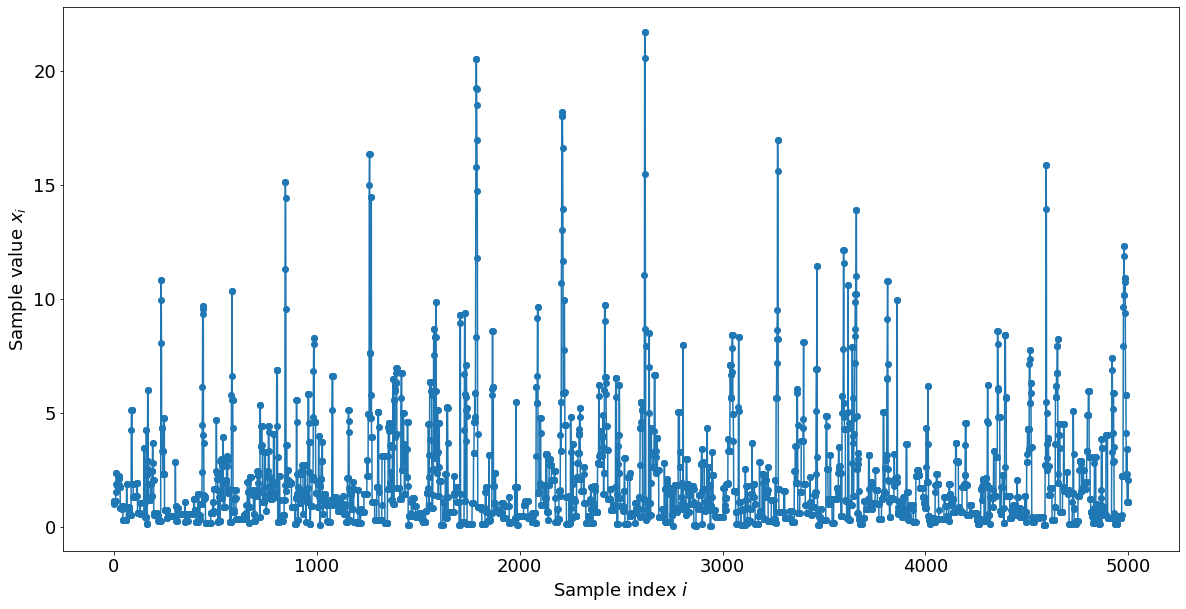

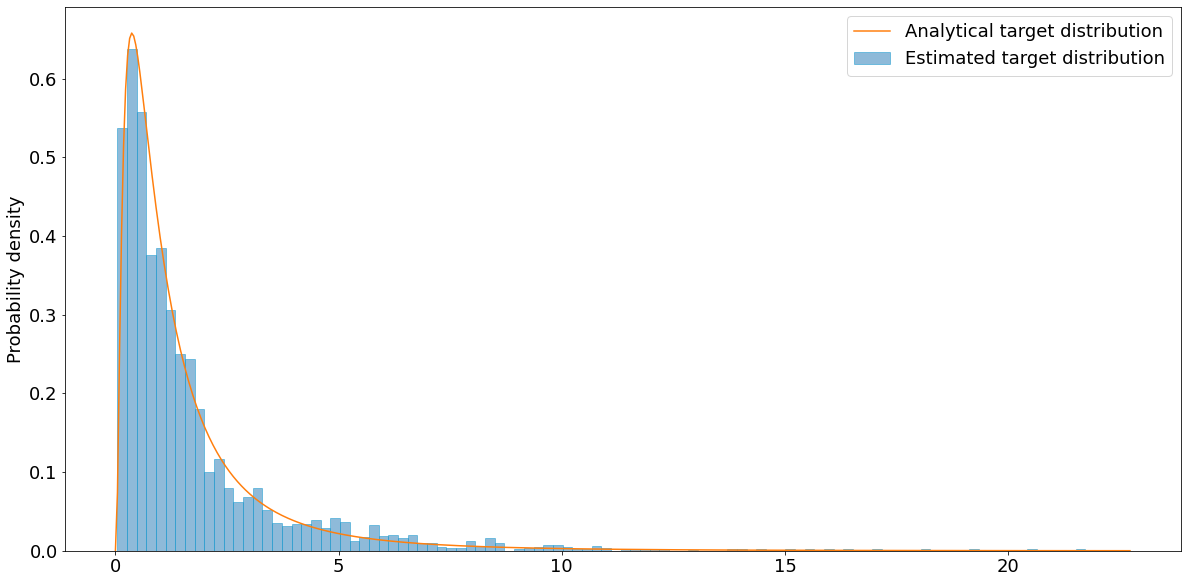

In [28]:
graph_maker = Graph_Maker(samples_non_reversible)
"Samples from a $LogNormal(0,1)$ using One Directional I-Jump Sampler."
graph_maker.plot_samples("5.4.1.c")
r"Estimated posterior distriution from $LogNormal(0,1)$, using One Directional I-Jump Sampler when $a = 1$, $b=0.4$ and N = 10000."
graph_maker.plot_histogram_log(0, 1, "5.4.1.d")


#### 5.4.1 Log Normal Distribution - Comparison

('One-Directional I-Jump',
 'Comparing Covariance $c_{\\varphi}(\\tau)$ against Lag $\\tau$, for MHA and One Directional I-Jump on LogNormal(0,1) posterior distribution.')

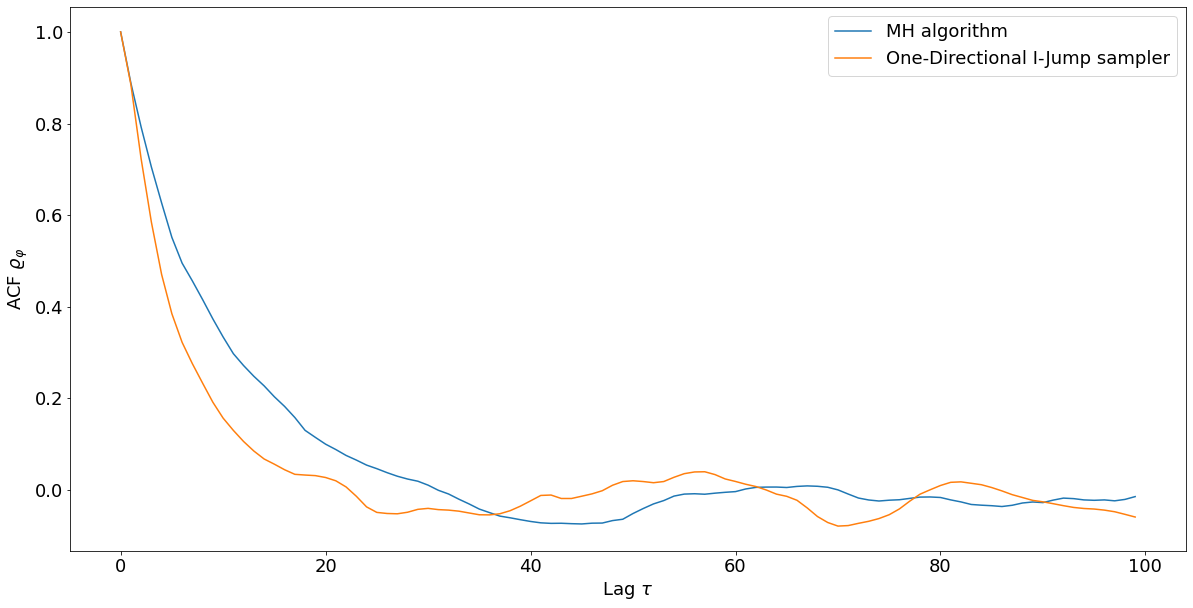

In [29]:
comparison = Compare_Covariance(samples_reversible,samples_non_reversible)
comparison.compare_lags(100, r"MH algorithm", "One-Directional I-Jump sampler", "5.4.1.e")
r"One-Directional I-Jump", r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$, for MHA and One Directional I-Jump on LogNormal(0,1) posterior distribution."                         

#### 5.4.1 Log Normal Distribution - Small step size issue

In [35]:
np.random.seed(2)

log_normal = Log_Normal_Distribution(0,1)
proposal = Proposal(beta = 0.5, pick = "random_walk")
sampler_log_normal = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=log_normal, proposal=proposal)

samples_reversible, _ = sampler_log_normal.Reversible_Metropolis_Hastings_Algo()

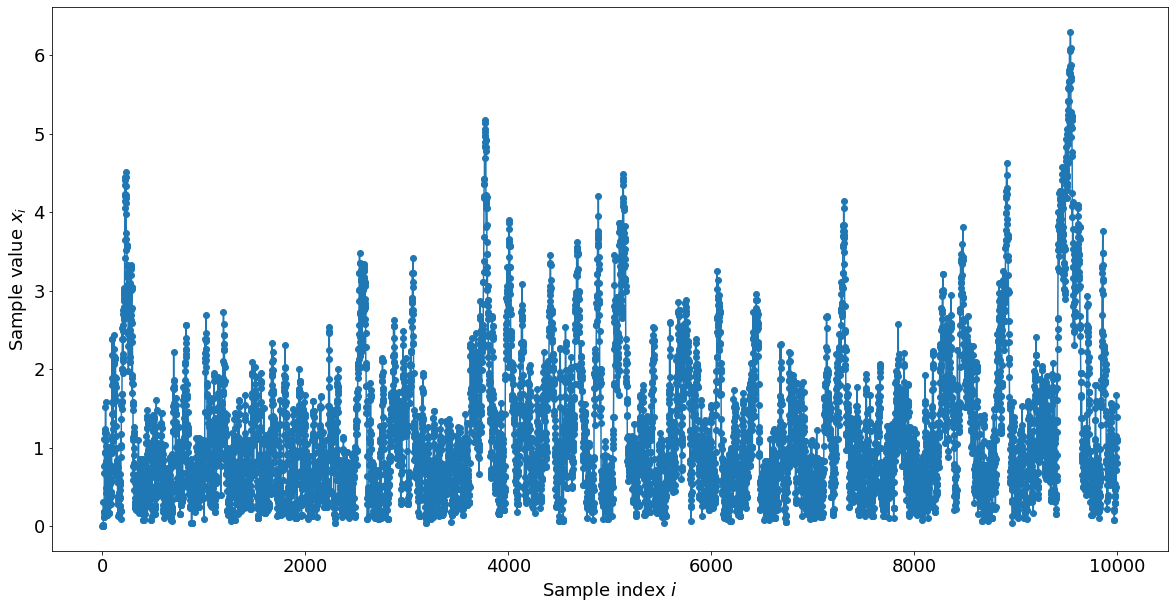

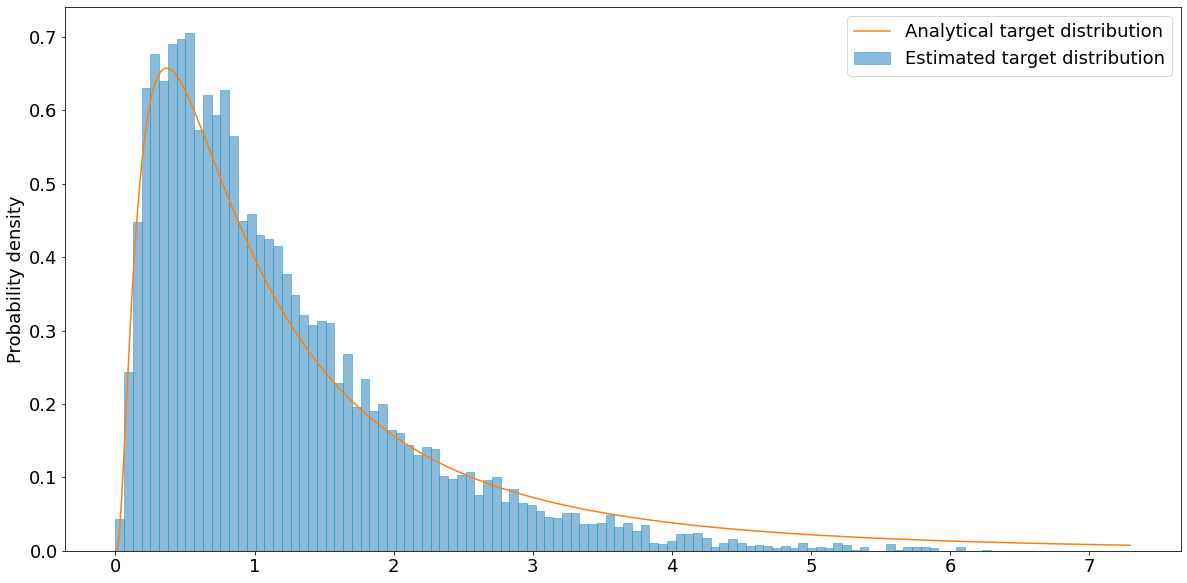

In [36]:
graph_maker = Graph_Maker(samples_reversible)
r"Samples from a $LogNormal(0,1)$ using MHA with $\beta = 0.5$"
graph_maker.plot_samples("5.4.1.f")
r"Estimated posterior distriution from $LogNormal(0,1)$, using MHA when $\beta = 0.5$ and N = 10000."
graph_maker.plot_histogram_log(0, 1, "5.4.1.g")


#### 5.4.2 Gaussian Mixtures

##### 5.4.2 Gaussian Mixtures - Reverisble

In [ ]:
np.random.seed(1)

pi_1 = stats.norm([10],[1])
pi_2 = stats.norm([-10],[1])

gaussian_mix = Gaussian_Mixture([pi_1,pi_2])

beta_s = [x/10 for x in range(60)]
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk")
    sampler = Reversible_Sampler(N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

In [ ]:
finding_beta(beta_s, list_a_p, r"Finding $\beta$ value for Gaussian Mixture Model target distribution, using MHA.")

In [19]:
pi_1 = stats.norm([-10],[1])
pi_2 = stats.norm([10],[1])

In [20]:
np.random.seed(1)

gaussian_mix = Gaussian_Mixture([pi_1,pi_2])
proposal = Proposal(beta = 3.2, pick = "random_walk")
sampler_gaussian_mix = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=gaussian_mix, proposal=proposal)

samples_reversible, _ = sampler_gaussian_mix.Reversible_Metropolis_Hastings_Algo()

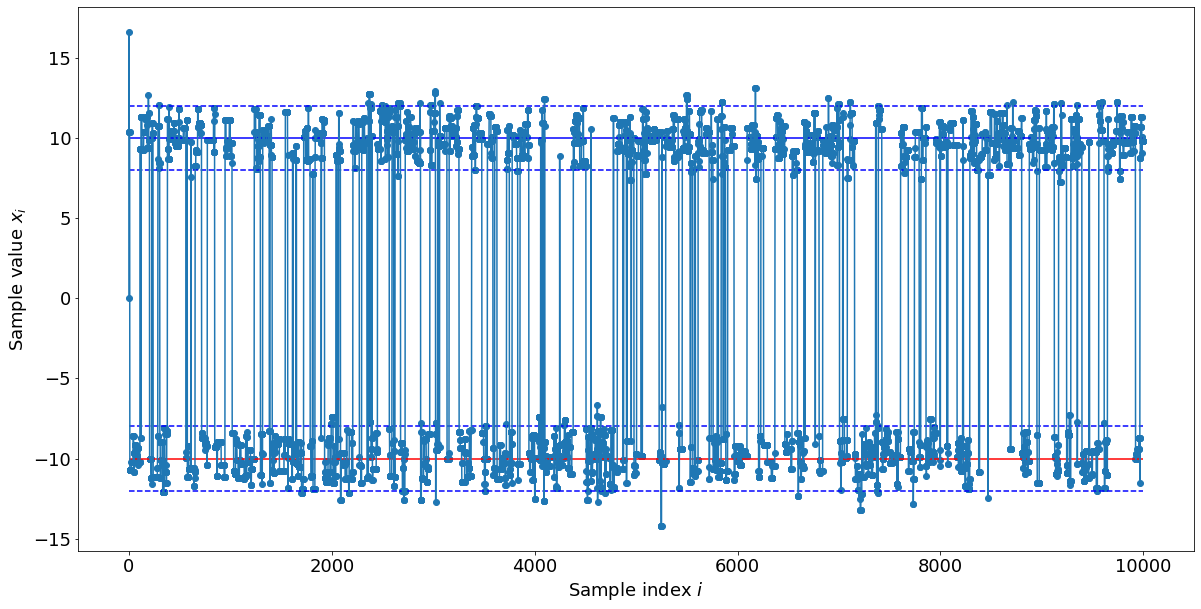

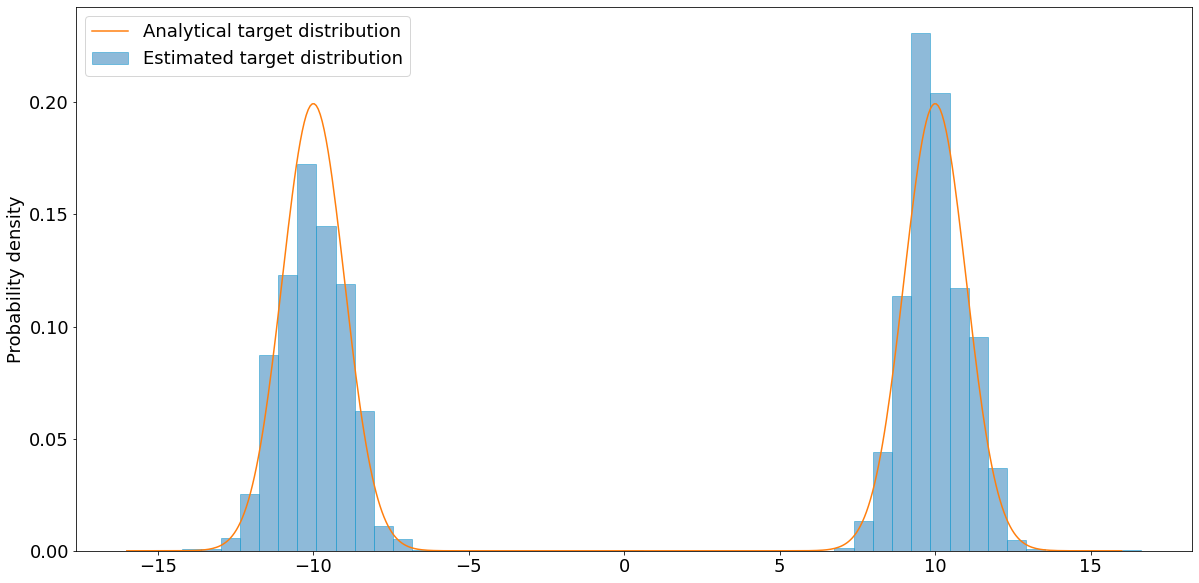

In [21]:
graph_maker = Graph_Maker(samples_reversible)
r"Samples from a Gaussian Mixture Model using MHA with $\beta = 3.2$."
graph_maker.plot_gaussian_mixture_models([-10,10], [1,1],"5.4.2.a")
r"Estimated posterior distriution from Gaussian Mixture Model, using MHA when $\beta = 3.2$ and N = 10000."
graph_maker.plot_histogram_mix([pi_1,pi_2], "5.4.2.b")


##### 5.4.2 Gaussian Mixtures - Non Reverisble

In [398]:
np.random.seed(1)

pi_1 = stats.norm([-10],[1])
pi_2 = stats.norm([10],[1])

gaussian_mix = Gaussian_Mixture([pi_1,pi_2])

b_s = np.linspace(0,1,60)
list_a_p = []

for b in b_s:
    sampler = Sampler_Non_Reversible(alpha= 1, beta = b, N = 1000, dimension = 1, target_distribution=gaussian_mix)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

<ipython-input-347-57e61e975287>:30: RuntimeWarning: divide by zero encountered in double_scalars
  gamma_distribution = stats.gamma(a=alpha, scale=1/beta)
/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-347-57e61e975287>:42: RuntimeWarning: invalid value encountered in double_scalars
  numerator = posterior_distribution.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)
<ipython-input-347-57e61e975287>:45: RuntimeWarning: invalid value encountered in double_scalars
  denominator = posterior_distribution.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)


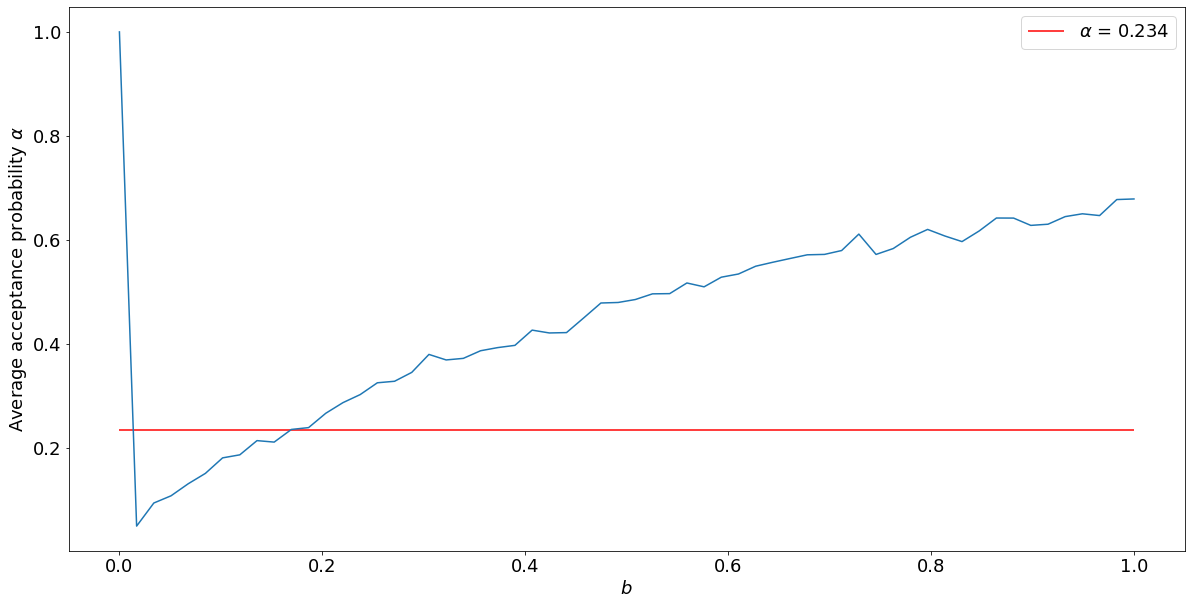

In [399]:
finding_b(b_s, list_a_p, r"Finding $\beta$ value for LogNormal(0,0.5) target distribution, using One Directional I-Jump Sampler.")

In [22]:
np.random.seed(1)

pi_1 = stats.norm([-10],[1])
pi_2 = stats.norm([10],[1])

gaussian_mix = Gaussian_Mixture([pi_1,pi_2])
sampler_gaussian_mix_n_r = Sampler_Non_Reversible(alpha = 1, beta = 0.2, N = 10000, dimension = 1, target_distribution=gaussian_mix)

samples_non_reversible, _ = sampler_gaussian_mix_n_r.Non_Reversible_Metropolis_Hastings_Algo()


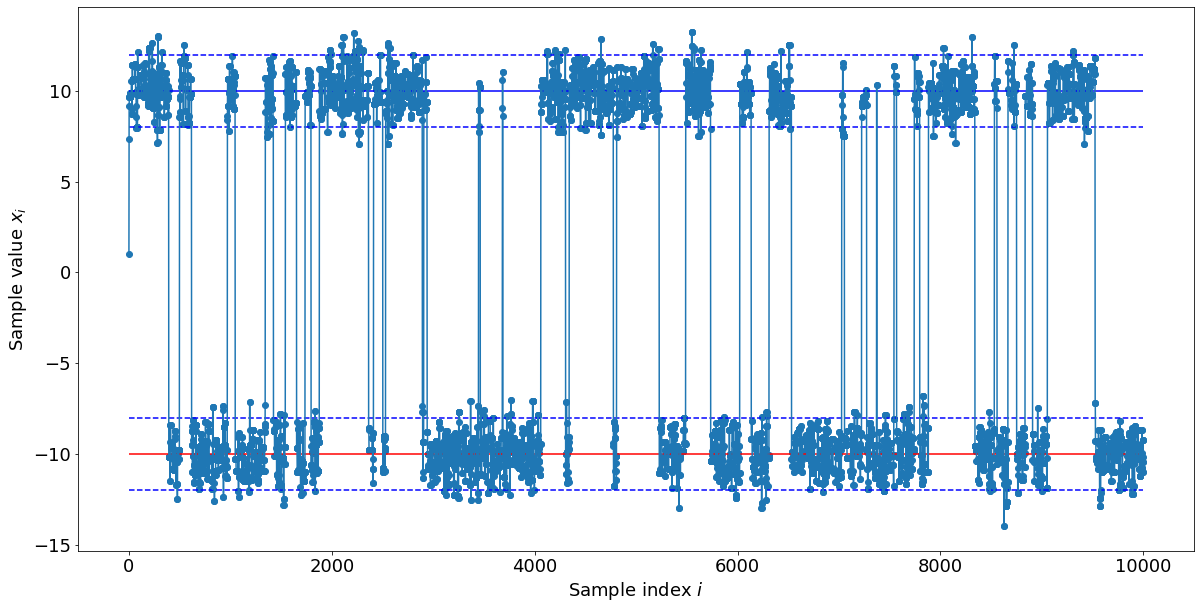

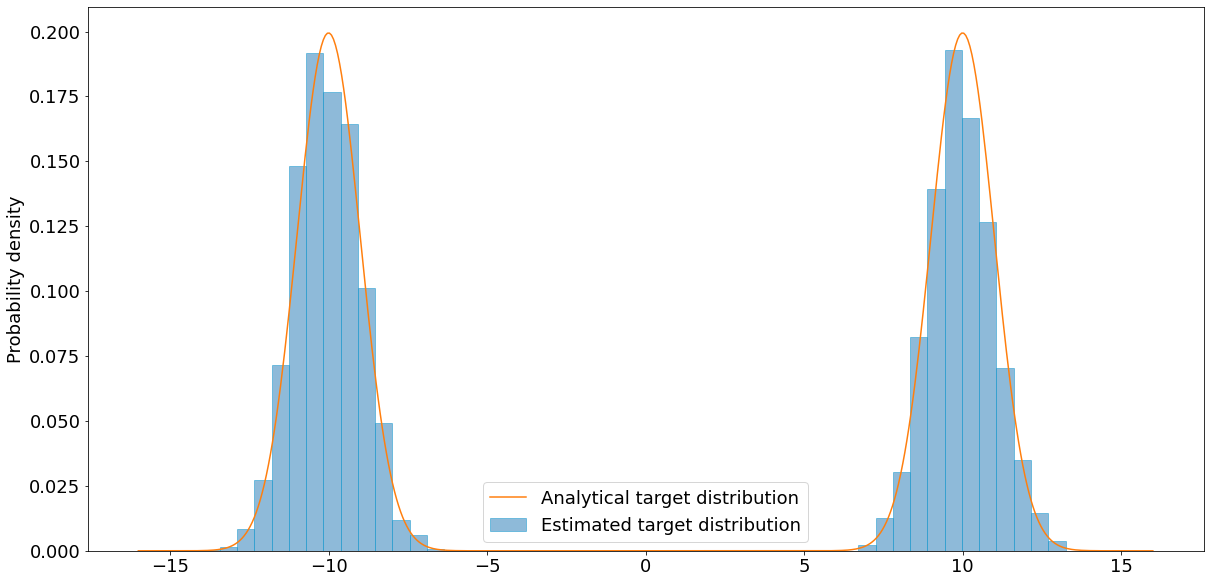

In [23]:
graph_maker = Graph_Maker(samples_non_reversible)
r"Samples from a Gaussian Mixture Model using using One Directional I-Jump with $a = 1$, $b=0.2$."
graph_maker.plot_gaussian_mixture_models([-10,10], [1,1],"5.4.2.c")
r"Estimated posterior distriution from Gaussian Mixture Model, using One Directional I-Jump when $a = 1$, $b=0.2$ and N = 10000."
graph_maker.plot_histogram_mix([pi_1,pi_2],"5.4.2.d") 

('One Directional I-Jump',
 'Comparing Covariance $c_{\\varphi}(\\tau)$ against Lag $\\tau$, for MHA and One Directional I-Jump on LogNormal(0,1) posterior distribution.')

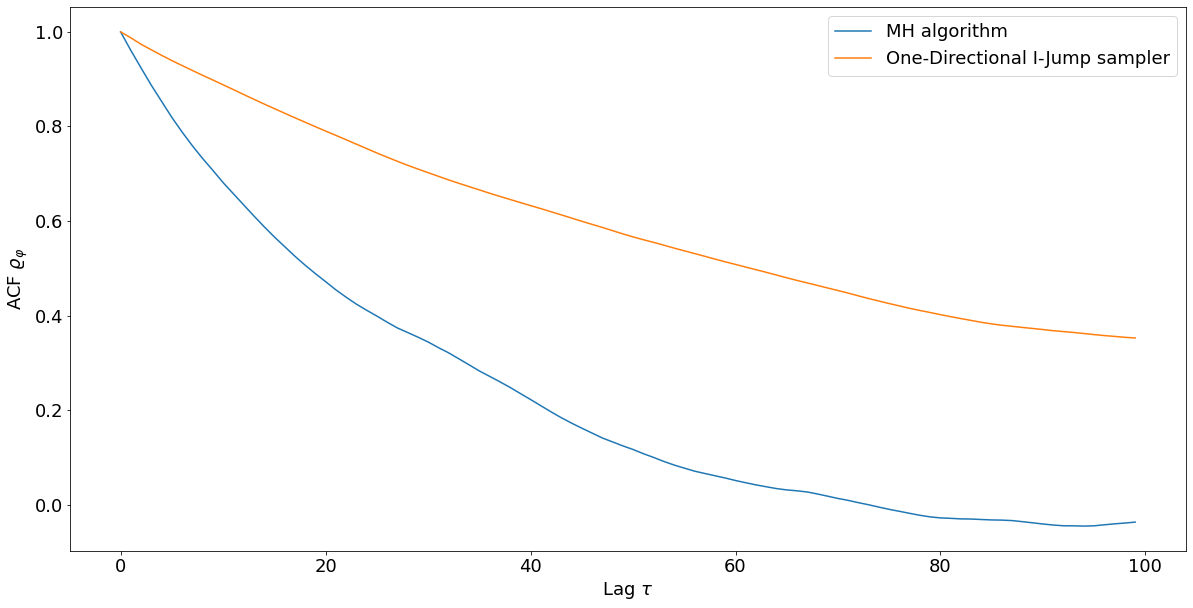

In [24]:
comparison = Compare_Covariance(samples_reversible,samples_non_reversible)
comparison.compare_lags(100, r"MH algorithm", "One-Directional I-Jump sampler", "5.4.2.f")
r"One Directional I-Jump", r"Comparing Covariance $c_{\varphi}(\tau)$ against Lag $\tau$, for MHA and One Directional I-Jump on LogNormal(0,1) posterior distribution."                         

##### 5.4.2 Gaussian Mixtures - Issue with small step size

In [711]:
np.random.seed(1)

gaussian_mix = Gaussian_Mixture([pi_1,pi_2])
proposal = Proposal(beta = 0.6, pick = "random_walk")
sampler_gaussian_mix = Reversible_Sampler(N = 10000, dimension = 1, target_distribution=gaussian_mix, proposal=proposal)

samples_reversible_small, _ = sampler_gaussian_mix.Reversible_Metropolis_Hastings_Algo()

'Estimated posterior distriution from Gaussian Mixture Model, using MHA when $\\beta = 0.5$ and N = 10000.'

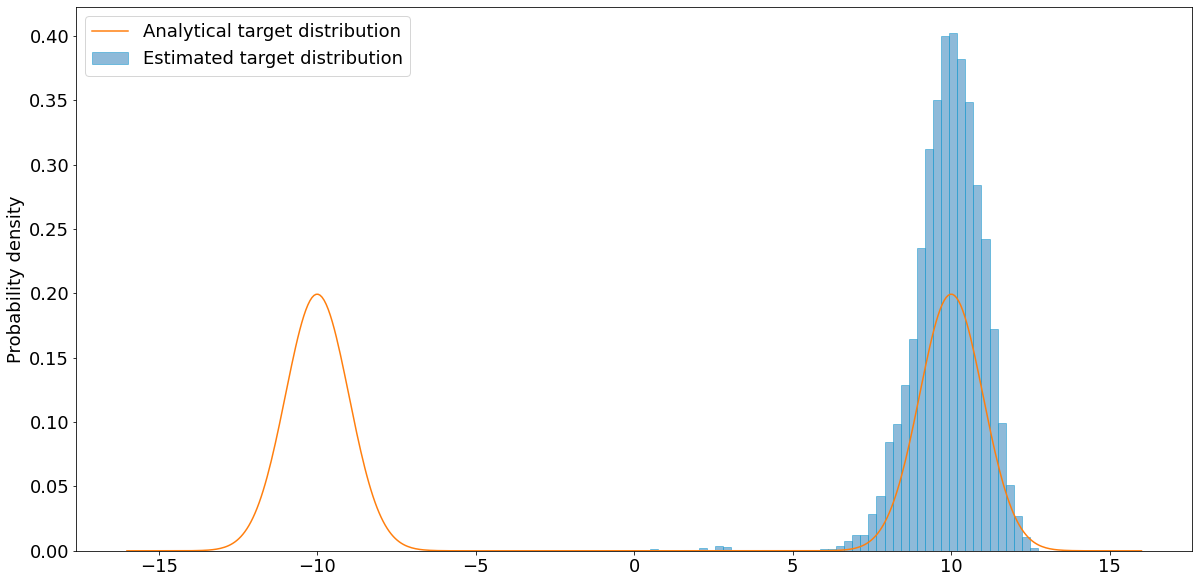

In [712]:
graph_maker = Graph_Maker(samples_reversible_small)
graph_maker.plot_histogram_mix([pi_1,pi_2], "5.4.2.e")
r"Estimated posterior distriution from Gaussian Mixture Model, using MHA when $\beta = 0.5$ and N = 10000."


### 5.5 - Comparing Reversible vs Non-Reversible samplers on  a range of functions: 2d

#### 5.5 2D-Gaussian Distribution

In [274]:
np.random.seed(1)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])

beta_s = [x/10+0.1 for x in range(60)]
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk_2d")
    sampler = Reversible_Sampler(N = 1000, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

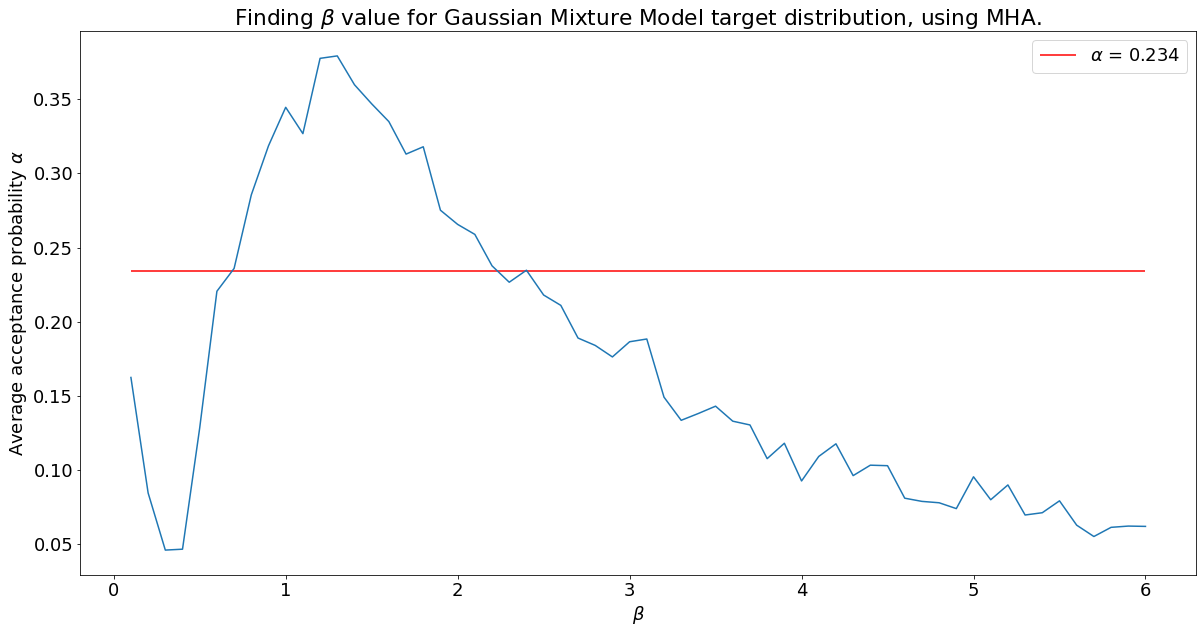

In [275]:
finding_beta(beta_s, list_a_p, r"Finding $\beta$ value for Gaussian Mixture Model target distribution, using MHA.")

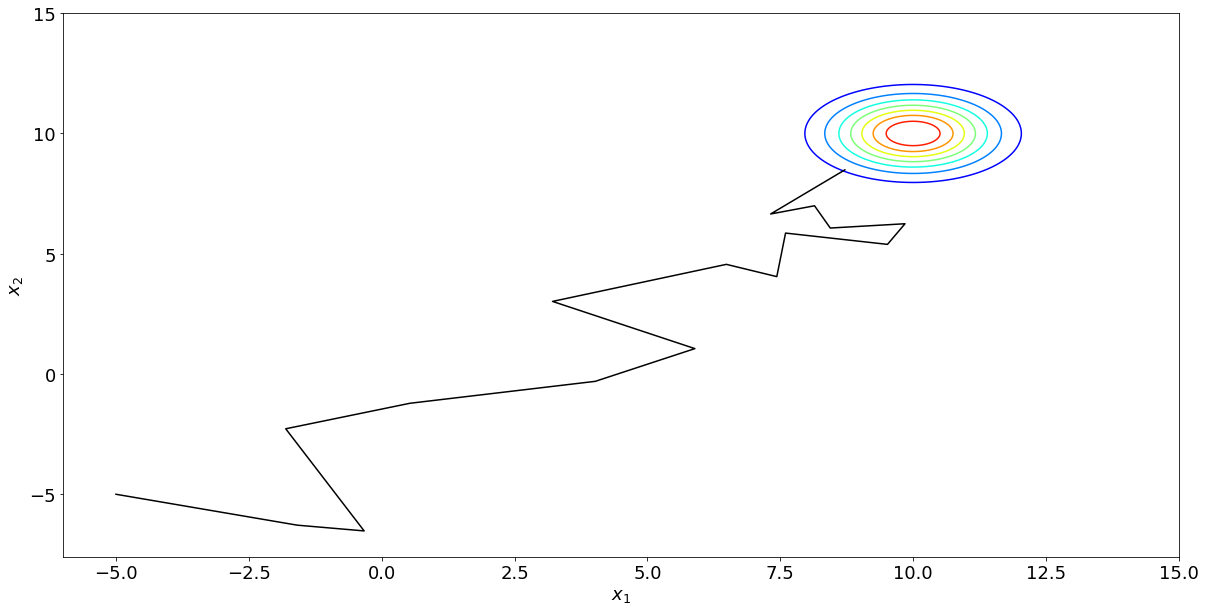

In [404]:
np.random.seed(1)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])
proposal = Proposal(beta = 2.1, pick = "random_walk_2d")
sampler_gaussian_2d = Reversible_Sampler(N = 50, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)

samples_reversible, _ = sampler_gaussian_2d.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D_gaussian([10,10],[[1,0],[0,1]],"5.5.1.a",1)

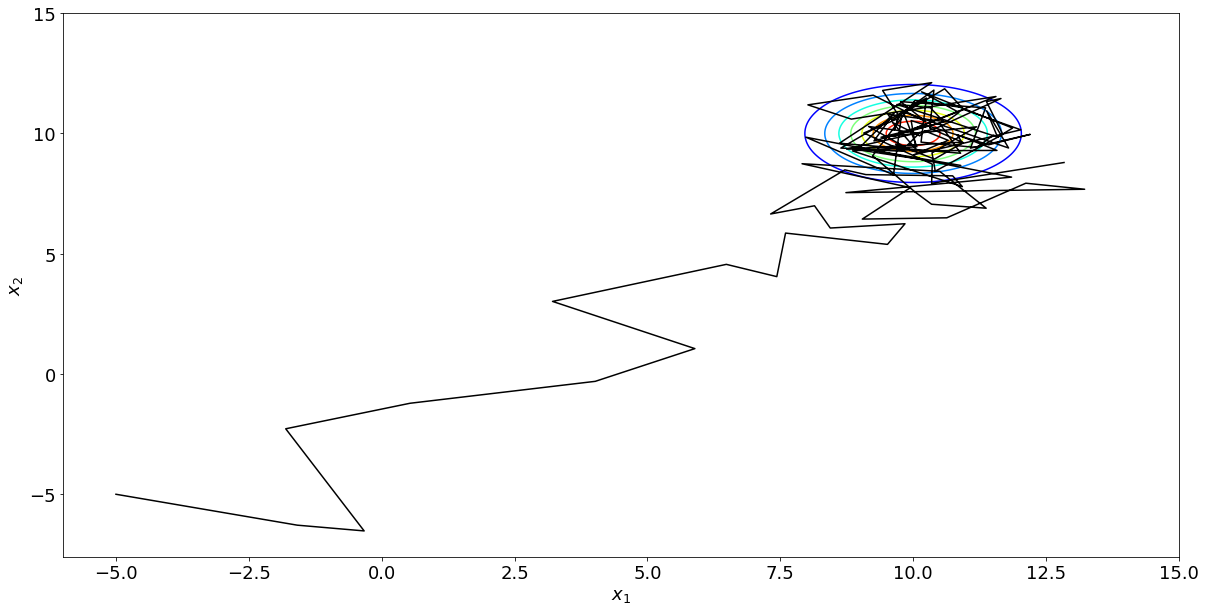

In [405]:
np.random.seed(1)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])
proposal = Proposal(beta = 2.1, pick = "random_walk_2d")
sampler_gaussian_2d = Reversible_Sampler(N = 500, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)

samples_reversible, _ = sampler_gaussian_2d.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D_gaussian([10,10],[[1,0],[0,1]],"5.5.1.b",1)

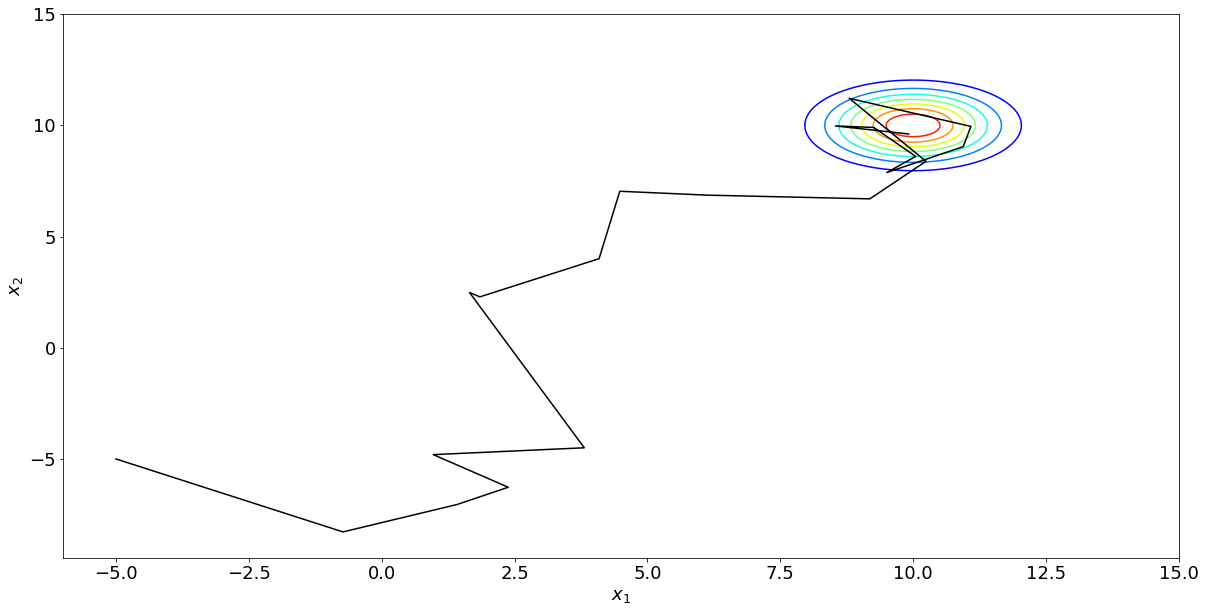

In [406]:
np.random.seed(2)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])
sampler_gaussian_2d_NR = Sampler_Non_Reversible(alpha= 1, beta = 2, N = 50, dimension = 2, target_distribution=gaussian_2d)

samples_NON_reversible, _ = sampler_gaussian_2d_NR.Non_Reversible_Metropolis_Hastings_High_Dimensions(2)

graph_maker = Graph_Maker(samples_NON_reversible)
graph_maker.plot_2D_gaussian([10,10],[[1,0],[0,1]],"5.5.1.c", 1)

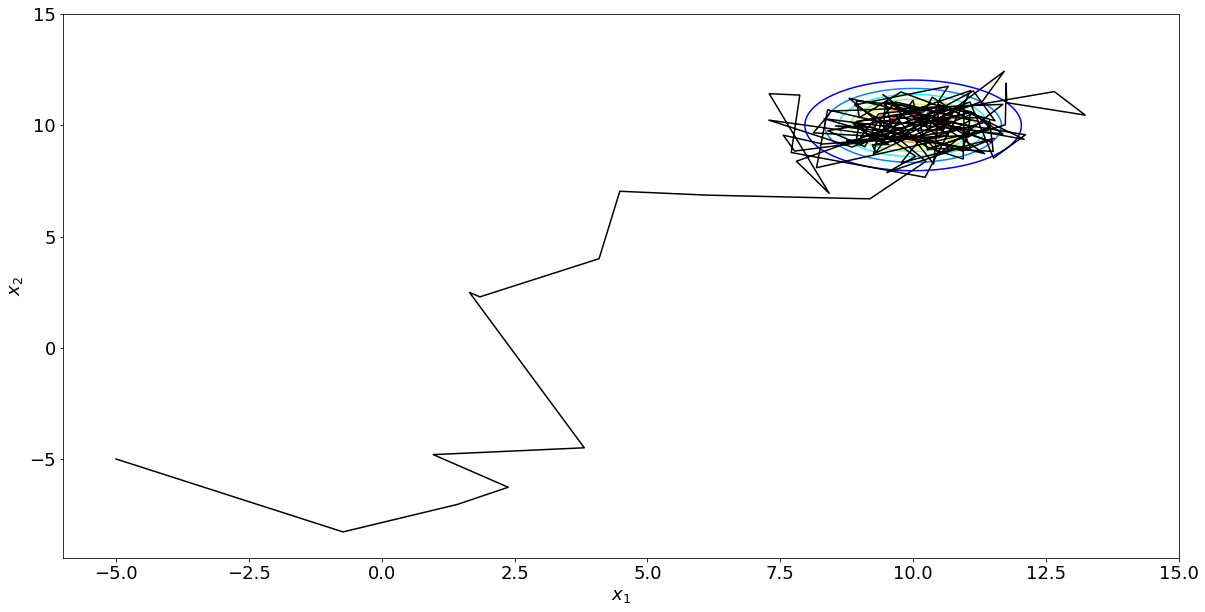

In [407]:
np.random.seed(2)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])
sampler_gaussian_2d_NR = Sampler_Non_Reversible(alpha= 1, beta = 2, N = 500, dimension = 2, target_distribution=gaussian_2d)

samples_NON_reversible, _ = sampler_gaussian_2d_NR.Non_Reversible_Metropolis_Hastings_High_Dimensions(2)

graph_maker = Graph_Maker(samples_NON_reversible)
graph_maker.plot_2D_gaussian([10,10],[[1,0],[0,1]],"5.5.1.d",1)

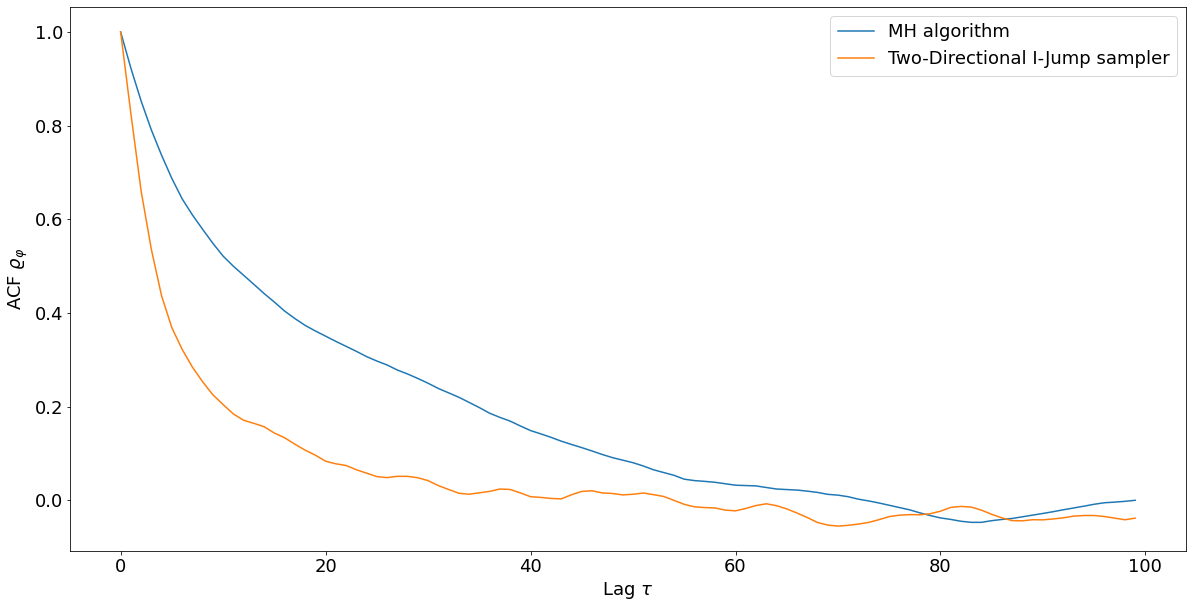

In [17]:
np.random.seed(1)

gaussian_2d = Multivariate_Gaussian([10,10],[[1,0],[0,1]])

sampler_gaussian_2d_NR = Sampler_Non_Reversible(alpha= 1, beta = 2, N = 5000, dimension = 2, target_distribution=gaussian_2d)
samples_NON_reversible, _ = sampler_gaussian_2d_NR.Non_Reversible_Metropolis_Hastings_High_Dimensions(2)

proposal = Proposal(beta = 1, pick = "random_walk_2d")
sampler_gaussian_2d = Reversible_Sampler(N = 5000, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)
samples_reversible, _ = sampler_gaussian_2d.Reversible_Metropolis_Hastings_Algo()

comparison = Compare_Covariance(samples_reversible, samples_NON_reversible)
comparison.compare_lags(100, r"MH algorithm", r"Two-Directional I-Jump sampler", "5.5.1.e" )


#### 5.5 Rosenbrook function

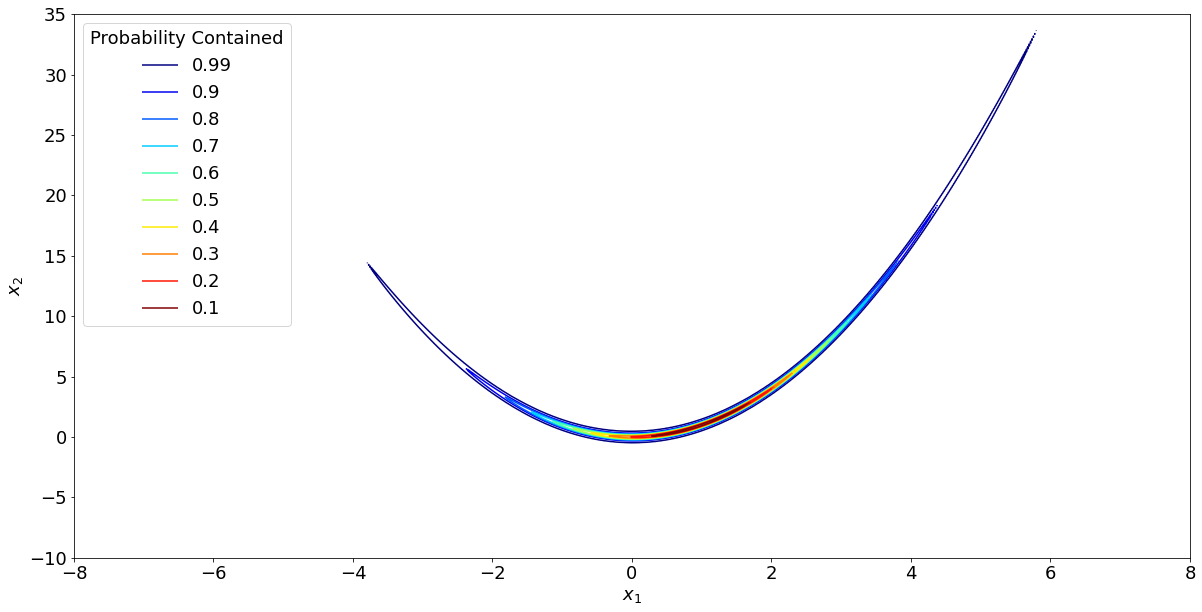

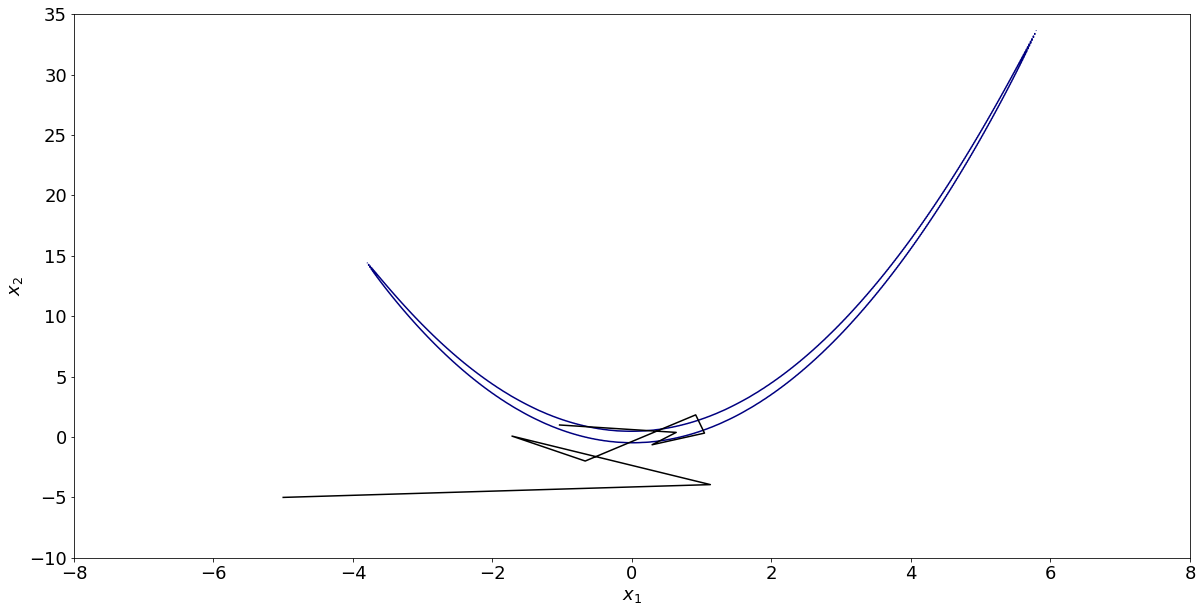

In [409]:
np.random.seed(1)

rosenbrook_2D = Rosenbrook_2D_Function(5)

proposal = Proposal(beta = 3.2, pick = "random_walk_2d")
sampler_rosenbrook_2D = Reversible_Sampler(N = 50, dimension = 2, target_distribution=rosenbrook_2D, proposal=proposal)

samples_reversible, _ = sampler_rosenbrook_2D.Reversible_Metropolis_Hastings_Algo()
graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D_rosenbrook_no_points(5, "5.5.2.a")
graph_maker.plot_2D_rosenbrook(5, "5.5.2.b", 1, False)

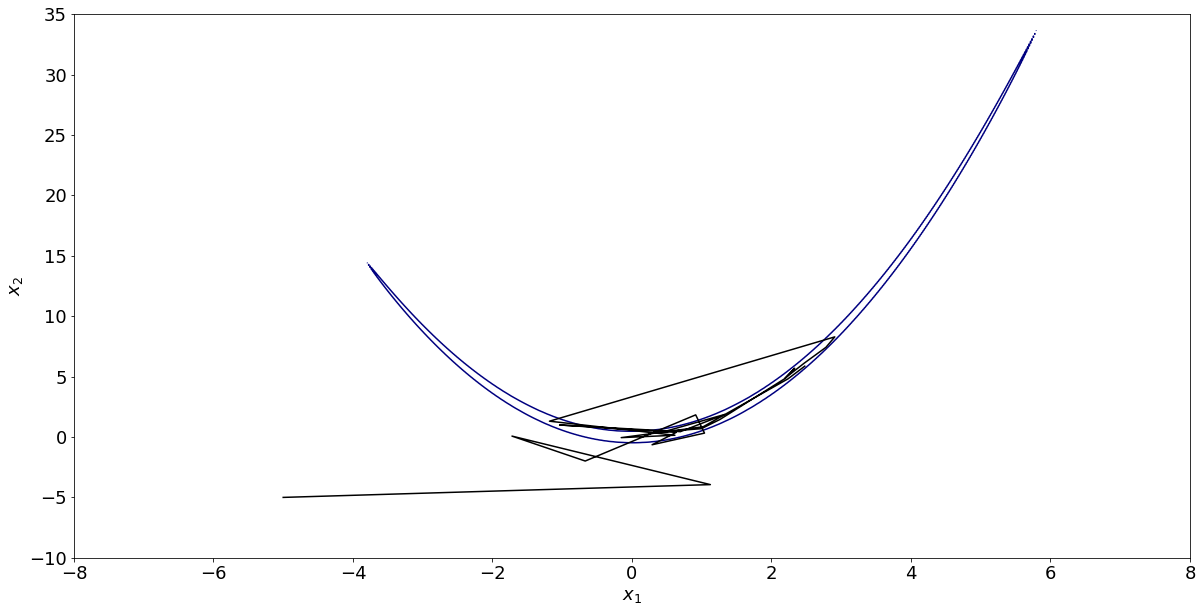

In [410]:
np.random.seed(1)

proposal = Proposal(beta = 3.2, pick = "random_walk_2d")
sampler_rosenbrook_2D = Reversible_Sampler(N = 500, dimension = 2, target_distribution=rosenbrook_2D, proposal=proposal)

samples_reversible, _ = sampler_rosenbrook_2D.Reversible_Metropolis_Hastings_Algo()
graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D_rosenbrook(5, "5.5.2.c", 1, False)

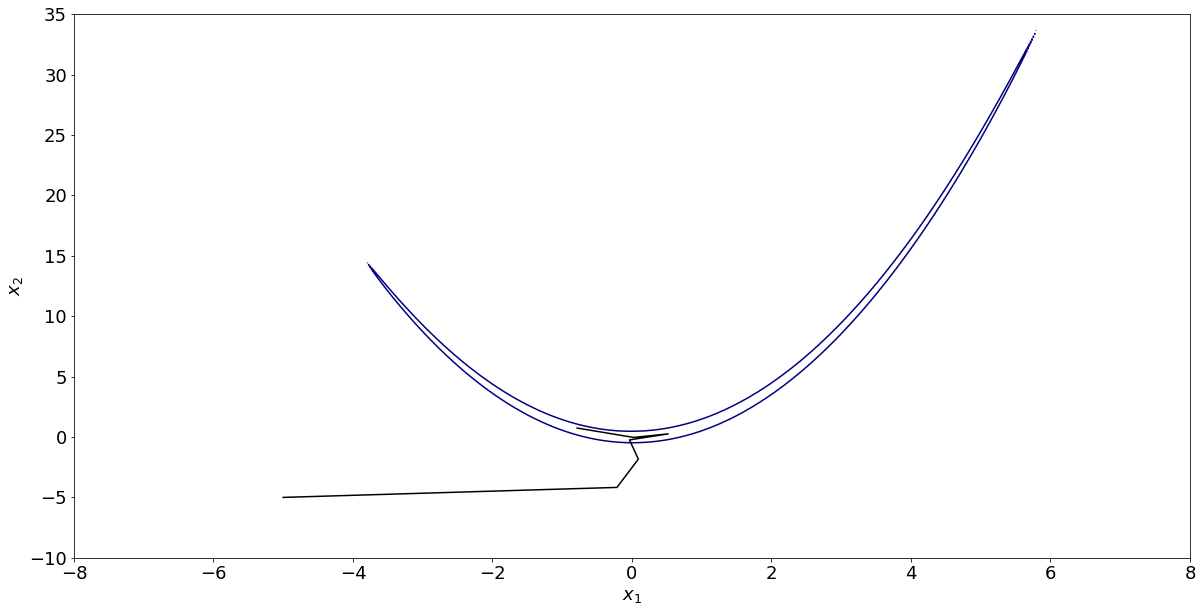

In [411]:
np.random.seed(1)

rosenbrook_2D = Rosenbrook_2D_Function(5)

sampler_rosenbrook_2D = Sampler_Non_Reversible(alpha = 1, beta = 2.5, N = 50, dimension = 2, target_distribution=rosenbrook_2D)

samples_non_reversible, _ = sampler_rosenbrook_2D.Non_Reversible_Metropolis_Hastings_High_Dimensions(500)
graph_maker = Graph_Maker(samples_non_reversible)

graph_maker.plot_2D_rosenbrook(5, "5.5.2.d", 1, False)

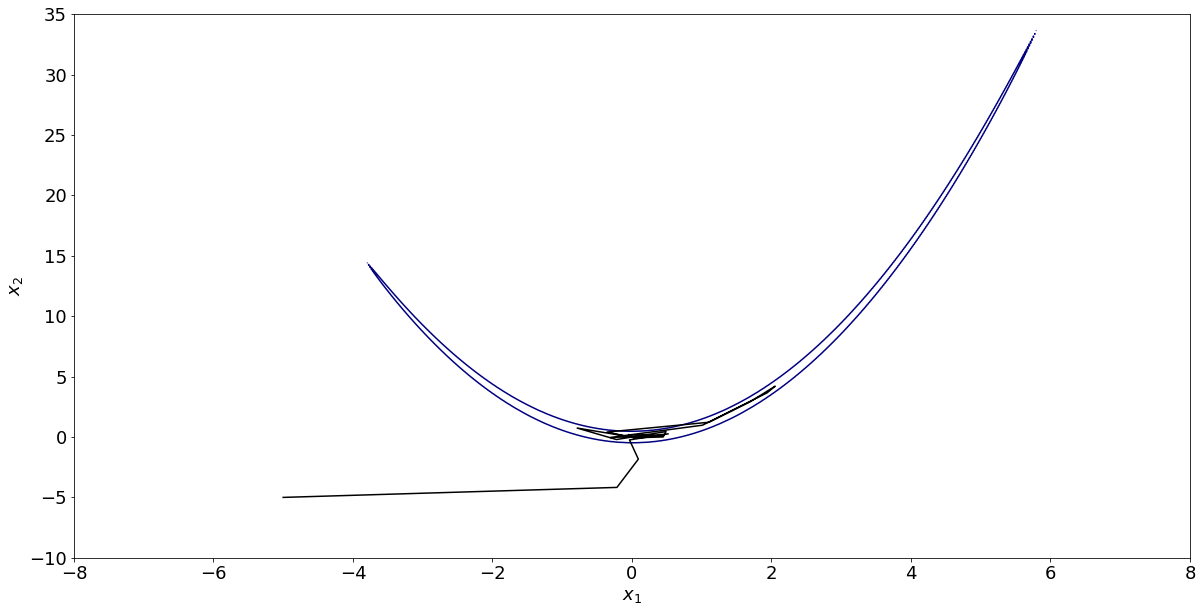

In [412]:
np.random.seed(1)

rosenbrook_2D = Rosenbrook_2D_Function(5)

sampler_rosenbrook_2D = Sampler_Non_Reversible(alpha = 1, beta = 2.5, N = 500, dimension = 2, target_distribution=rosenbrook_2D)

samples_non_reversible, _ = sampler_rosenbrook_2D.Non_Reversible_Metropolis_Hastings_High_Dimensions(500)
graph_maker = Graph_Maker(samples_non_reversible)

graph_maker.plot_2D_rosenbrook(5, "5.5.2.e", 1, False)

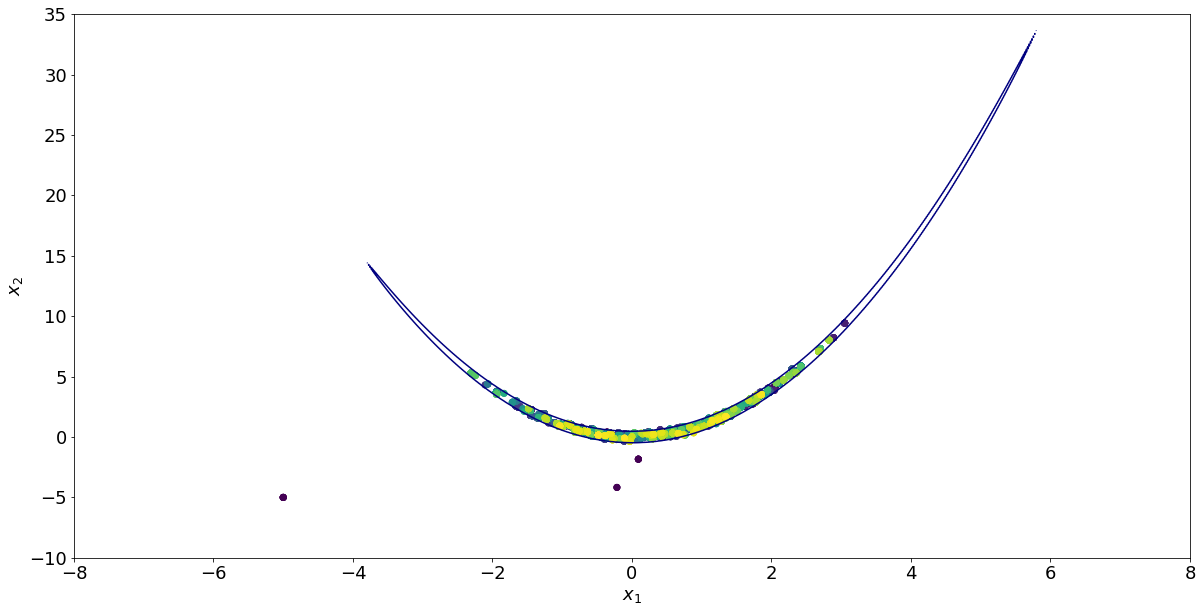

In [31]:
np.random.seed(1)

rosenbrook_2D = Rosenbrook_2D_Function(5)

sampler_rosenbrook_2D = Sampler_Non_Reversible(alpha = 1, beta = 2.5, N = 10000, dimension = 2, target_distribution=rosenbrook_2D)

samples_non_reversible, _ = sampler_rosenbrook_2D.Non_Reversible_Metropolis_Hastings_High_Dimensions(500)
graph_maker = Graph_Maker(samples_non_reversible)

graph_maker.plot_2D_rosenbrook(5, "5.5.2.f", 2, False)

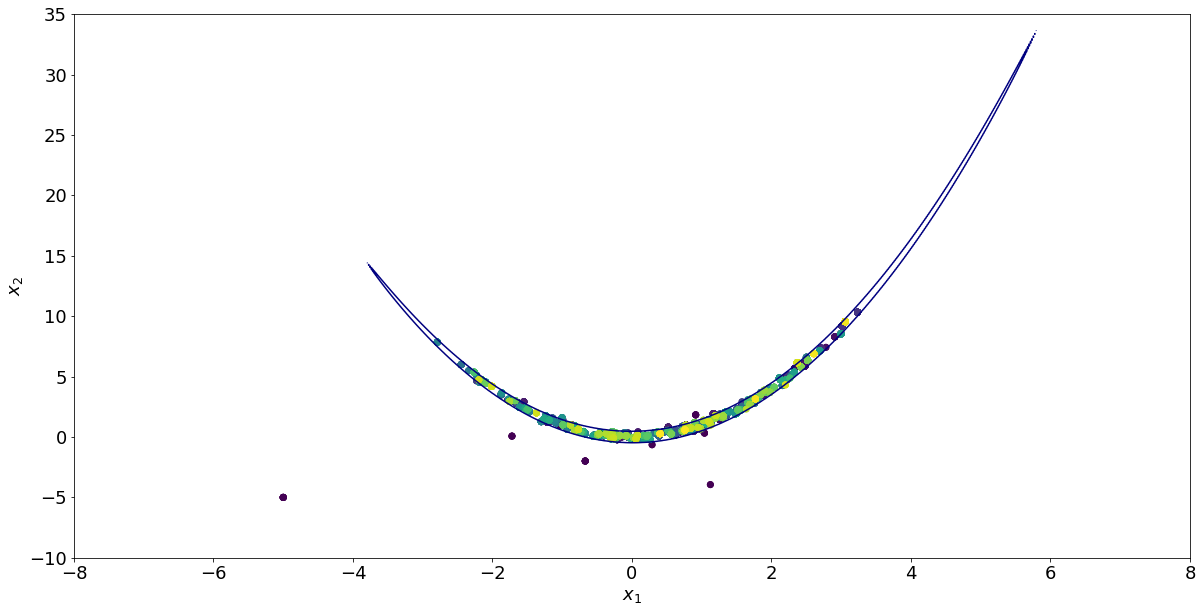

In [32]:
np.random.seed(1)

proposal = Proposal(beta = 3.2, pick = "random_walk_2d")
sampler_rosenbrook_2D = Reversible_Sampler(N = 10000, dimension = 2, target_distribution=rosenbrook_2D, proposal=proposal)

samples_reversible, _ = sampler_rosenbrook_2D.Reversible_Metropolis_Hastings_Algo()
graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D_rosenbrook(5, "5.5.2.g", 2, False)

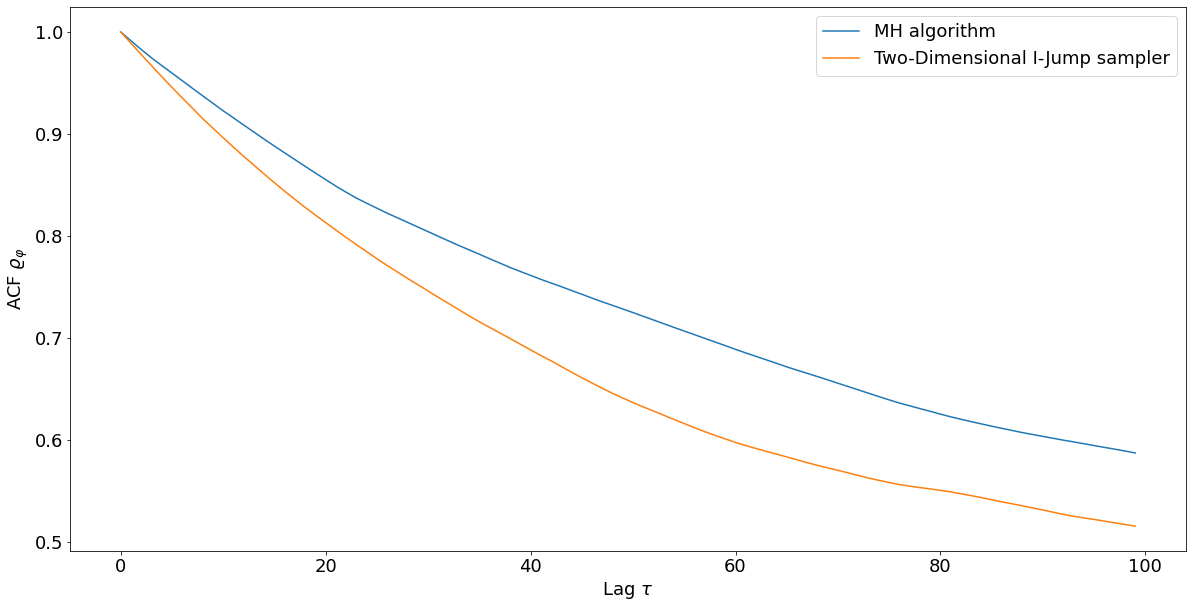

In [33]:
comparison = Compare_Covariance(samples_reversible, samples_non_reversible)
comparison.compare_lags(100, r"MH algorithm", r"Two-Dimensional I-Jump sampler", "5.5.2.h" )

### 6 - Imaging problems

In [59]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

__all__ = \
    [
        "empty_true_color",
        "gaussian_filter",
        "get_bit_plane",
        "imhist",
        "imread",
        "imscale",
        "imshow",
        "imshow_reduced_color_depth",
        "imwrite",
        "linear_filter",
        "median_filter",
        "rank_filter",
        "zero_bit_plane"
    ]


def _img_a_cast(img_a, dtype, true_color=False):
    img_a = np.maximum(img_a, 0)
    img_a = np.minimum(img_a, 255)
    img_a = np.round(img_a, 0)
    img_a = np.array(img_a + 1.0e-6, dtype=dtype)
    if len(img_a.shape) == 2:
        if true_color:
            img_a_gs = np.zeros((img_a.shape[0], img_a.shape[1], 3),
                                dtype=dtype)
            for k in range(3):
                img_a_gs[:, :, k] = img_a
            return img_a_gs
        else:
            return img_a
    else:
        if len(img_a.shape) != 3 or img_a.shape[2] != 3:
            raise RuntimeError("Unexpected image type")
        return img_a

def imread(filename):
    img = PIL.Image.open(filename, "r")
    return np.array(img, dtype=np.int64)

def imscale(img_a, factor, interpolation="nearest"):
    """
    Scale an image.
    """
    M, N = img_a.shape[:2]
    M_scaled = int(max(round(M * factor, 0), 1) + 1.0e-6)
    N_scaled = int(max(round(N * factor, 0), 1) + 1.0e-6)

    img_a = _img_a_cast(img_a, dtype=np.uint8)
    img = PIL.Image.fromarray(img_a)
    img = img.resize((M_scaled, N_scaled),
                     resample={"nearest": PIL.Image.NEAREST,
                               "bilinear": PIL.Image.BILINEAR,
                               "bicubic": PIL.Image.BICUBIC,
                               "lanczos": PIL.Image.LANCZOS}[interpolation])

    return np.array(img, dtype=np.int64)

def imshow(img_a, new_figure=True):
    img_a = _img_a_cast(img_a, dtype=np.uint8, true_color=True)

    if new_figure:
        plt.figure()
    plt.imshow(img_a)
    plt.xticks([])
    plt.yticks([])
    
def imsave(img_a, file_name, new_figure=True):
    """
    Save an image.
    """
    img_a = _img_a_cast(img_a, dtype=np.uint8, true_color=True)

    if new_figure:
        plt.figure()
    plt.imshow(img_a)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)
    

def linear_filter(img_a, W, **kwargs):
    """
    Adds a linear filter W to the img_a.
    """
    img_a = _img_a_cast(img_a, dtype=np.int64)
    W = np.fliplr(np.flipud(W))

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.convolve(img_a, W, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.convolve(
                img_a[:, :, k], W, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

def gaussian_filter(img_a, sigma, **kwargs):
    """
    Adds a gaussian filter variance sigma to the img_a with variance.
    """
    img_a = _img_a_cast(img_a, dtype=np.int64)

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.gaussian_filter(
            img_a, sigma, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.gaussian_filter(
                img_a[:, :, k], sigma, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

In [60]:
class Sampler_Imaging():
    """
    This class defines reversible and non reverisible samplers such that they can be used with images.
    """
    
    def __init__(self, beta, N, dimension, image, proposal):
        #This defines the step size for both reversible and non reverisble samplers
        self.beta = beta
        #N is the number of iterations the algorithm runs for (int)
        self.N = N
        #dimension is the dimension of the state space. (int)
        self.dimension = dimension
        #Proposal used for the reversible sampler do not need to define one for non reverisble samplers
        self.proposal = proposal
        #The target distribution is defined by the image and uses the Class_Target, 
        #to define the pdf of this distribution
        self.target_distribution = Image_Target(image)
        #This is the image in raw form, under no transformation.
        self.image = image
    
    def Reversible_Metropolis_Hastings_Algo(self):
        """
        Implementation of the for imaging Metropolis Hastings Algorithm.
        
        Output:
        -samples: List of samples which proposal images
        -list_acceptance_probaility: List of acceptance probabilities used
        for tuning the algorithm.
        """
        
        #We initalzie the first sample at the image flattened.
        u_0 = np.around(self.image.flatten())
        u_t = u_0
        
        #list of samples generated by the algorithm
        samples = [u_0]
        #list of accepttance probability at each iteration of the algorithm
        list_acceptance_probaility = []
        
        #Proposal of the problem
        proposal = self.proposal

        #Begin iterations
        for t in range(self.N):
            
            #Sample a proposal x_prime from proposal at x_t
            u_prime = np.around(proposal.get_random_variable(u_t))
            
            #Evaluation of the numerator of acceptance ratio
            numerator = self.target_distribution.pdf(u_prime)
            #Evaluation of the denomiantor of acceptance ratio
            denominator = self.target_distribution.pdf(u_t)
            
            #Calculate acceptance proability 
            if numerator == 0:
                acceptance_probaility = 0
            elif denominator == 0:
                acceptance_probaility = 1
            else:
                acceptance_probaility = float(min([1,numerator/denominator]))
            
            #Add acceptance probability to list_acceptance_probaility 
            list_acceptance_probaility.append(acceptance_probaility)
            rv = np.random.uniform(0,1,1)
            #Accept or reject step
            if rv <= acceptance_probaility:
                #Accept: we update x_t to x_prime
                u_t = u_prime
                samples.append(u_t)
            else:
                #Reject: we remain at x_t
                u_t = u_t
                samples.append(u_t)
        
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility
    
    def Non_Reversible_Metropolis_Hastings_High_Dimensions(self, period):
        """
        Implementation of the N-Directional I-Jump Sampler.
        
        Input:
        -period: periodicty to change the direction of auxiliarry varible y_p. (int)
        
        Output:
        -samples: List of samples which are integers.
        -list_acceptance_probaility: List of acceptance probabilities used
        for tuning the algorithm.
        """

        #We initalzie the first sample at the image flattened.
        x_0 = np.around(self.image.flatten())
        x_t = x_0
        
        #Define the possible directions we can move in
        direction_vectors = np.eye(self.dimension)
        #Pick a random direction for auxiliarry varible y_p
        y_p = direction_vectors[np.random.randint(self.dimension)]
        
        #list of samples generated by the algorithm
        samples = [x_t]
        #list of accepttance probability at each iteration of the algorithm
        list_acceptance_probaility = []
        
        #We define variables such that they are the 
        #posterior distirbution of the problem
        posterior_distribution = self.target_distribution
        
        #We inizalize the z indicator random varibale
        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1
        
        #Define sgn function which calculates the dot product of 2 vectors
        #And returns 1 greater than 0 or -1 otherwise
        def sgn(eta,y_p):
            x = np.dot(eta,y_p)
            if x >= 0:
                return 1
            else:
                return -1
            
        #Define a multivariate normal distribution used to propose samples
        multivariate_normal = stats.multivariate_normal(np.zeros(self.dimension),
                                                        self.beta**2*np.eye(self.dimension))

        #Define a half space multivariate gaussian distribution, f for one direction
        def f_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
            else:
                return 0 
        
        #Define a half space multivariate gaussian distribution, g for other direction
        def g_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return 0
            else:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
        
        #Begin iterations
        for t in range(self.N):
            
            # Change direction y_p periodically
            if t%period == 0:
                y_p = direction_vectors[np.random.randint(self.dimension)]
            
            #Indicator varibale telling us in what direction to move in.
            if z > 0: 
                
                #Create a normal distribution random variable
                eta = multivariate_normal.rvs()
                #Sample a proposal x_prime from proposal at x_t with f.
                x_prime = x_t + sgn(eta,y_p)*eta

                # evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*g_pdf(x_t, x_prime, y_p)

                # evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*f_pdf(x_prime, x_t, y_p)
    
                #Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                
            else:
                
                #Create a normal distribution random variable
                eta = multivariate_normal.rvs()
                #Sample a proposal x_prime from proposal at x_t with g.
                x_prime = x_t - sgn(eta,y_p)*eta

                # evaluation of the numerator of acceptance ratio
                numerator = posterior_distribution.pdf(x_prime)*f_pdf(x_t,x_prime, y_p)

                # evaluation of the denominator of acceptance ratio
                denominator = posterior_distribution.pdf(x_t)*g_pdf(x_prime, x_t, y_p)

                #Calculate acceptance proability 
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                    
            #Add acceptance probability to list_acceptance_probaility 
            list_acceptance_probaility.append(acceptance_probaility)

            #Sample a random variable [0,1]
            rv = np.random.uniform(0,1,1)

            #Accept or reject step
            if rv <= acceptance_probaility:
                #Accept
                x_t = x_prime
                samples.append(x_t)
                #leave z unchanged
                z = z 
            else:
                #Accept update x_t to x_prime
                x_t = x_t
                samples.append(x_t)
                #update the indicator z
                z = -1*z
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility


In [61]:
class Image_Target():
    """
    This is the target distribution for imaging problems. 
    We need to define the proior and likelihood to be able to use this 
    as the posterior distribution.
    """
    
    def __init__(self, image):
        """
        To inizalize we need to pass an image through this, that is an nxn
        np.array. With values between 0 to 264.
        """
        self.image = image
        #n is the dimension of our problem 
        self.n = image.shape[0]
        #we flatten the image to be the mean of the likelihood 
        self.flatten_image = image.flatten()

    def prior_TV(self, x):
        """
        
        """
        x = x.reshape((self.n,self.n))
        sum = 0
        for i in range(self.n-1):
            for j in range(self.n-1):
                sum = sum + np.sqrt(np.abs(x[i+1,j]-x[i,j])**2 + np.abs(x[i,j+1]-x[i,j])**2)
        return sum
    
    def prior_J_TV(self, x):
        """
        We are defining the total variational prior in this function for a given image x.
        input:
        -x:is a flattened n by n image (n by n np.array)
        output:
        -prior: the value of the prior for the image x (int)
        """
        #This is the dimension of the image
        n = self.n
        #Reshape the image
        X = x.reshape((self.n,self.n))
        
        #Here we define the circulant matrix D
        first = np.array([-1]+[1]+[0 for i in range(n-2)])
        last = np.array([0 for i in range(n-2)]+[-1]+[1])
        D = first
        for i in range(n-2):
            D_i = np.array([0 for i in range(i)]+[-1,0,1]+[0 for i in range(n-3-i)])
            D = np.vstack((D,D_i))

        D = np.vstack((D,last))
        
        #get the number of rows and collumns of matrix D
        n, m = D.shape
        #We calulcate the expression for the TV prior
        #Multiply image X by D
        X_D_t = X@D.T
        #Multiply D by X
        D_X = D@X
        
        #We need to iteraroe over these matricies square and add these 
        #Values together, by definition of th the TV prior.
        prior = 0
        #range over the columns
        for i in range(m):
            #range over the rows
            for j in range(n):
                #Sum each individual entry of X_D_t and D_X together
                prior = prior + np.sqrt(((X_D_t)[i,j])**2 + ((D_X)[i,j])**2)
        
        #Return the prior value    
        return prior
            
    def pdf(self, x):
        """
        Posterior distribution of image, gets the pdf of a new point x, which in this case is a new image.
        """
        #The likelihood is defined in the later part of the expression
        return self.prior_J_TV(x)*(np.exp(-1/2*(np.linalg.norm(self.flatten_image-x))**2))

In [62]:
def MAP(samples, target_distribution):
    """
    Calculates the Mazimum Aposteiro Estimate of a traget of interest
    given sample in this particular case for images.
    Input: 
    -samples: samples to be evaluated produced by an MCMC method (list)
    -target_distribution: where these samples are evaluated at.
    Output: 
    -best_image: image with highest target density (image)
    """
    #set max value to 0
    max_value = 0
    #let the best image be the first sample
    best_image = samples[0]
    
    #iterate over the samples
    for image in samples:
        #if a new sample has higher target probability
        if target_distribution.pdf(image) > max_value:
            #update the max value
            max_value = target_distribution.pdf(image)
            #update best_image
            best_image = image
    
    return best_image

def CM(images):
    """
    Estimates the Condtional Mean of a set of sample.
    Input: 
    -images: samples to be evaluated produced by an MCMC method (list)
    Output: 
    -CM of the samples.
    """
    #get the first image
    image_1 = images[0]
    #iterate over the other images
    for image in images[1:]:
        #add current image with the next
        image_1 = image_1 + image
    #return the mean of all the images together
    return (1/len(images))*(image_1)

def MSE(actual, pred): 
    """
    Calculates the MSE between the actual vector and the predicted vector
    In imaging this is simply the difference between the original 
    and the estimate.
    """
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

In [63]:
import os 
filename = os.getcwd()

In [64]:
image_camera = imread(filename+"/cameraman.png")

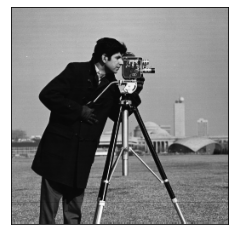

In [65]:
imshow(image_camera)

#### 6.4.1 De-Noising

(None, None)

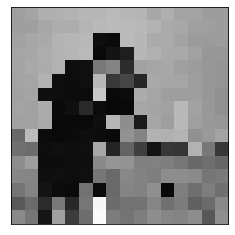

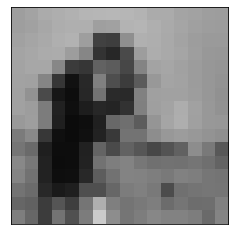

In [66]:
image_camera_scaled = imscale(image_camera,1/16)
img_noisy_scaled = gaussian_filter(image_camera_scaled,0.6)

imshow(image_camera_scaled), imshow(img_noisy_scaled)

#### 6.4.1 - Finding the best beta value for our problem

In [67]:
dimension = len(img_noisy_scaled.flatten())
beta_s = list(np.linspace(0.01,0.8,50))
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk_nd")
    sampler = Sampler_Imaging(beta = beta, N = 100, dimension = dimension, image=img_noisy_scaled, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

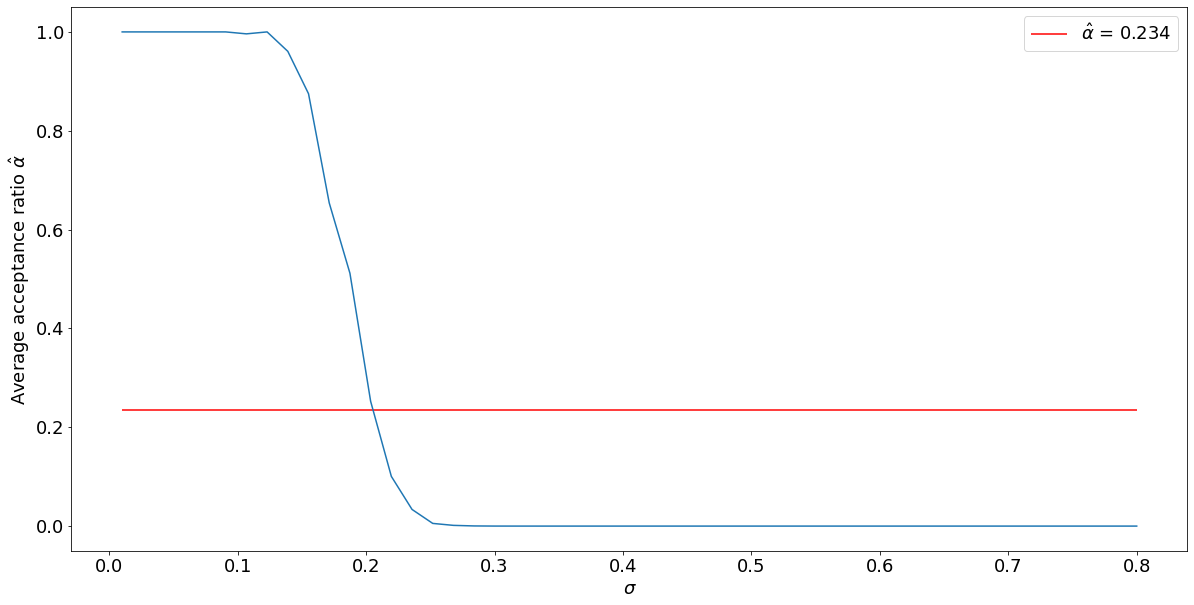

In [68]:
plot_finding_beta(beta_s, list_a_p, "6.4.1.a")

#### 6.1b Using MHA to sample potential images

In [90]:
np.random.seed(1)

dimension = len(img_noisy_scaled.flatten())
print(dimension)

target_distribution = Image_Target(img_noisy_scaled)
proposal = Proposal(beta = 0.2, pick = "random_walk_nd")
sampler_image = Sampler_Imaging(beta = 0.2, N = 10000, dimension=dimension, image=img_noisy_scaled, proposal=proposal)

samples_reversible_DN, _ = sampler_image.Reversible_Metropolis_Hastings_Algo()

256


#### 6.1c MAP to find the most likey image from the samples.

In [613]:
def imsave(img_a, file_name, new_figure=True):
    img_a = _img_a_cast(img_a, dtype=np.uint8, true_color=True)

    if new_figure:
        plt.figure()
    plt.imshow(img_a)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('{}.pdf'.format(file_name), bbox_inches = 'tight', pad_inches = 0)

Original Noisy Image:
MSE: 543.921875


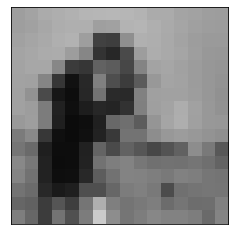

In [614]:
print("Original Noisy Image:")
imsave(img_noisy_scaled,"TEST")
print("MSE: {}".format(mse(image_camera_scaled.flatten(), img_noisy_scaled.flatten())))

Reconstructed Image with CM:
MSE: 544.0414217100093
Reconstructed Image with MAP:
MSE: 543.921875


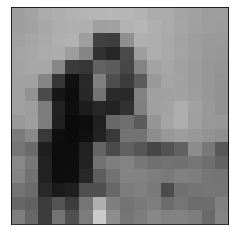

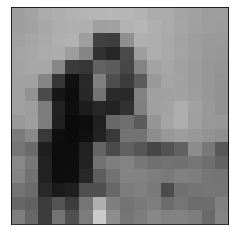

In [92]:
print("Reconstructed Image with CM:")
best_image_CM_reversible = CM(samples_reversible_DN)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_CM_reversible)))

imsave(best_image_CM_reversible.reshape(16,16), "6.4.1.b")

print("Reconstructed Image with MAP:")
best_image_MAP_reversible = MAP(samples_reversible_DN, target_distribution)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_MAP_reversible)))
imsave(best_image_CM_reversible.reshape(16,16), "6.4.1.c")

In [47]:
np.random.seed(1)
dimension = len(img_noisy_scaled.flatten())

b_s = list(np.linspace(0.01,.8,25))
list_a_p = []

for b in b_s:
    print(b)
    proposal = Proposal(beta = _, pick = "random_walk_nd")
    sampler = Sampler_Imaging(beta = b, N = 1000, dimension = dimension, image=img_noisy_scaled, proposal=proposal)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_High_Dimensions(100)
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

0.01
0.04291666666666667
0.07583333333333334
0.10875
0.1416666666666667
0.17458333333333337
0.20750000000000002
0.2404166666666667
0.2733333333333334
0.30625
0.3391666666666667
0.3720833333333334
0.405
0.43791666666666673
0.4708333333333334
0.50375
0.5366666666666667
0.5695833333333334
0.6025
0.6354166666666667
0.6683333333333334
0.70125
0.7341666666666667
0.7670833333333335
0.8


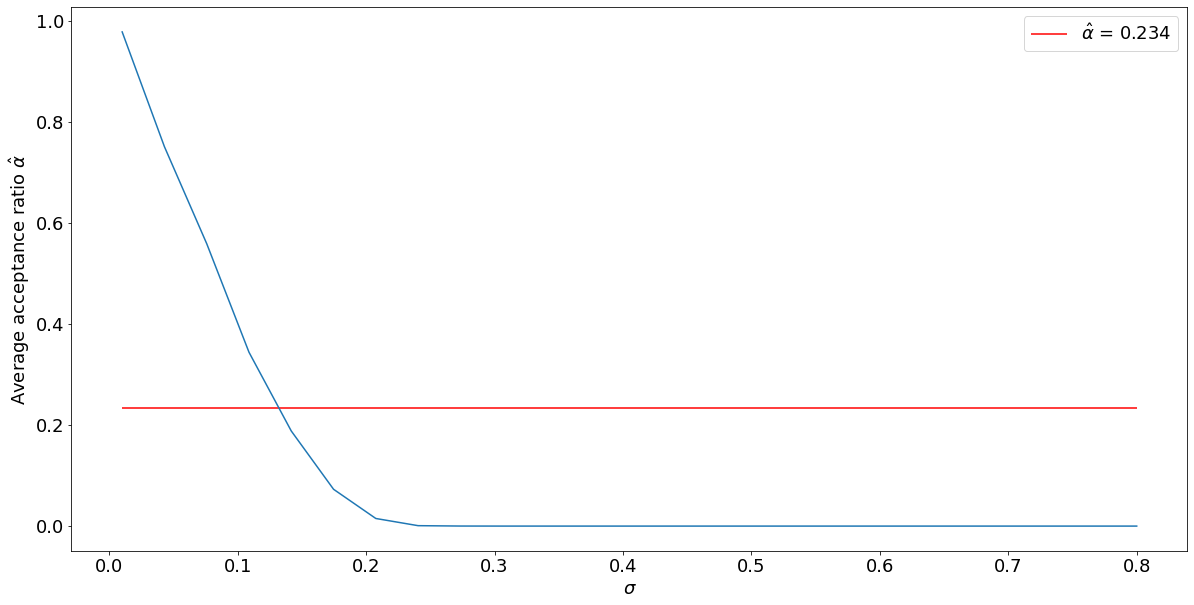

In [48]:
plot_finding_beta(b_s, list_a_p, "6.4.1.d")

In [95]:
np.random.seed(1)

dimension = len(img_noisy_scaled.flatten())

target_distribution = Image_Target(img_noisy_scaled)
sampler_image = Sampler_Imaging(beta = 0.2, N = 10000, dimension=dimension, image=img_noisy_scaled, proposal=proposal)

samples_non_reversible_DN, _ = sampler_image.Non_Reversible_Metropolis_Hastings_High_Dimensions(10)


Reconstructed Image with CM:
MSE: 542.400660202476
Reconstructed Image with MAP:
MSE: 543.921875


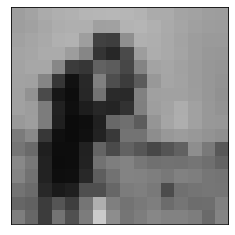

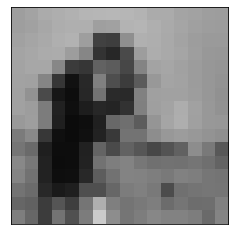

In [96]:
print("Reconstructed Image with CM:")
best_image_CM_NR = CM(samples_non_reversible_DN)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_CM_NR)))
imsave(best_image_CM_NR.reshape(16,16), "6.4.1.e")

print("Reconstructed Image with MAP:")
best_image_MAP_NR = MAP(samples_non_reversible_DN, target_distribution)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_MAP_NR)))
imsave(best_image_MAP_NR.reshape(16,16), "6.4.1.f")

#### 6.4.2 - De-blurring

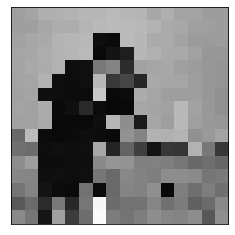

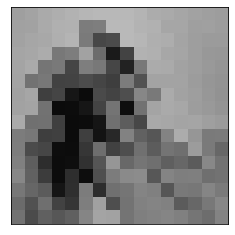

In [100]:
n = 3

W = np.eye(n)/n

image_camera_scaled = imscale(image_camera,1/16)
img_blurred_scaled = linear_filter(image_camera_scaled, W)

imshow(image_camera_scaled), 

imsave(img_blurred_scaled, "scaled_blurred")

Original Blurred Image:
MSE: 1207.97265625


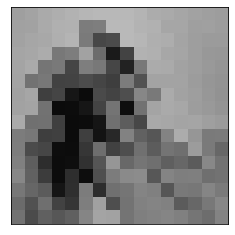

In [102]:
print("Original Blurred Image:")
imsave(img_blurred_scaled,"TEST")
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), img_blurred_scaled.flatten())))

In [42]:
dimension = len(img_noisy_scaled.flatten())
beta_s = list(np.linspace(0.01,1,50))
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk_nd")
    sampler = Sampler_Imaging(beta = beta, N = 100, dimension = dimension, image=img_noisy_scaled, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

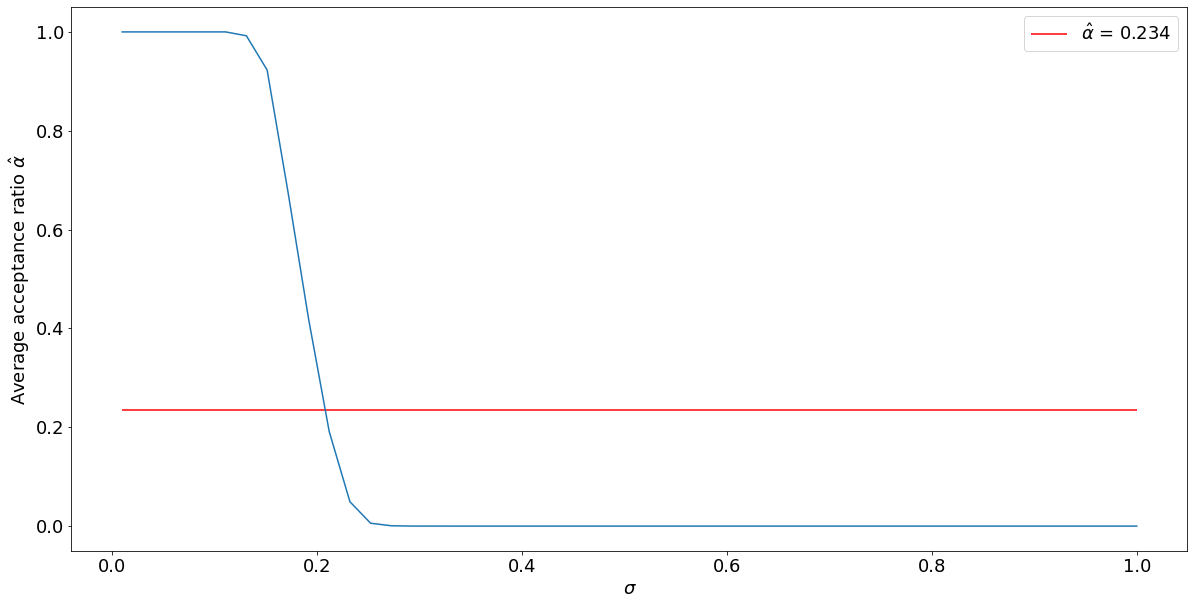

In [45]:
plot_finding_beta(beta_s, list_a_p, "6.4.2.a")

In [103]:
np.random.seed(1)

dimension = len(img_blurred_scaled.flatten())
print(dimension)

target_distribution_DB = Image_Target(img_blurred_scaled)
proposal = Proposal(beta = 0.2, pick = "random_walk_nd")
sampler_image = Sampler_Imaging(beta = 0.2, N = 10000, dimension=dimension, image=img_blurred_scaled, proposal=proposal)

samples_reversible_DB, _ = sampler_image.Reversible_Metropolis_Hastings_Algo()

256


Reconstructed Image with CM:
MSE: 1208.2273675685485
Reconstructed Image with MAP:
MSE: 1207.97265625


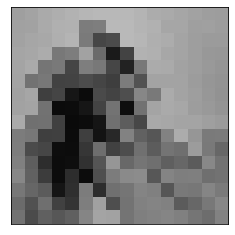

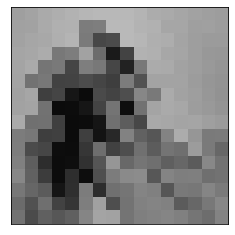

In [104]:
print("Reconstructed Image with CM:")
best_image_CM_reversible_DB = CM(samples_reversible_DB)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_CM_reversible_DB)))
imsave(best_image_CM_reversible_DB.reshape(16,16),"6.4.2.b")

print("Reconstructed Image with MAP:")
best_image_MAP_reversible_DB = MAP(samples_reversible_DB, target_distribution_DB)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_MAP_reversible_DB)))
imsave(best_image_MAP_reversible_DB.reshape(16,16),"6.4.2.c")

In [ ]:
dimension = len(img_noisy_scaled.flatten())

b_s = list(np.linspace(0.01,.8,25))
list_a_p = []

for b in b_s:
    proposal = Proposal(beta = beta, pick = "random_walk_nd")
    sampler = Sampler_Imaging(beta = b, N = 1000, dimension = dimension, image=img_noisy_scaled, proposal=proposal)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_High_Dimensions(10)
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

In [ ]:
finding_beta(b_s, list_a_p, "6.4.1.d")

In [107]:
np.random.seed(1)

dimension = len(img_blurred_scaled.flatten())

target_distribution_DB = Image_Target(img_blurred_scaled)
sampler_image = Sampler_Imaging(beta = 0.2, N = 10000, dimension=dimension, image=img_blurred_scaled, proposal=proposal)

samples_non_reversible_DB, _ = sampler_image.Non_Reversible_Metropolis_Hastings_High_Dimensions(10)

Reconstructed Image with CM:
MSE: 1206.576983555822
Reconstructed Image with MAP:
MSE: 1207.97265625


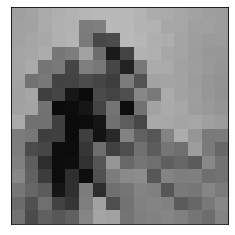

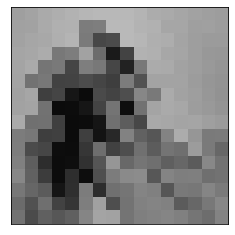

In [108]:
print("Reconstructed Image with CM:")
best_image_CM_NR_DB = CM(samples_non_reversible_DB)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_CM_NR_DB)))
imsave(best_image_CM_NR_DB.reshape(16,16),"6.4.2.e")

print("Reconstructed Image with MAP:")
best_image_MAP_NR_DB = MAP(samples_non_reversible_DB, target_distribution_DB)
print("MSE: {}".format(MSE(image_camera_scaled.flatten(), best_image_MAP_NR_DB)))
imsave(best_image_MAP_NR_DB.reshape(16,16),"6.4.2.f")

In [ ]:
def Non_Reversible_Metropolis_Hastings_High_Dimensions(self, period):

        # initalize
        u_0 = np.around(self.image.flatten())
        u_t = u_0

        direction_vectors = np.eye(self.dimension)
        #Pick a random direction
        y_p = direction_vectors[np.random.randint(self.dimension)]

        samples = [u_0]
        list_acceptance_probaility = []

        posterior_distribution = self.target_distribution

        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1

        def sgn(eta,y_p):
            x = np.dot(eta,y_p)
            if x >= 0:
                return 1
            else:
                return -1

        multivariate_normal = stats.multivariate_normal(np.zeros(self.dimension),self.beta**2*np.eye(self.dimension))

        def f_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
            else:
                return 0 

        def g_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return 0
            else:
                return (2/(2*np.pi*self.beta)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))

        for t in range(self.N):

            # Change direction y_p periodically
            if t%period == 0:
                y_p = direction_vectors[np.random.randint(self.dimension)]

            if z > 0: 
                
                eta = multivariate_normal.rvs()
                # sample a proposal u′ from density f(u′|u(t))
                u_prime = u_t + sgn(eta,y_p)*eta

                # π(u′)g(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*g_pdf(u_t, u_prime, y_p)

                # π(u(t))f(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*f_pdf(u_prime, u_t, y_p)

                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                    
                list_acceptance_probaility.append(acceptance_probaility)

            else:
                
                eta = multivariate_normal.rvs()
                # sample a proposal u′ from density g(u′|u(t))
                u_prime = u_t - sgn(eta,y_p)*eta

                # π(u′)f(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*f_pdf(u_t,u_prime, y_p)

                # π(u(t))g(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*g_pdf(u_prime, u_t, y_p)

                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))
                    
                list_acceptance_probaility.append(acceptance_probaility)

            rv = np.random.uniform(0,1,1)

            if rv <= acceptance_probaility:
                #Accept
                u_t = u_prime
                samples.append(u_t)
                z = z 
            else:
                #Reject
                u_t = u_t
                samples.append(u_t)
                z = -1*z
        
        #We return the samples and all the acceptance probabilities
        return samples, list_acceptance_probaility